### Proyecto intermodular Enero

In [1]:
# ==============================
# IMPORTACIÓN DE LIBRERÍAS
# ==============================

# ------------------------------------------------------------
# import pandas as pd:
#   - Manipulación de datos tabulares con DataFrames.
# ------------------------------------------------------------
import pandas as pd

# ------------------------------------------------------------
# import matplotlib.pyplot as plt:
#   - Visualización 2D con Matplotlib (figuras, ejes y gráficos).
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# from sklearn.model_selection import train_test_split:
#   - División reproducible en train/test (opcional: stratify para clasificación).
# ------------------------------------------------------------
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# from src.utils import load_yaml:
#   - Carga archivos YAML y retorna la configuración como dict.
#   - Carga datasets desde ruta (p. ej., CSV/Parquet/Excel) y retorna un DataFrame.
# ------------------------------------------------------------
from src.utils import load_yaml, load_dataset


In [2]:
# ==============================
# IMPORTACIÓN DE MÓDULOS DEL PROYECTO
# ==============================

# ------------------------------------------------------------
# from src.eda_helper import EDAHelper:
#   - Utilidades para EDA (resúmenes, nulos, distribuciones, correlaciones y gráficos).
# ------------------------------------------------------------
from src.eda_helper import EDAHelper

# ------------------------------------------------------------
# from src.preprocessing import DataPreprocessor:
#   - Preprocesamiento y feature engineering (fit/transform) evitando leakage.
# ------------------------------------------------------------
from src.preprocessing import DataPreprocessor

# ------------------------------------------------------------
# from src.reporting import ReportBuilder:
#   - Construcción de reportes/figuras y resumen de resultados del pipeline.
# ------------------------------------------------------------
from src.reporting import ReportBuilder

# ------------------------------------------------------------
# from src.training import Training:
#   - Entrenamiento y evaluación (holdout/CV) + métricas/persistencia.
# ------------------------------------------------------------
from src.training import Training

# ------------------------------------------------------------
# from src.model_manager import ModelManager:
#   - Gestión de modelos: guardado/carga, versionado y selección de ganadores.
# ------------------------------------------------------------
from src.model_manager import ModelManager


In [ ]:
# ==============================
# CONFIGURACIÓN DEL PIPELINE
# ==============================

# ------------------------------------------------------------
# cfg:
#   - Configuración cargada desde YAML para controlar el pipeline sin tocar código.
#   - Estructura: cfg["seccion"]["parametro"].
# ------------------------------------------------------------
cfg = load_yaml("config.yml")

# ==============================
# RUTAS
# ==============================

# ------------------------------------------------------------
# DATASET_TRAIN / MODELS_DIR:
#   - DATASET_TRAIN → ruta del dataset de entrenamiento.
#   - MODELS_DIR    → salida de modelos y artefactos (preprocesador, metadata, etc.).
# ------------------------------------------------------------
DATASET_TRAIN  = cfg["paths"]["dataset_train"]
MODELS_DIR     = cfg["paths"]["models_dir"]

# ==============================
# TARGET
# ==============================

# ------------------------------------------------------------
# TARGET / VALUE_TARGET:
#   - TARGET       → nombre de la columna objetivo en el DataFrame.
#   - VALUE_TARGET → clase/valor “positivo” o de interés (para binaria o reglas del negocio).
# ------------------------------------------------------------
TARGET         = cfg["target"]["col"]
VALUE_TARGET   = cfg["target"]["value"]

# ==============================
# PARÁMETROS GENERALES
# ==============================

# ------------------------------------------------------------
# MAX_EXAMPLES / SEP_LEN:
#   - MAX_EXAMPLES → límite de registros para pruebas rápidas (si se aplica en el flujo).
#   - SEP_LEN      → longitud de separadores/formatos para prints/logs.
# ------------------------------------------------------------
MAX_EXAMPLES   = cfg["config"]["max_examples"]
SEP_LEN        = cfg["config"]["sep_len"]

# ==============================
# SPLIT TRAIN / TEST
# ==============================

# ------------------------------------------------------------
# TEST_SIZE / RANDOM_STATE / USE_STRATIFY:
#   - TEST_SIZE    → proporción/tamaño del set de prueba.
#   - RANDOM_STATE → semilla para reproducibilidad del split.
#   - USE_STRATIFY → mantiene proporción de clases del target (recomendado en clasificación).
# ------------------------------------------------------------
TEST_SIZE      = cfg["split"]["test_size"]
RANDOM_STATE   = cfg["split"]["random_state"]
USE_STRATIFY   = cfg["split"]["stratify"]

# ==============================
# CROSS-VALIDATION
# ==============================

# ------------------------------------------------------------
# CV_SPLITS / CV_SHUFFLE / CV_RS:
#   - CV_SPLITS  → número de folds.
#   - CV_SHUFFLE → mezcla antes de crear folds (si aplica).
#   - CV_RS      → semilla cuando hay shuffle (reproducibilidad).
# ------------------------------------------------------------
CV_SPLITS      = cfg["cv"]["n_splits"]
CV_SHUFFLE     = cfg["cv"]["shuffle"]
CV_RS          = cfg["cv"]["random_state"]

# ==============================
# FLAGS
# ==============================

# ------------------------------------------------------------
# RUN_*:
#   - RUN_DROP_STATIC      → elimina variables constantes / casi constantes.
#   - RUN_TRANSFORMATION   → aplica transformaciones/feature engineering.
#   - RUN_DROP_CORRELATED  → elimina variables altamente correlacionadas.
#   - RUN_CROSS_VALIDATION → ejecuta CV sobre el train.
# ------------------------------------------------------------
RUN_DROP_STATIC      = cfg["flags"]["run_drop_static"]
RUN_TRANSFORMATION   = cfg["flags"]["run_transformation"]
RUN_DROP_CORRELATED  = cfg["flags"]["run_drop_correlated"]
RUN_CROSS_VALIDATION = cfg["flags"]["run_cross_validation"]


In [4]:
# ==============================
# INICIALIZACIÓN DE COMPONENTES DEL PIPELINE
# ==============================

# ------------------------------------------------------------
# EDA = EDAHelper(TARGET, MAX_EXAMPLES, SEP_LEN):
#   - Instancia el componente de EDA para análisis exploratorio y utilidades de diagnóstico.
#   - Entradas:
#       * TARGET       → nombre/clave de la variable objetivo.
#       * MAX_EXAMPLES → límite de ejemplos/filas a mostrar en salidas/resúmenes.
#       * SEP_LEN      → longitud de separadores para formateo visual en prints/reportes.
#   - Resultado:
#       * `EDA` queda listo para ejecutar resúmenes, validaciones y visualizaciones rápidas.
# ------------------------------------------------------------
EDA = EDAHelper(TARGET, MAX_EXAMPLES, SEP_LEN)

# ------------------------------------------------------------
# DataPreprocessor = DataPreprocessor():
#   - Crea el preprocesador responsable de transformar datos crudos a features de modelado.
#   - Nota técnica:
#       * Aquí el nombre de variable (`DataPreprocessor`) colisiona con el nombre de la clase.
#         Esto oculta la referencia a la clase en el resto del script.
#       * Recomendación habitual: usar `preprocessor = DataPreprocessor()` para evitar sombra.
# ------------------------------------------------------------
DataPreprocessor = DataPreprocessor()

# ------------------------------------------------------------
# Reporting = ReportBuilder():
#   - Inicializa el generador de reportes del flujo (tablas, métricas, figuras, exportaciones).
#   - Deja listo el componente para ir agregando secciones y construir el reporte final.
# ------------------------------------------------------------
Reporting = ReportBuilder()

# ------------------------------------------------------------
# Training = Training():
#   - Inicializa el orquestador de entrenamiento/evaluación.
#   - Gestiona ejecuciones (holdout/full), cálculo de métricas y persistencia de artefactos.
# ------------------------------------------------------------
Training = Training()

# ------------------------------------------------------------
# ModelManager = ModelManager():
#   - Inicializa el gestor de modelos (carga/guardado, selección de ganadores, versionado).
#   - Se usa para consolidar resultados y operar sobre el inventario de modelos persistidos.
# ------------------------------------------------------------
ModelManager = ModelManager()


In [5]:
# ==============================
# CONSTRUCCIÓN Y RESUMEN DE VARIANTES DE MODELO
# ==============================

# ------------------------------------------------------------
# MODEL_VARIANTS = ModelManager.build_model_variants_from_config(cfg):
#   - Genera variantes desde `cfg` combinando algoritmo, receta de variante, hiperparámetros y umbral.
#   - Parámetro:
#       * cfg → dict de configuración (sección de modelos/escenarios) usada para armar combinaciones.
#   - Retorno:
#       * MODEL_VARIANTS → dict con metadatos por variante (id, model_key, variant_id, class_name, threshold, params).
# ------------------------------------------------------------
MODEL_VARIANTS = ModelManager.build_model_variants_from_config(cfg)
print(f"\nVariantes construidas: {len(MODEL_VARIANTS)}")

# ------------------------------------------------------------
# rows:
#   - Acumulador para crear un DataFrame resumen a partir de MODEL_VARIANTS.
# ------------------------------------------------------------
rows = []

# ------------------------------------------------------------
# for variant in MODEL_VARIANTS.values():
#   - Extrae campos clave para inspección:
#       * id        → identificador único de la variante.
#       * model_key → familia/algoritmo (p. ej., "logreg", "rf", "xgb").
#       * variant_id→ nombre de la receta/configuración dentro del algoritmo.
#       * class_name→ clase real del estimador (auditoría).
#       * threshold → umbral de decisión (si el flujo binariza probabilidades/scores).
#       * params    → hiperparámetros aplicados al estimador.
# ------------------------------------------------------------
for variant in MODEL_VARIANTS.values():
    rows.append({
        "id": variant["id"],
        "model": variant["model_key"],
        "variant": variant["variant_id"],
        "class": variant["class_name"],
        "threshold": variant["threshold"],
        "params": variant["params"],
    })

# ------------------------------------------------------------
# VARIANTS_DF:
#   - Tabla consolidada y ordenada por (model, variant) para comparación y depuración.
# ------------------------------------------------------------
VARIANTS_DF = (
    pd.DataFrame(rows)
      .sort_values(["model", "variant"])
      .reset_index(drop=True)
)

# ------------------------------------------------------------
# display(VARIANTS_DF):
#   - Visualiza el resumen tabular de variantes y sus parámetros.
# ------------------------------------------------------------
display(VARIANTS_DF)



Variantes construidas: 28


,id,model,variant,class,threshold,params
0,CART__balanced,CART,balanced,DecisionTreeClassifier,0.50,"{'random_state': 42, 'class_weight': 'balanced..."
1,CART__max_recall,CART,max_recall,DecisionTreeClassifier,0.35,"{'random_state': 42, 'class_weight': 'balanced..."
2,CART__min_fp,CART,min_fp,DecisionTreeClassifier,0.70,"{'random_state': 42, 'max_depth': 4, 'min_samp..."
3,CART__normal,CART,normal,DecisionTreeClassifier,0.50,"{'random_state': 42, 'max_depth': None, 'min_s..."
4,KNN__balanced,KNN,balanced,KNeighborsClassifier,0.50,"{'n_neighbors': 25, 'weights': 'distance'}"
5,KNN__max_recall,KNN,max_recall,KNeighborsClassifier,0.35,"{'n_neighbors': 7, 'weights': 'distance'}"
6,KNN__min_fp,KNN,min_fp,KNeighborsClassifier,0.70,"{'n_neighbors': 45, 'weights': 'distance'}"
7,KNN__normal,KNN,normal,KNeighborsClassifier,0.50,"{'n_neighbors': 15, 'weights': 'uniform'}"
8,LDA__balanced,LDA,balanced,LinearDiscriminantAnalysis,0.50,"{'solver': 'lsqr', 'shrinkage': 'auto'}"
9,LDA__max_recall,LDA,max_recall,LinearDiscriminantAnalysis,0.35,"{'solver': 'lsqr', 'shrinkage': 0.1}"


In [6]:
# ==============================
# CARGA DEL DATASET DE ENTRENAMIENTO
# ==============================

# ------------------------------------------------------------
# df = EDA.load_dataset(DATASET_TRAIN):
#   - Carga el dataset desde `DATASET_TRAIN` y lo retorna como DataFrame.
#   - Parámetro:
#       * DATASET_TRAIN → ruta (str) al archivo de entrenamiento.
#   - Retorno:
#       * df → pandas.DataFrame listo para EDA/preprocesamiento.
# ------------------------------------------------------------
df = load_dataset(DATASET_TRAIN)

# ==============================
# INSPECCIÓN RÁPIDA
# ==============================

# ------------------------------------------------------------
# df.head(5):
#   - Muestra 5 filas para validar columnas, valores y nulos evidentes (no modifica `df`).
# ------------------------------------------------------------
df.head(5)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,21,Travel_Rarely,1343,Sales,22,1,Technical Degree,1,669,3,...,80,0,3,2,3,3,2,1,2,No
1,24,Travel_Rarely,693,Sales,3,2,Life Sciences,1,720,1,...,80,0,4,3,3,2,2,2,0,Yes
2,42,Travel_Rarely,933,Research & Development,29,3,Life Sciences,1,836,2,...,80,1,10,3,2,9,8,7,8,No
3,46,Travel_Rarely,168,Sales,4,2,Marketing,1,1280,4,...,80,1,26,2,3,11,4,0,8,No
4,35,Travel_Frequently,880,Sales,12,4,Other,1,1667,4,...,80,0,13,2,4,11,9,6,7,Yes


In [7]:
# ==============================
# LIMPIEZA DE VALORES FALTANTES
# ==============================

# ------------------------------------------------------------
# df = EDA.clean_missing(df, verbose=True):
#   - Aplica estrategia de limpieza/imputación de valores faltantes sobre `df`.
#   - Parámetros:
#       * df      → DataFrame de entrada a limpiar.
#       * verbose → si True, imprime resumen de nulos y acciones aplicadas.
#   - Retorno:
#       * df → DataFrame actualizado tras el tratamiento de missing values.
# ------------------------------------------------------------
df = EDA.clean_missing(df, verbose=True)

# ------------------------------------------------------------
# df.head(5):
#   - Verificación rápida post-limpieza.
# ------------------------------------------------------------
df.head(5)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,21,Travel_Rarely,1343,Sales,22,1,Technical Degree,1,669,3,...,80,0,3,2,3,3,2,1,2,No
1,24,Travel_Rarely,693,Sales,3,2,Life Sciences,1,720,1,...,80,0,4,3,3,2,2,2,0,Yes
2,42,Travel_Rarely,933,Research & Development,29,3,Life Sciences,1,836,2,...,80,1,10,3,2,9,8,7,8,No
3,46,Travel_Rarely,168,Sales,4,2,Marketing,1,1280,4,...,80,1,26,2,3,11,4,0,8,No
4,35,Travel_Frequently,880,Sales,12,4,Other,1,1667,4,...,80,0,13,2,4,11,9,6,7,Yes


In [8]:
# ==============================
# ELIMINACIÓN DE COLUMNAS NO INFORMATIVAS
# ==============================

# ------------------------------------------------------------
# DROP_USELESS_COLS:
#   - Columnas típicamente constantes o identificadores (ruido / no generalizan).
# ------------------------------------------------------------
DROP_USELESS_COLS = [
    "EmployeeCount",
    "EmployeeNumber",
    "Over18",
    "StandardHours"
]

# ------------------------------------------------------------
# if RUN_DROP_STATIC:
#   - Controla esta etapa desde config.
#   - DataPreprocessor.drop_columns(df, cols) elimina columnas listadas.
#   - Parámetros:
#       * df   → DataFrame de entrada.
#       * cols → lista de columnas a eliminar.
#   - Retorno:
#       * df → DataFrame sin dichas columnas (si existen).
# ------------------------------------------------------------
if RUN_DROP_STATIC:
    df = DataPreprocessor.drop_columns(df, DROP_USELESS_COLS)


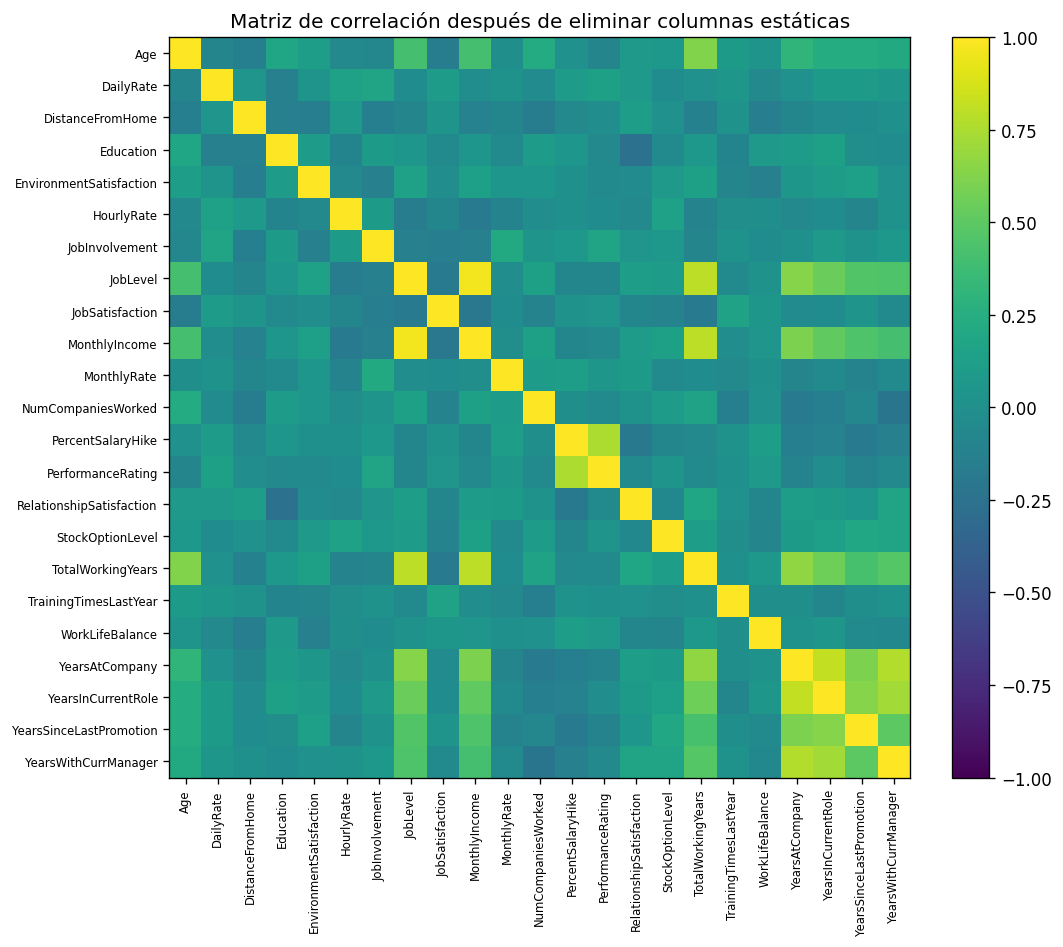

In [9]:
# ==============================
# MATRIZ DE CORRELACIÓN POST-ELIMINACIÓN DE COLUMNAS ESTÁTICAS
# ==============================

# ------------------------------------------------------------
# ReportBuilder.plot_correlation_matrix(df, plt, "Título"):
#   - Calcula y grafica la matriz de correlación usando el `df` ya depurado (sin columnas estáticas).
#   - Parámetros:
#       * df    → DataFrame (idealmente numérico) tras eliminar variables constantes/no informativas.
#       * plt   → matplotlib.pyplot para renderizar el heatmap.
#       * title → título del gráfico para identificar la etapa del pipeline.
# ------------------------------------------------------------
ReportBuilder.plot_correlation_matrix(df, plt, "Matriz de correlación después de eliminar columnas estáticas")


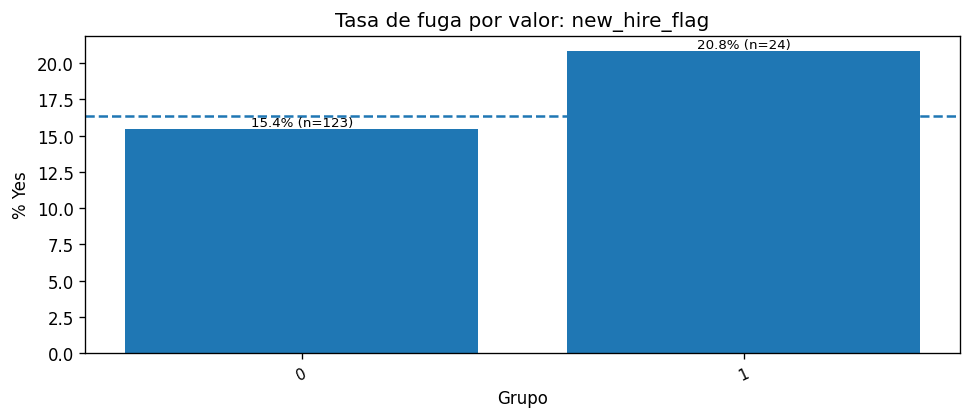

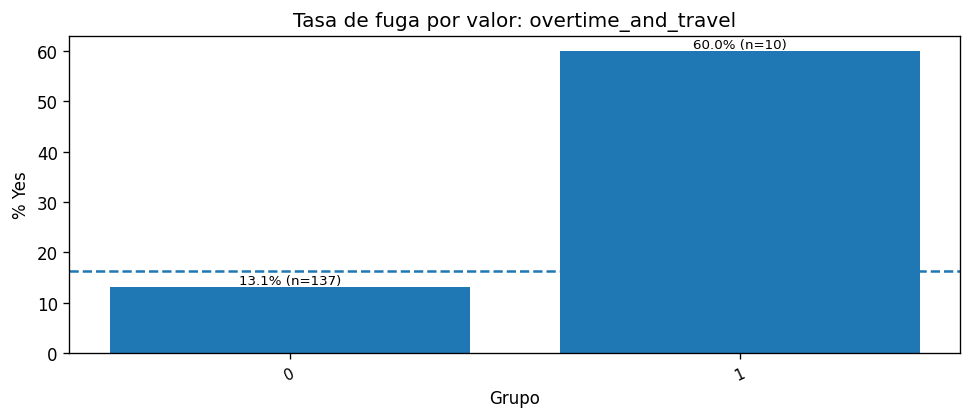

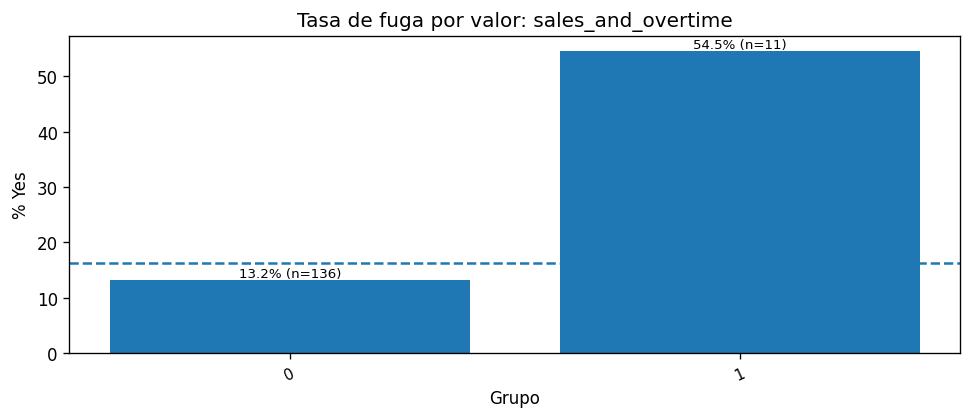

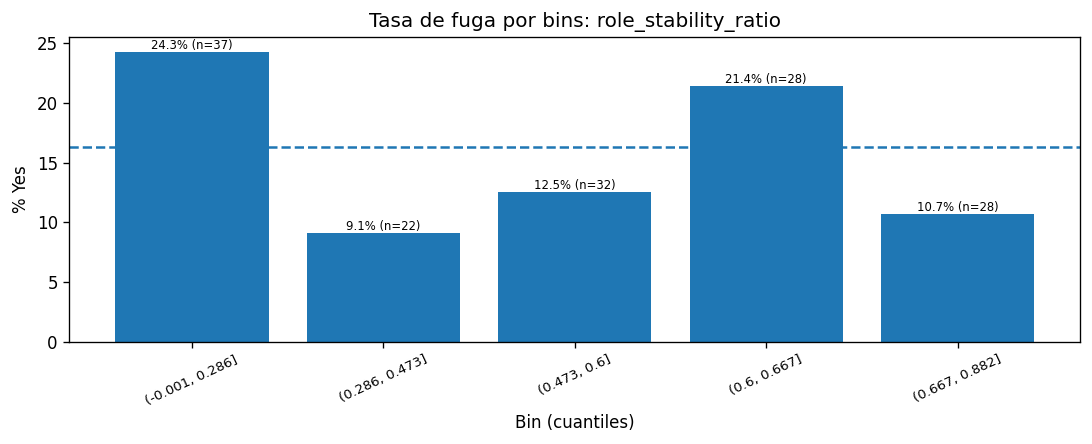

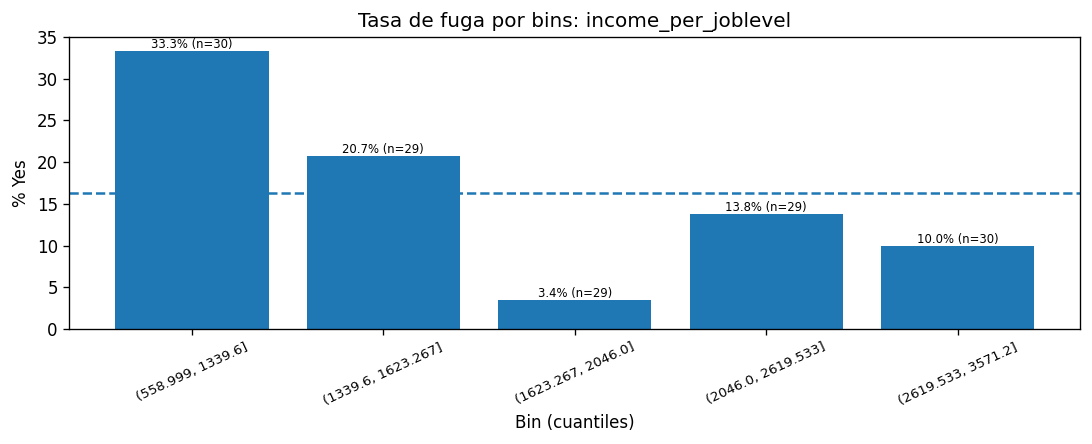

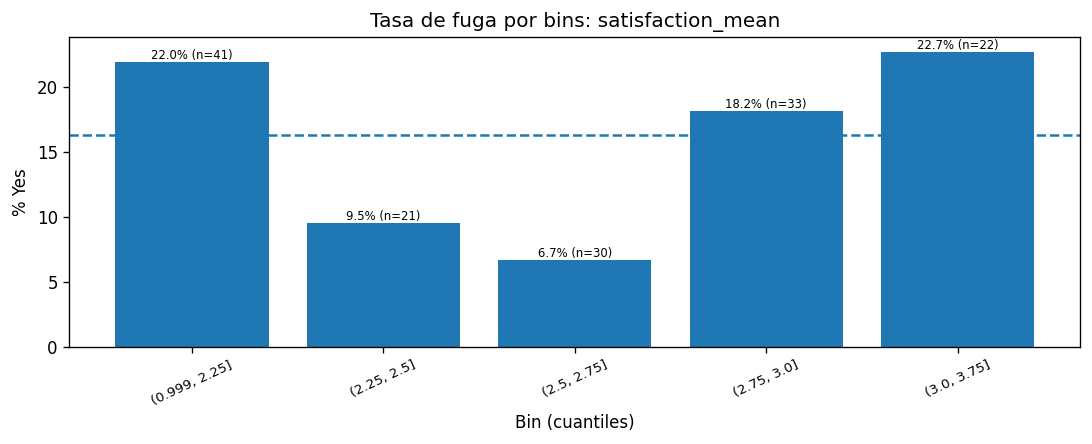

Tasa base (Attrition=Yes): 16.33%


In [10]:
# ==============================
# TRANSFORMACIÓN Y FEATURE ENGINEERING
# ==============================

# ------------------------------------------------------------
# if RUN_TRANSFORMATION:
#   - Controla desde config la creación de nuevas variables y su análisis inicial.
# ------------------------------------------------------------
if RUN_TRANSFORMATION:

    # ------------------------------------------------------------
    # df = DataPreprocessor.add_feature_engineering(df):
    #   - Añade variables derivadas al DataFrame (features nuevas para mejorar señal del modelo).
    #   - Parámetro:
    #       * df → DataFrame base.
    #   - Retorno:
    #       * df → DataFrame con columnas nuevas incorporadas.
    # ------------------------------------------------------------
    df = DataPreprocessor.add_feature_engineering(df)

    # ------------------------------------------------------------
    # new_cols:
    #   - Lista de features creadas a evaluar (debe coincidir con nombres generados en el paso anterior).
    # ------------------------------------------------------------
    new_cols = [
        "new_hire_flag",
        "overtime_and_travel",
        "sales_and_overtime",
        "role_stability_ratio",
        "income_per_joblevel",
        "satisfaction_mean"
    ]

    # ------------------------------------------------------------
    # ReportBuilder.plot_attrition_rate_for_features(...):
    #   - Grafica la tasa del target por feature (útil para validar señal y detectar patrones).
    #   - Parámetros:
    #       * df                   → DataFrame ya transformado.
    #       * target_col           → columna objetivo (TARGET).
    #       * target_positive_value→ valor/clase positiva (VALUE_TARGET).
    #       * feature_cols         → lista de features a analizar (new_cols).
    #       * plt                  → matplotlib.pyplot para renderizado.
    # ------------------------------------------------------------
    ReportBuilder.plot_attrition_rate_for_features(
        df,
        target_col=TARGET,
        target_positive_value=VALUE_TARGET,
        feature_cols=new_cols,
        plt=plt
    )


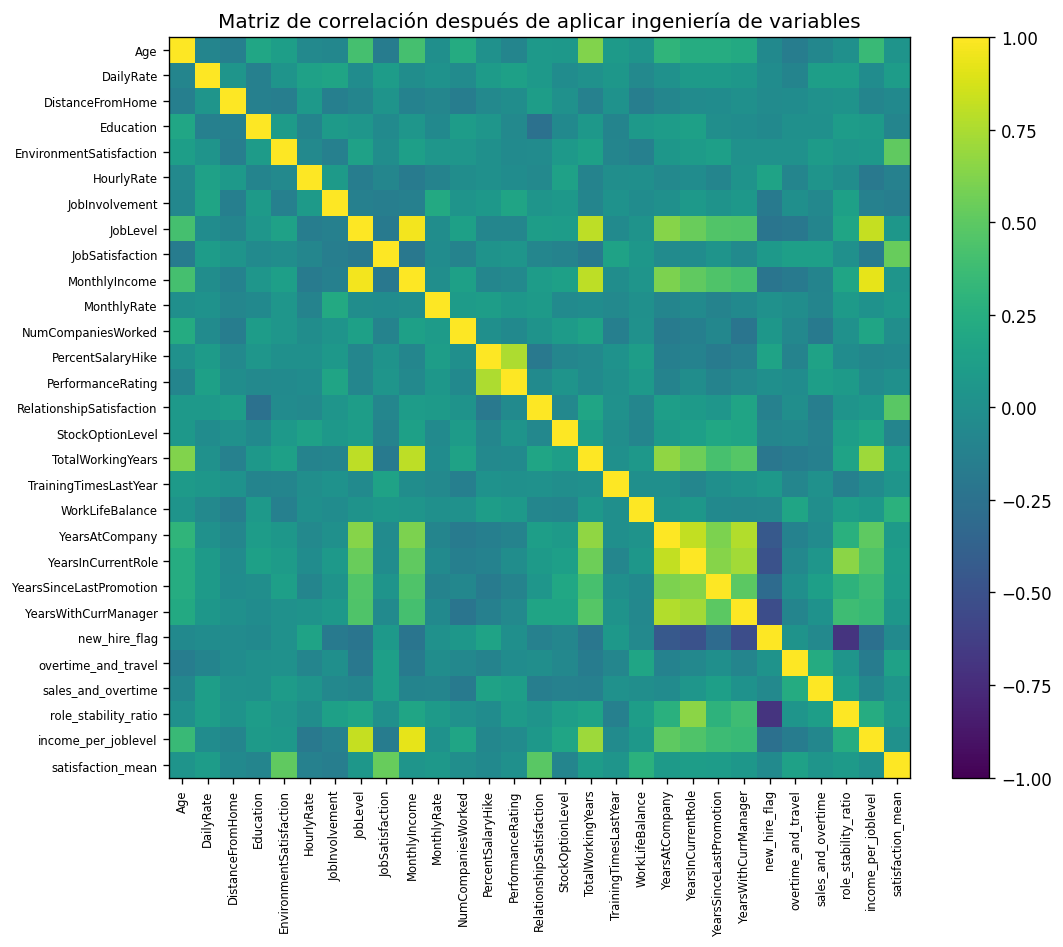

In [11]:
# ==============================
# MATRIZ DE CORRELACIÓN POST-INGENIERÍA DE VARIABLES
# ==============================

# ------------------------------------------------------------
# ReportBuilder.plot_correlation_matrix(df, plt, "Título"):
#   - Calcula y grafica correlaciones usando el `df` ya transformado (con features nuevas).
#   - Parámetros:
#       * df    → DataFrame post-feature engineering (idealmente columnas numéricas).
#       * plt   → matplotlib.pyplot para renderizar el heatmap.
#       * title → título del gráfico para identificar la etapa del pipeline.
# ------------------------------------------------------------
ReportBuilder.plot_correlation_matrix(df, plt, "Matriz de correlación después de aplicar ingeniería de variables")


In [12]:
# ==============================
# LISTA DE COLUMNAS A ELIMINAR POR CORRELACIÓN / REDUNDANCIA
# ==============================

# ------------------------------------------------------------
# DROP_CORRELATED_COLS:
#   - Lista explícita de columnas candidatas a eliminar por alta correlación o redundancia informativa.
#   - Propósito:
#       * Reducir dimensionalidad y multicolinealidad.
#       * Evitar duplicidad de señal entre variables que capturan conceptos similares.
#       * Simplificar el modelo y mejorar estabilidad (especialmente en modelos lineales).
#
# Notas técnicas:
#   - Esta lista suele construirse tras un análisis de correlación (Pearson/Spearman) en variables numéricas
#     o mediante criterios alternativos (VIF, mutual information, análisis de importancia, etc.).
#   - En presencia de features categóricas transformadas con OHE, la correlación puede cambiar:
#       * aplicar esta lista preferentemente antes de OHE (sobre columnas originales) si corresponde al análisis.
#   - Validar siempre:
#       * que las columnas existan en el DataFrame
#       * que no se esté eliminando una variable crítica para el negocio/interpretación
# ------------------------------------------------------------
DROP_CORRELATED_COLS = [
    "EnvironmentSatisfaction",
    "JobLevel",
    "JobSatisfaction",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "TotalWorkingYears",
    "WorkLifeBalance",
    "YearsInCurrentRole",
    "YearsWithCurrManager"
]

# ------------------------------------------------------------
# df = drop_columns(df, DROP_CORRELATED_COLS):
#   - Elimina del DataFrame las columnas listadas en DROP_CORRELATED_COLS.
#   - Propósito:
#       * Reducir dimensionalidad y ruido.
#       * Evitar variables constantes o identificadores que no generalizan.
#   - Entradas:
#       * df        → DataFrame original.
#       * DROP_CORRELATED_COLS → lista de nombres de columnas a eliminar.
#   - Salida:
#       * df → nuevo DataFrame sin las columnas indicadas (o el mismo si no se eliminaron).
#   - Notas técnicas:
#       * Se asume implementación en src.functions.
#       * Buenas prácticas en la implementación:
#           * ignorar columnas inexistentes (errors="ignore") o reportarlas de forma controlada.
#           * devolver copia/objeto resultante sin efectos colaterales no documentados.
# ------------------------------------------------------------
if RUN_DROP_CORRELATED:
    df = DataPreprocessor.drop_columns(df, DROP_CORRELATED_COLS)


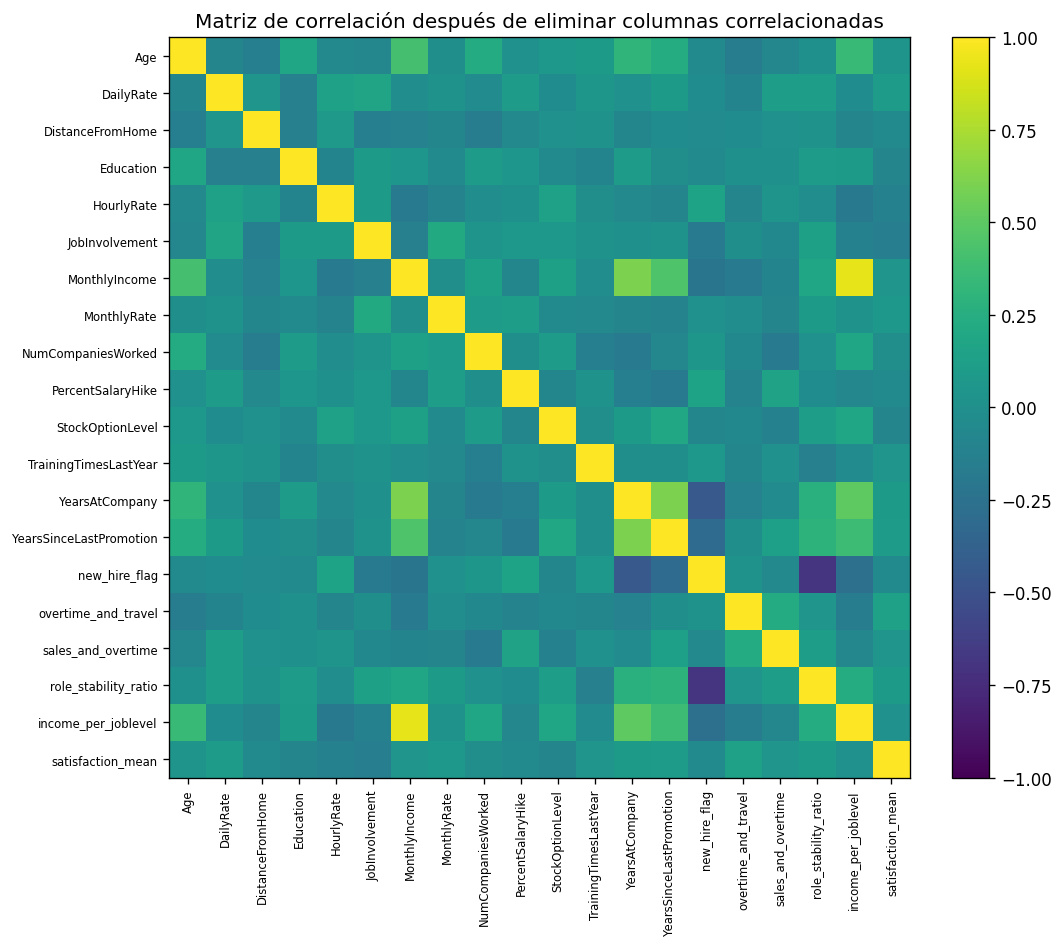

In [13]:
# ==============================
# MATRIZ DE CORRELACIÓN POST-ELIMINACIÓN DE VARIABLES CORRELACIONADAS
# ==============================

# ------------------------------------------------------------
# ReportBuilder.plot_correlation_matrix(df, plt, "Título"):
#   - Grafica la correlación con el `df` ya filtrado para reducir multicolinealidad.
#   - Parámetros:
#       * df    → DataFrame final tras eliminar variables altamente correlacionadas.
#       * plt   → matplotlib.pyplot para renderizar el heatmap.
#       * title → título del gráfico para marcar la etapa del pipeline.
# ------------------------------------------------------------
ReportBuilder.plot_correlation_matrix(df, plt, "Matriz de correlación después de eliminar columnas correlacionadas")


,variable,n_non_null,min_real,max_real,q1,q3,iqr,lower,upper,outliers_count,outliers_pct,outliers_yes,outliers_no,outliers_yes_pct_in_class,outliers_no_pct_in_class
0,new_hire_flag,147,0.0,1.00,0.00,0.00,0.00,0.00,0.00,24,16.33,5,19,20.83,15.45
1,NumCompaniesWorked,147,0.0,9.00,1.00,4.00,3.00,-3.50,8.50,12,8.16,4,8,16.67,6.50
2,YearsAtCompany,147,0.0,33.00,3.00,9.00,6.00,-6.00,18.00,12,8.16,3,9,12.50,7.32
3,DistanceFromHome,147,1.0,29.00,2.00,11.00,9.00,-11.50,24.50,11,7.48,0,11,0.00,8.94
4,MonthlyIncome,147,1118.0,19999.00,2951.00,9223.50,6272.50,-6457.75,18632.25,11,7.48,1,10,4.17,8.13
5,sales_and_overtime,147,0.0,1.00,0.00,0.00,0.00,0.00,0.00,11,7.48,6,5,25.00,4.07
6,YearsSinceLastPromotion,147,0.0,15.00,0.00,3.00,3.00,-4.50,7.50,10,6.80,1,9,4.17,7.32
7,overtime_and_travel,147,0.0,1.00,0.00,0.00,0.00,0.00,0.00,10,6.80,6,4,25.00,3.25
8,StockOptionLevel,147,0.0,3.00,0.00,1.00,1.00,-1.50,2.50,7,4.76,2,5,8.33,4.07
9,satisfaction_mean,147,1.0,3.75,2.25,3.00,0.75,1.12,4.12,1,0.68,1,0,4.17,0.00


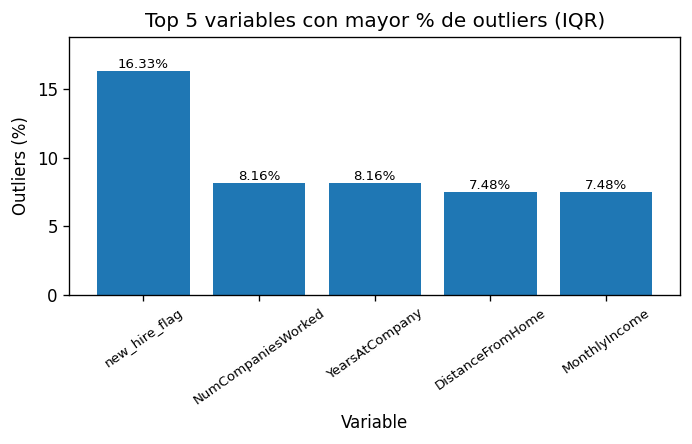

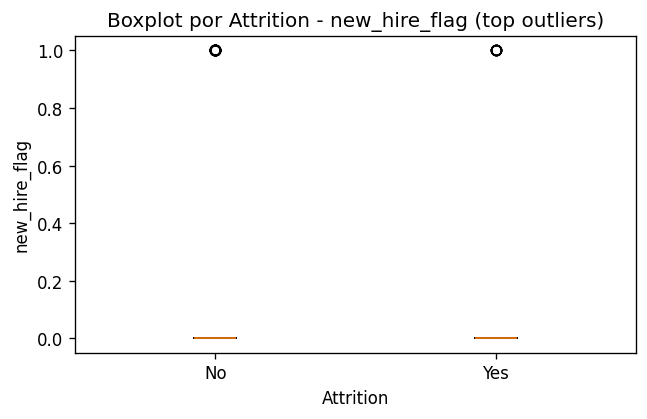

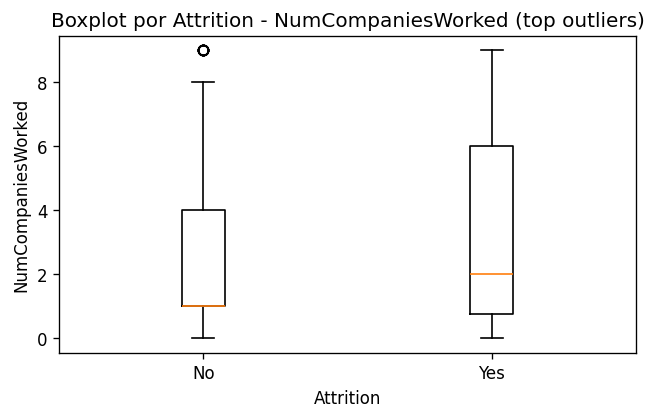

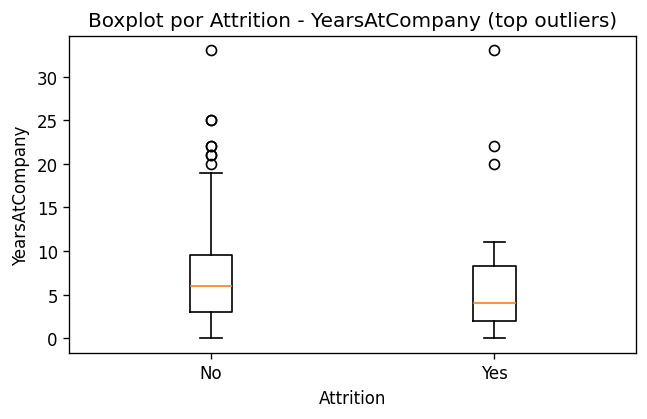

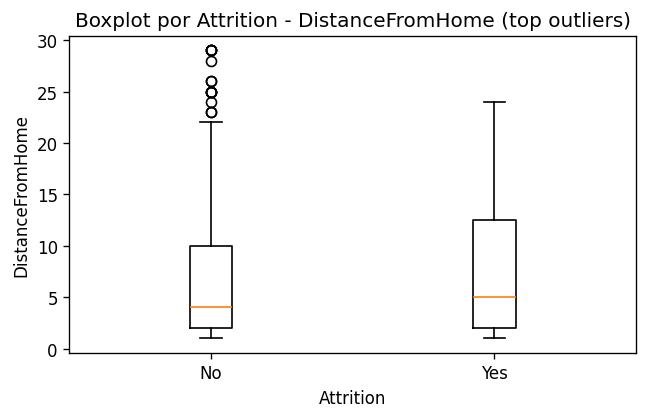

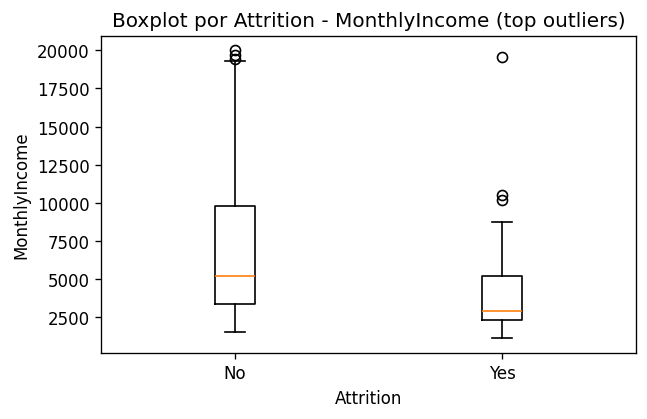

In [14]:
# ==============================
# DIAGNÓSTICO DE OUTLIERS (IQR)
# ==============================

# ------------------------------------------------------------
# summary = EDA.iqr_outlier_summary(df, TARGET, DROP_USELESS_COLS):
#   - Calcula outliers por IQR en variables numéricas (excluye TARGET y columnas indicadas).
#   - Parámetros:
#       * df               → DataFrame a analizar.
#       * TARGET           → columna objetivo a excluir.
#       * DROP_USELESS_COLS→ columnas a excluir (IDs/constantes/no útiles).
#   - Retorno:
#       * summary → tabla con conteo/% de outliers y límites IQR por variable (según implementación).
# ------------------------------------------------------------
summary = EDA.iqr_outlier_summary(df, TARGET, DROP_USELESS_COLS)

# ------------------------------------------------------------
# display(summary):
#   - Inspección rápida del ranking de variables con más outliers.
# ------------------------------------------------------------
display(summary)

# ------------------------------------------------------------
# EDA.plot_outlier_pct_bar(summary, top_n, plt):
#   - Barplot del % de outliers por variable (top_n = 5).
# ------------------------------------------------------------
EDA.plot_outlier_pct_bar(summary, 5, plt)

# ------------------------------------------------------------
# EDA.plot_boxplots_top_outliers(df, summary, TARGET, top_n, plt):
#   - Boxplots de las variables con más outliers para validar distribución (top_n = 5).
# ------------------------------------------------------------
EDA.plot_boxplots_top_outliers(df, summary, TARGET, 5, plt)


In [15]:
# ==============================
# CONSTRUCCIÓN DE X/Y + SPLIT + PREPROCESADOR
# ==============================

# ------------------------------------------------------------
# y = (df[TARGET] == VALUE_TARGET).astype(int):
#   - Target binario: 1 si TARGET == VALUE_TARGET, si no 0.
#   - Parámetros:
#       * TARGET       → columna objetivo en `df`.
#       * VALUE_TARGET → valor/clase considerada positiva.
# ------------------------------------------------------------
y = (df[TARGET] == VALUE_TARGET).astype(int)

# ------------------------------------------------------------
# X = df.drop(columns=[TARGET]).copy():
#   - Features sin la columna objetivo (evita leakage directo).
#   - Parámetro:
#       * TARGET → columna a eliminar de `df`.
# ------------------------------------------------------------
X = df.drop(columns=[TARGET]).copy()

# ------------------------------------------------------------
# STRATIFY:
#   - Si USE_STRATIFY=True, mantiene proporción de clases en train/test usando `y`.
# ------------------------------------------------------------
STRATIFY = y if USE_STRATIFY else None

# ------------------------------------------------------------
# train_test_split(...):
#   - Divide en train/test con control de tamaño y reproducibilidad.
#   - Parámetros:
#       * test_size    → %/tamaño del set de prueba.
#       * random_state → semilla para reproducibilidad.
#       * stratify     → y (si estratifica) o None.
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    stratify=STRATIFY,
    test_size=TEST_SIZE
)

# ------------------------------------------------------------
# preprocessor, num_cols, cat_cols = DataPreprocessor.build_preprocessor_ohe_from_X(X_train):
#   - Construye el preprocesador (OHE para categóricas) tomando columnas desde X_train.
#   - Parámetros:
#       * X_train → features de entrenamiento (base para definir num_cols/cat_cols).
#   - Retornos:
#       * preprocessor → transformador listo para integrarse en un Pipeline.
#       * num_cols     → columnas numéricas detectadas.
#       * cat_cols     → columnas categóricas detectadas.
# ------------------------------------------------------------
preprocessor, num_cols, cat_cols = DataPreprocessor.build_preprocessor_ohe_from_X(X_train)


In [16]:
# ==============================
# VALIDACIÓN CRUZADA
# ==============================

# ------------------------------------------------------------
# cv_summary_df / cv_folds_df:
#   - Variables de salida para almacenar resultados de validación cruzada.
#   - Se inicializan en `None` para mantener un flujo seguro si la CV está desactivada.
#   - Estructura esperada:
#       * cv_summary_df → resumen por modelo (media y desviación de métricas)
#       * cv_folds_df   → detalle por fold (métricas de cada partición)
# ------------------------------------------------------------
cv_summary_df = None
cv_folds_df   = None

# ------------------------------------------------------------
# if RUN_CROSS_VALIDATION:
#   - Ejecuta validación cruzada solo cuando el flag está activo.
#   - Compara variantes de modelo definidas en `MODEL_VARIANTS`.
#   - Aplica `preprocessor` dentro de cada fold para consistencia y para evitar leakage.
# ------------------------------------------------------------
if RUN_CROSS_VALIDATION:
    cv_summary_df, cv_folds_df = Training.run_cross_validation(
        MODEL_VARIANTS=MODEL_VARIANTS,
        preprocessor=preprocessor,
        X_train=X_train,
        y_train=y_train,
        cv_splits=CV_SPLITS,
        cv_shuffle=CV_SHUFFLE,
        cv_random_state=CV_RS,
        use_tqdm=True
    )

    # ------------------------------------------------------------
    # Salidas:
    #   - Resumen → rendimiento promedio y estabilidad (variación entre folds).
    #   - Detalle → auditoría fold a fold para detectar inestabilidad o splits atípicos.
    # ------------------------------------------------------------
    print("\n📊 RESUMEN DE VALIDACIÓN CRUZADA (CV) — Media y desviación por modelo")
    display(cv_summary_df)

    print("\n📊 DETALLE DE VALIDACIÓN CRUZADA (CV) — Métricas por fold")
    display(cv_folds_df)


In [17]:
# ==============================
# HOLDOUT: ENTRENAMIENTO, EVALUACIÓN Y PERSISTENCIA
# ==============================

# ------------------------------------------------------------
# Training.run_holdout_and_persist(...):
#   - Entrena y evalúa variantes de modelos en esquema holdout (train/test).
#   - Persiste artefactos en disco (modelos y/o metadata) bajo `models_dir`.
#
#   - Entradas:
#       * MODEL_VARIANTS → catálogo de modelos/hiperparámetros a ejecutar.
#       * preprocessor   → transformaciones consistentes (evita data leakage).
#       * X_train/y_train, X_test/y_test → particiones para entrenamiento y evaluación.
#       * models_dir     → directorio base de guardado.
#       * show_progress  → habilita barra de progreso en ejecución.
#
#   - Salidas:
#       * RESULTS_HOLDOUT_DF  → tabla con métricas/metadata por modelo.
#       * HOLDOUT_SCORES      → estructura auxiliar de scores (según implementación).
#       * MODELS_HOLDOUT_DIR  → carpeta final donde quedaron los artefactos holdout.
# ------------------------------------------------------------
RESULTS_HOLDOUT_DF, HOLDOUT_SCORES, MODELS_HOLDOUT_DIR = Training.run_holdout_and_persist(
    MODEL_VARIANTS=MODEL_VARIANTS,
    preprocessor=preprocessor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    models_dir=MODELS_DIR,
    show_progress=True
)

# ------------------------------------------------------------
# display(...):
#   - Muestra resultados ordenados por nombre de modelo para inspección rápida.
# ------------------------------------------------------------
display(RESULTS_HOLDOUT_DF.sort_values(by=["model"], ascending=True))

# ------------------------------------------------------------
# print(...):
#   - Reporta cuántos modelos quedaron registrados/guardados en el holdout.
# ------------------------------------------------------------
print(f"Modelos HOLDOUT guardados: {len(RESULTS_HOLDOUT_DF)}")


Entrenando y guardando modelos holdout:   0%|          | 0/28 [00:00<?, ?it/s]

,model,threshold,accuracy,recall,precision,specificity,f1,roc_auc,tp,tn,fp,fn
9,CART__balanced,0.50,0.700000,0.0,0.000000,0.84,0.000000,0.400,0,21,4,5
11,CART__max_recall,0.35,0.733333,0.0,0.000000,0.88,0.000000,0.440,0,22,3,5
10,CART__min_fp,0.70,0.833333,0.0,0.000000,1.00,0.000000,0.308,0,25,0,5
8,CART__normal,0.50,0.800000,0.2,0.333333,0.92,0.250000,0.560,1,23,2,4
5,KNN__balanced,0.50,0.833333,0.0,0.000000,1.00,0.000000,0.736,0,25,0,5
7,KNN__max_recall,0.35,0.800000,0.0,0.000000,0.96,0.000000,0.672,0,24,1,5
6,KNN__min_fp,0.70,0.833333,0.0,0.000000,1.00,0.000000,0.760,0,25,0,5
4,KNN__normal,0.50,0.833333,0.0,0.000000,1.00,0.000000,0.744,0,25,0,5
1,LDA__balanced,0.50,0.900000,0.4,1.000000,1.00,0.571429,0.704,2,25,0,3
3,LDA__max_recall,0.35,0.833333,0.2,0.500000,0.96,0.285714,0.568,1,24,1,4


Modelos HOLDOUT guardados: 28



S1 (HOLDOUT) — TOP 3 por: recall, f1, roc_auc
               model  threshold  accuracy  recall  precision  specificity       f1  roc_auc  tp  tn  fp  fn
  NaiveBayes__min_fp        0.7  0.300000     1.0   0.192308         0.16 0.322581    0.944   5   4  21   0
  NaiveBayes__normal        0.5  0.266667     1.0   0.185185         0.12 0.312500    0.944   5   3  22   0
NaiveBayes__balanced        0.4  0.266667     1.0   0.185185         0.12 0.312500    0.944   5   3  22   0


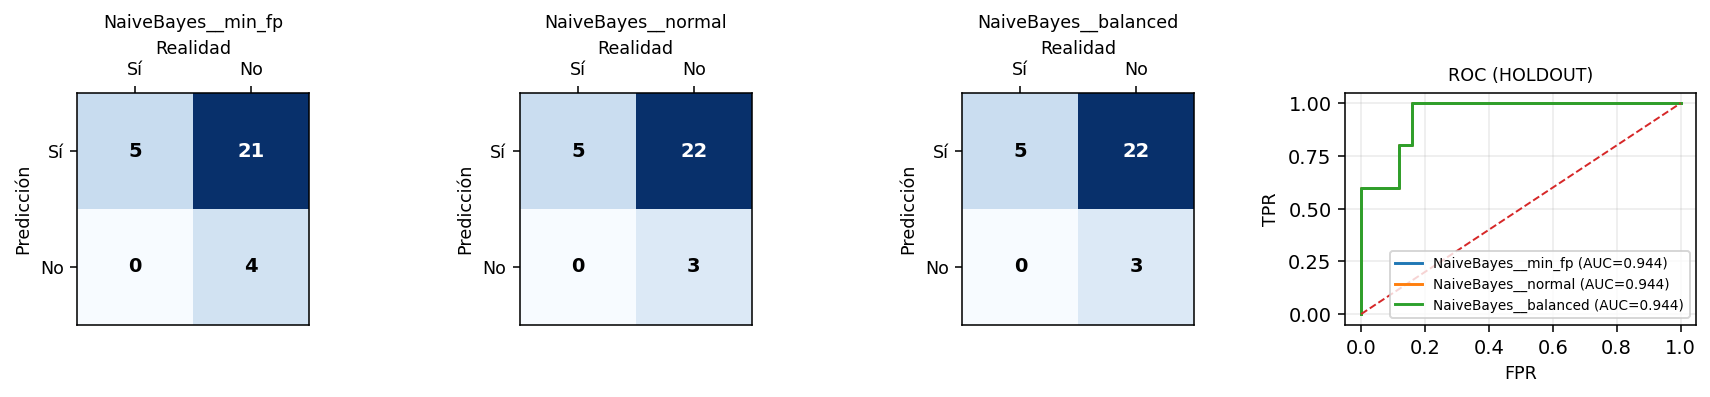

In [18]:
# ==============================
# REPORTE DE ESCENARIO — HOLDOUT
# ==============================

# ------------------------------------------------------------
# Reporting.plot_scenario_report(...):
#   - Genera un reporte gráfico del escenario "S1" usando resultados de evaluación en HOLDOUT.
#   - Consolida métricas y visualizaciones típicas de desempeño (según implementación):
#       * comparación de predicción vs. real
#       * métricas almacenadas en `scores_store`
#       * gráficos de error/diagnóstico y/o curvas relevantes
#
#   - Parámetros:
#       * "S1"               → identificador del escenario (útil para títulos, logging y trazabilidad).
#       * cfg                → configuración del experimento (umbrales, labels, paths, estilo, etc.).
#       * RESULTS_HOLDOUT_DF  → DataFrame con predicciones/score por muestra para el set holdout.
#       * y_test             → ground truth del holdout para cálculo/validación de métricas.
#       * plt                → matplotlib.pyplot para renderizado del reporte.
#       * scores_store       → diccionario/estructura donde se guardan métricas del holdout.
#       * set_name="HOLDOUT" → etiqueta del conjunto evaluado para rotulado consistente.
#
#   - Notas técnicas:
#       * Requiere alineación de índices/orden entre `RESULTS_HOLDOUT_DF` y `y_test`.
#       * Si el reporte calcula métricas, `scores_store` permite persistirlas y compararlas
#         luego contra otros escenarios o conjuntos (train/CV/holdout).
# ------------------------------------------------------------
Reporting.plot_scenario_report(
    "S1",
    cfg,
    RESULTS_HOLDOUT_DF,
    y_test,
    plt,
    scores_store=HOLDOUT_SCORES,
    set_name="HOLDOUT"
)



S2 (HOLDOUT) — TOP 3 por: precision, specificity
          model  threshold  accuracy  recall  precision  specificity       f1  roc_auc  tp  tn  fp  fn
  LDA__balanced       0.50  0.900000     0.4        1.0         1.00 0.571429    0.704   2  25   0   3
    LDA__min_fp       0.70  0.866667     0.2        1.0         1.00 0.333333    0.576   1  25   0   4
LDA__max_recall       0.35  0.833333     0.2        0.5         0.96 0.285714    0.568   1  24   1   4


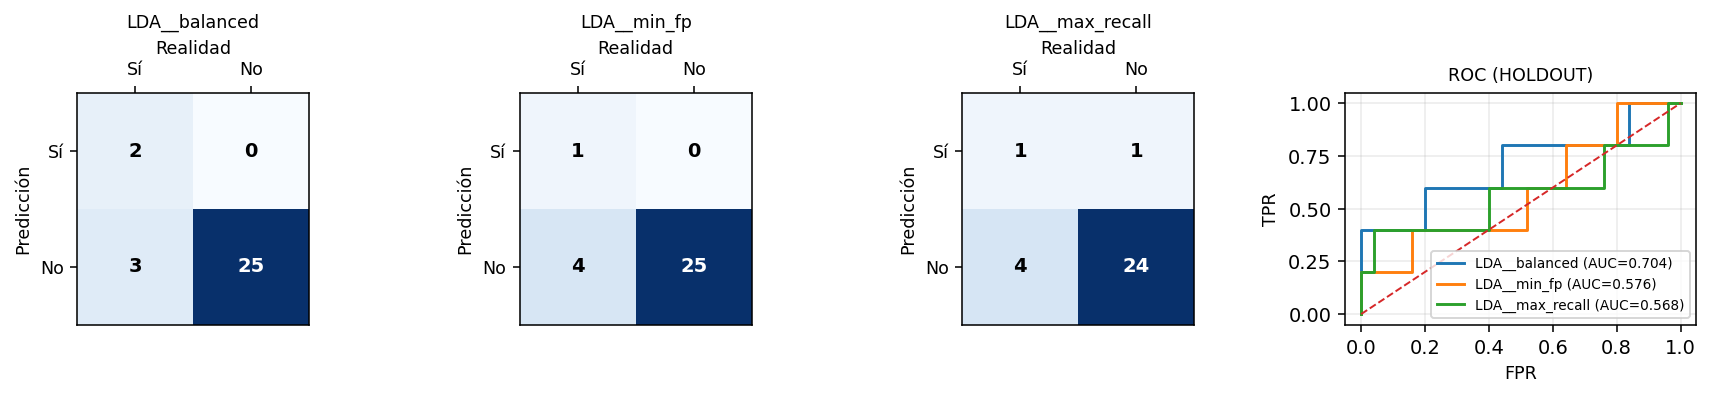

In [19]:
# ==============================
# REPORTE DE ESCENARIO — HOLDOUT
# ==============================

# ------------------------------------------------------------
# Reporting.plot_scenario_report(...):
#   - Genera el reporte del escenario "S2" sobre el conjunto HOLDOUT, usando el mismo
#     DataFrame de resultados y etiquetas reales para mantener comparabilidad con otros escenarios.
#   - Se usa para contrastar desempeño/configuración del escenario S2 frente a S1 u otros:
#       * cambios de features / preprocesamiento / umbrales / modelo (según pipeline)
#       * impacto en métricas y patrones de error en datos no vistos
#
#   - Parámetros:
#       * "S2"               → identificador del escenario (títulos, tracking, comparación).
#       * cfg                → configuración común del experimento/reporte.
#       * RESULTS_HOLDOUT_DF  → predicciones/resultados del holdout (base para gráficos/métricas).
#       * y_test             → ground truth del holdout para evaluación.
#       * plt                → matplotlib.pyplot para renderizado.
#       * scores_store       → almacén de métricas del holdout (persistencia y comparación).
#       * set_name="HOLDOUT" → etiqueta explícita del set evaluado.
#
#   - Notas técnicas:
#       * Asegurar alineación entre `RESULTS_HOLDOUT_DF` y `y_test` para evitar métricas inválidas.
#       * Si `scores_store` se reutiliza, las claves deberían diferenciar escenarios ("S1", "S2").
# ------------------------------------------------------------
Reporting.plot_scenario_report(
    "S2",
    cfg,
    RESULTS_HOLDOUT_DF,
    y_test,
    plt,
    scores_store=HOLDOUT_SCORES,
    set_name="HOLDOUT"
)



S3 (HOLDOUT) — TOP 3 por: f1, roc_auc
             model  threshold  accuracy  recall  precision  specificity       f1  roc_auc  tp  tn  fp  fn
     LDA__balanced        0.5  0.900000     0.4   1.000000         1.00 0.571429    0.704   2  25   0   3
       LDA__min_fp        0.7  0.866667     0.2   1.000000         1.00 0.333333    0.576   1  25   0   4
NaiveBayes__min_fp        0.7  0.300000     1.0   0.192308         0.16 0.322581    0.944   5   4  21   0


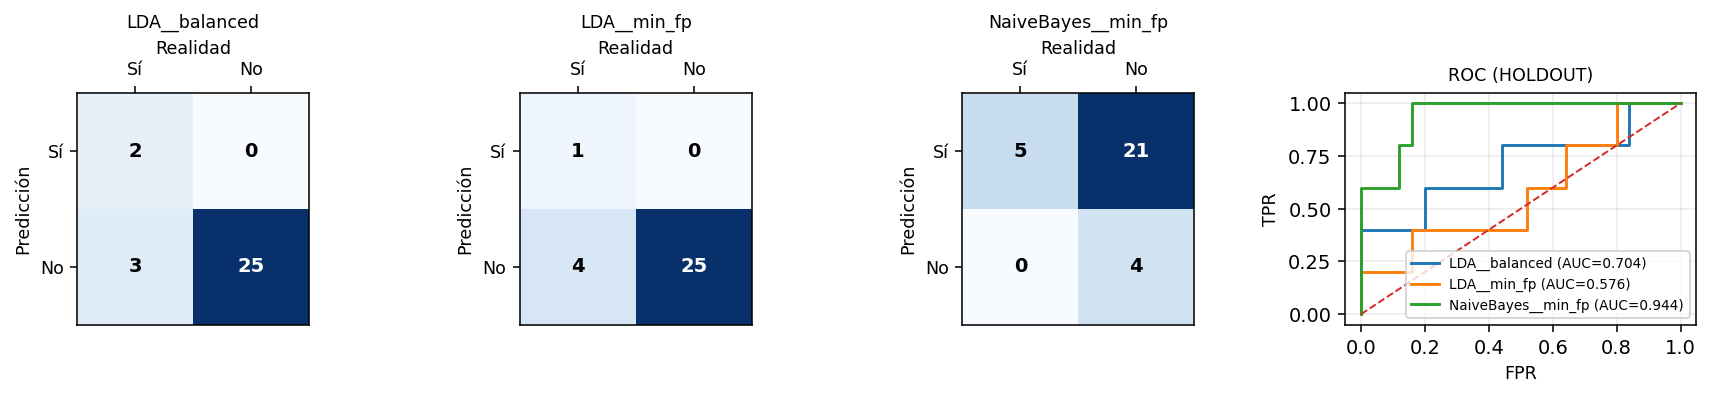

In [20]:
# ==============================
# REPORTE DE ESCENARIO — HOLDOUT
# ==============================

# ------------------------------------------------------------
# Reporting.plot_scenario_report(...):
#   - Genera el reporte del escenario "S3" evaluado sobre el conjunto HOLDOUT.
#   - Permite comparar S3 contra escenarios previos (S1/S2) bajo el mismo set_name,
#     destacando diferencias de rendimiento y comportamiento de error en datos no vistos.
#
#   - Parámetros:
#       * "S3"               → identificador del escenario (rotulado y trazabilidad).
#       * cfg                → configuración del reporte/experimento.
#       * RESULTS_HOLDOUT_DF  → resultados/predicciones del holdout usados para el reporte.
#       * y_test             → etiquetas reales para cálculo/validación de métricas.
#       * plt                → matplotlib.pyplot para renderizado de gráficos.
#       * scores_store       → estructura donde se guardan métricas del holdout por escenario.
#       * set_name="HOLDOUT" → etiqueta del conjunto evaluado (consistencia en reportes).
#
#   - Notas técnicas:
#       * Verificar que `RESULTS_HOLDOUT_DF` corresponda al escenario S3 o que el reporte
#         seleccione internamente la columna/modelo adecuado para S3.
#       * Alineación `RESULTS_HOLDOUT_DF` ↔ `y_test` es crítica para métricas correctas.
# ------------------------------------------------------------
Reporting.plot_scenario_report(
    "S3",
    cfg,
    RESULTS_HOLDOUT_DF,
    y_test,
    plt,
    scores_store=HOLDOUT_SCORES,
    set_name="HOLDOUT"
)


In [21]:
# ==============================
# ENTRENAMIENTO FULL Y Pdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABq4AAAGNCAYAAABg9oCBAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjgsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvwVt1zgAAAAlwSFlzAAAViAAAFYgBxNdAoAAA6CxJREFUeJzs3XmcjeX/x/H3ObOvzJixM/ZIStZE9p1S2beQtCiSVoSRLUWSJX0Tk0TKEilrtp89SakQ2RKDwYxZmO3cvz80J6dZjJkzc2bOvJ6Pxzycc93XfV+f+8xxPufM51z3ZTIMwxAAAAAAAAAAAADgYGZHBwAAAAAAAAAAAABIFK4AAAAAAAAAAACQR1C4AgAAAAAAAAAAQJ5A4QoAAAAAAAAAAAB5AoUrAAAAAAAAAAAA5AkUrgAAAAAAAAAAAJAnULgCAAAAAAAAAABAnkDhCgAAAAAAAAAAAHkChSsAAAAAAAAAAADkCRSuAAAAAAAAAAAAkCdQuAIAAAAAAAAAAECeQOEKAAAAAAAAAAAAeQKFKwAAAAAAAAAAAOQJFK4AKCwsTCaTSVu3brW2hYaGymQy6dSpUw6LCwCQWv/+/WUymex+3KZNm6pcuXJ2P64jnTp1SiaTSaGhoY4OBUABV65cOTVt2tSuxzSZTOrfv79dj1mQOWMezO/4TAoAQMFF4aoA2Lp1q0wmk+bOnZtun5Q3hCk/np6eKlasmBo3bqwxY8bozJkzGY7x66+/Wvc9evSovU8BAIAsIw8CAKTM5YO85v3339e8efPsesyUL62l/JjNZgUGBqpt27bavHmzXccCAAAAssLV0QEgb3nnnXdUokQJJSUl6dKlS9q9e7fefvttTZ06VbNmzdKTTz6Z5n5hYWEqUqSIEhMTFRYWpsmTJ+dy5AAAZB95EACQE44ePZql2bLvv/++ihcvrqeeeirVtuvXr8vFxSXLMb366qu69957lZSUpCNHjmju3Llq3bq1NmzYoObNm2f5uPnVhg0bZBiGo8MAAACAKFzhPx5++GFVrVrVpu3IkSNq166dBg0apPLly6tZs2Y225OSkvT555+rR48eun79uj777DNNnDhRZjMT+jIjOjpafn5+jg4DACDyIAAgZ3h4eNj9mJ6entnav3nz5mrbtq31/kMPPaSOHTvqvffec1jhypGfjdzd3R0ybn6QmJio5OTkbD/nAAAAMou/qOC2qlatqrCwMFksFo0bNy7V9nXr1ik8PFx9+/ZV37599ffff2vTpk05Fk/K2h4XL15Uz549VbhwYQUEBOjZZ59VQkKC4uLi9MILL6hYsWLy8fFR586ddfXqVZtj7N27V0888YQqVaokLy8vBQQEqH379tq/f79Nv5UrV8pkMmnEiBE27X/88Yd8fX3VvHlzWSyWO479woUL6tOnj4KCguTv72/dfubMGQ0cOFAlS5aUu7u7ypUrpxEjRujGjRupjvXbb7+pR48eKl68uDw8PBQSEqIBAwYoIiJCkmSxWDRhwgQ1bNhQwcHB8vDwUJUqVTRu3DglJiZmOmYAKOjyWh5Mcf78eXXt2lWFChWSv7+/evbsqfDwcJs+R44c0bPPPquqVavKx8dHfn5+atKkiTZu3JipMb744gt17NhRpUuXlru7u0qWLKknn3xSFy5csOl361pSK1as0H333ScPDw+VL19eH374YZrH/vbbb9W8eXMVKlRIPj4+ql69ukaPHm3TJy4uTmPHjtVdd90lDw8PBQcHq0+fPvrrr79SHe+XX35RixYt5O3traJFi2rw4MGKiYnJ1HkCwK2++OIL1a1bV97e3ipUqJDatWunffv2peoXExOjIUOGqGjRovLx8VGTJk20f//+NNdKSmuNq6+//loNGzZUQECAvL29VaFCBfXt21dRUVGSbq5hdfr0ae3du9fm0n4p0lvjauHChXrggQfk6+srPz8/1apVSzNnzrzteafEd/z48VTb1qxZo6ZNm8rPz0/e3t564IEH9M0339jlMfnhhx/UvHlz+fr66uGHH7Zu37Vrl9q3b6+AgAB5enrqvvvu0/z581ONebvHUZK2b9+uVq1aKTg4WJ6enipbtqy6dOlis3ZSemtcZeb5kJU8mF0pl74MCwvTRx99pCpVqsjDw0PVqlXTihUrUvVPSEjQW2+9Ze1XvHhxPfnkkzp37pxNv5RLSW7YsEGjR49WSEiIPD09tWfPHpsx33//fVWoUEFeXl5q2LChfvnlF+vjVaNGDXl6eqp69eqpLj8ZHR2tUaNGqU6dOgoMDJSnp6dq1KihWbNmMeMNAABYMeMKmdKkSROVK1dOO3bsUExMjHx9fa3bwsLCVLlyZdWvX1+GYahMmTIKCwtT69atczSmdu3aqWrVqpo8ebK2bdumjz76SN7e3jpy5IjMZrPGjh2rQ4cOae7cufLx8dHChQut+3799dc6efKkevfurdKlS+uvv/7SRx99pMaNG+vAgQPWb9s/9thjeuqpp/TOO++oTZs2atq0qRITE9W7d295eHho4cKFWfpGfevWrRUSEqK33nrLWmg6ceKEGjRoIDc3Nz399NMqWbKkfvjhB7377rv66aeftHbtWusH1Z07d6p169Zyc3PToEGDVLlyZZ07d06rV6/W2bNnFRQUpISEBL333nvq2rWrunXrJhcXF23YsEGhoaE6deqUFixYYIffAgAUDHk1D5YpU0aTJk3S4cOHNXfuXP3yyy/68ccfrd+I3rp1q/bs2aPOnTsrJCREly5d0rx589S2bVtt2rQp1eyx/5ozZ46KFi2qF154QYGBgfrpp580f/587d69WwcPHkw1g+Dbb7/Vxx9/rGeffVaFCxfWvHnzNHjwYFWrVs3mD7bTp0/X8OHDddddd2n48OEqXry4jh49qpUrV2r8+PGSbv6BrVWrVjp48KAGDhyoe+65R2fOnNHs2bO1detWHThwQEWLFpUk/fnnn2rcuLEk6eWXX1ZQUJCWLl2qJ554wl4PN4ACIuX16f7779eECRMUExOjuXPnqnHjxtq0aZMaNWokSTIMQ507d9aGDRvUo0cPPfTQQ/rtt9/UunVrFSlS5LbjbN68WY8//rgaNWqkcePGycvLS2fOnNGaNWsUGRmpQoUK6bPPPtNLL72kQoUKKTQ0NFPxDxs2TDNmzFDdunU1atQoFSpUSL/++qtWrVqlIUOGZLjvyZMnJUmBgYE27TNnztTQoUPVqlUrjR8/XiaTSUuWLFGnTp302WefqXfv3ll+TM6cOaPWrVurV69e6tGjh/Wz1ddff62uXbuqVq1aGjlypLy9vbV69WoNHDhQ4eHhGjlyZKYfx8OHD6tNmzaqUqWK3njjDRUuXFh///23Nm7cqDNnzqRZrEqR2edDiszmQXuaM2eOrl27poEDB8rd3V3vv/++unXrpiNHjqhSpUrWft26ddOqVavUqVMnvfjiizp27JjmzJmj77//XgcOHEj1O3r11VdlMpn0wgsvyN3dXSVKlND58+cl3XxOxMfH64UXXlBcXJymTJmidu3aaeLEiQoNDdWzzz4rd3d3vfPOO3rsscd0+vRpFS5cWJL0999/a8GCBerSpYsGDBigxMRErVixQkOGDNHly5c1duzYHHmcAABAPmPA6W3ZssWQZHz44Yfp9hk7dqwhyTh8+HC6fR555BFDkvHzzz9b2y5fvmy4u7sb48aNs7a98cYbhpeXlxEZGWmfE/iPfv36GZKMV155xaa9Tp06hslkMrp162bT3qVLF8PV1dW4du2atS02NjbVcY8ePWq4u7sbTz/9tE17TEyMUaVKFaN06dLGlStXjDfeeMOQZCxfvjzLsT/55JOptrVv394oXbq0ERERYdM+c+ZMQ5KxZs0awzAMIzk52bjrrrsMf39/48SJE6mOk5ycbBiGYVgsFiMuLi7V9v79+xtms9k4e/astW3BggWGJGPLli3WtpTnxMmTJ+/4PAEgL3HWPNi9e3eb9jlz5hiSjPfee8/alla+u3TpkhEcHGy0bt3apr1JkyZGSEiITVta+4eFhRmSjMWLF1vbTp48aUgyfHx8bPJLeHi44e7ubpObT506Zbi6uhr169dPdXyLxWK9/c477xguLi7Grl27bPr89NNPhouLi837gO7duxsmk8nYv3+/tS0hIcF44IEHDEnG2LFjU50HgILndvng8uXLhpeXl3HvvffavI8+ffq04ePjY9SsWdPatmbNGkOS8dJLL9kcY+7cuYakVK+nISEhRpMmTaz3hw0bZvj5+RmJiYkZxhwSEmLUr18/zW2SjH79+lnv79ixw5BkPProo6mOe+vra8p7/6VLlxqXLl0yzp8/b2zZssWoVauWIcn44IMPrH3Pnj1ruLu7G88995zN8ZKSkox69eoZxYsXN5KSkrL8mEgyFi5caNMeFxdnBAUFGR06dLCJ2zAMo3Pnzoanp6f1M1NmHsf333/fkGRcuHAh3T6GkToP3snz4U7yoL2kPJ9Lly5tREdHW9t/+uknQ5Lx2muvWdu+++47Q5Lx1FNP2Rxj2bJlhiRj2LBh1raU58fdd99tXL9+Pc0xQ0JCjJiYGGv7rFmzDElGoUKFjPDwcGt7ynNizpw51rb4+Pg0n5/Nmzc3/Pz8jPj4eGs7n0kBACi4uFQgMi3lWuPR0dHWtsWLFyshIUF9+vSxtvXt21fXr1/Xl19+maPxPPfcczb3GzZsKMMw9Oyzz6ZqT0pKsrkMhLe3t/V2TEyMLl++rMDAQN1111364YcfbPb38fHR559/rgsXLqhdu3Z65513NHDgQD3++ONZjv3FF1+0uR8ZGal169apc+fOMgxDERER1p+Ub+ynXHbq4MGDOnr0qJ577jmVL18+1bFTvqVoMpnk5eUl6eb6K1evXlVERIRatGghi8WiH3/8McvxA0BBlNfy4PDhw23uDxw4UIUKFbK5dNOt+S4uLk6XL1+WJNWrVy9VvktLyv4Wi0VRUVGKiIiwzmxKa//HHntMpUqVst4vVqyYqlatanPZqeXLlyspKUmhoaE28UmyuQTWkiVLdP/996ty5co2ebF06dKqXLmyNS8mJydbL2FVu3Zt6/5ubm6p8i0AZGTjxo26fv26hg0bZn0fLUlly5ZVr169dPDgQZ05c0aSrK+1L730ks0xnnzySRUqVOi2YxUuXFhxcXH69ttv7XZ5tKVLl0qSJk+eLFdX24ur3Pr6mqJ79+4KDg5WiRIl1KxZMx09elQTJ07UCy+8YO2zfPlyJSQk6IknnrB5Lb569ao6dOig8PBw/frrr5Ky9pgEBQVZZ2yl2LhxoyIiItSvXz9dvnzZZtwOHTroxo0b2rFjh6TMPY4pM31S8k9m3cnzIUVm8qC99e/f32YmeM2aNeXv728z5urVqyXJOlMtRefOnVWlShWtWrUq1XGfeeaZdNe0euKJJ+Tj42O937BhQ0lSp06dVKxYsVTtt8bi7u5ufX4mJCToypUrunz5slq2bKno6GgdOXIkcycOAACcGoUrZFrKH+puXSw3LCxMNWrUkMVi0fHjx3X8+HG5u7urcuXKCgsLy9F4QkJCbO6nfCApW7Zsmu1Xrlyxtp0/f179+vVTYGCg/Pz8FBQUpODgYB06dEiRkZGpxqpTp47eeOMN7d27V+XKldOMGTOyFfutl2yQbq6ZZbFYNGPGDAUHB9v83HXXXZKkixcvSpKOHTsmSbrvvvtuO86iRYt0//33y9PTU4GBgQoODlbfvn0lKc3zBACkL6/lwZTL2qZwd3dX+fLlrZd6kqRr165p6NChKlGihHx8fKz57ttvv81UHti3b59atWolHx8fFS5cWMHBwapQoYKktPNIWpdbCggIsMnBmc1jR44c0f79+1PlxeDgYB05csSaFy9duqTY2NhUj4ckVatW7bbnCAApUl4/77777lTbUtpS+pw6dUpeXl4qU6aMTT83N7c0v1z2X4MHD1b16tX16KOPqmjRourSpYvmz5+v2NjYLMd/7NgxeXp6Wj8/3M7kyZO1ceNGrVq1Ss8//7zi4uIUFxdnU+RKKSI0aNAg1WtxyiXdUl6Ps/KYlC9fPtWl11PG7NatW6oxn3zySZsxM/M49ujRQ82aNdPgwYNVpEgRdezYUbNnz7Z+mSM9d/J8SJGZPGhvmRnz5MmT8vLySvP3UK1aNZ0+fTpV4e+/n1lvlZ3P4oZh6P3331fVqlXl6empIkWKKDg42FpU43MqAACQWOMKd+CXX36Rq6ur9Q9Wv/76q3XWTuXKlVP1P3bsmI4dO5bmNntwcXG5o/aUN+IWi0Vt2rTRsWPHNHz4cNWqVUt+fn4ym80aNmxYmgu5JyUlaf369ZJufkgKDw9XxYoVsxz7f79hbrFYJEmDBg1St27d0tynePHidzTGV199pb59+6phw4b68MMPVapUKbm7u+vAgQN6/fXXrWMCADInr+XBzOjZs6fWrVun559/3rpwvdls1uTJk1Mtlv5fp0+fVrNmzRQUFKQJEyaocuXK8vb2VnJystq2bZtmHrldDr4TFotF9erV08SJE9Pc/t/1tQAgPwkODtaPP/6obdu2acOGDdqyZYsGDhyocePGaefOnSpdunSOx1CzZk21bNlSkvTII4/I19dXEydO1AMPPKCOHTtK+vdzyldffWUtQvzX/fffn+UY/vu56NYxZ82alW4RLuWLCZl5HD08PPT9999rz549WrdunbZu3aoXX3xRY8eO1caNG7MV/3/ZMw86esy0fje3GzMzsUydOlWvvfaaOnTooDfeeEPFihWTm5ubvvvuO02fPp3PqQAAQBKFK2TStm3bdOrUKTVr1sx6GYKwsDC5uLho4cKFcnd3t+mfcjmJTz/9VBMmTHBEyOk6dOiQDh06pNDQ0FQLv169elVubm6p9gkNDdW+ffv0zjvvaOLEierdu7d27NiR6hIcWVWpUiWZTCZZLBbrh8f0pPwB9Oeff1bPnj3T7bd48WJ5enpq06ZNNpd4OHHihF1iBoCCJC/mwSNHjqhevXo2Y548eVK1atWSdPMby2vXrlW/fv30wQcf2Ow7ZsyY2x7/66+/VlxcnBYuXKgmTZpY2//4449sxX1rHitRokSG/VIuHZSR4OBg+fj4pHlpocOHD2crVgAFS8pslN9//13169e32ZbyepLy5YVy5cpp/fr1+uuvv2xmGCUmJurkyZPpFnlu5erqqhYtWqhFixaSpLVr16p9+/aaOXOmpkyZIintS/ylp3Llylq3bp2OHj2a5izU2xk9erQWLFigV199Ve3bt5fZbLa+ZhcvXlyNGjXKcH97PCYp5yFJhQoVum0OkDL/ODZo0EANGjSQdPPLKLVr19bbb79tvcTif93J8yGvK1++vNavX6+TJ0+mmnV1+PBhlStX7o6ea9mxePFilS9fXt98843NmLf7Qg0AAChYuFQgbuvo0aPq37+/zGaztdCTlJSkzz//XI0aNVKvXr3UpUsXm59evXrpwQcf1GeffZbnvjGV8i2w/8a1aNEinTt3LlX/HTt26O2339YTTzyhV199VR9++KH27t2rt956y24xBQUFqXXr1vr888+t14i/VXx8vKKioiTd/GZklSpV9OGHH+r06dOp+qZ8m83FxUUmk0nJycnWbTdu3NDMmTPtFjcAFAR5NQ++9957Nvc/+eQTRUVFWb8ln16++7//+z/t2bPntsdPb/933303yzFLN9fTcHV11bhx43T9+nWbbbd+I7t37976888/NW/evDSPc+nSJWucHTp00NatW23Wb0xMTMz2pX0BFCytWrWSl5eXZsyYoRs3bljbz549q88//1z333+/tSCT8lo7ffp0m2PMnz/f+r49IxEREanaUmb+3HoJO19fX129ejVT8Xfv3l2S9Oabb9p8BpAyN/vGx8dHw4YN05EjR6zFnK5du8rd3V1jxoxRQkJCqn1SLtknZf8xSdGmTRsVKVJEEydOtFlXMkVERIQ1N2XmcUzrkoDVqlWTl5dXhpcLvJPnQ17XqVMnSbIW8lKsXLlSf/zxh3V7bkjr/cXly5c1f/78XIsBAADkfcy4KkDWrl2b5hv7W9eY+Oabb7R//34lJSUpIiJCu3fv1jfffCNXV1fNnz/f+o3rdevWKTw8XCNGjEh3vMcee0zDhw/X5s2bM/VNudxStWpV3XXXXXrnnXd048YNVaxYUfv379fy5ctVoUIFmw95UVFR6tOnj8qWLatZs2ZJunnZpbVr12rSpElq27atHnzwQbvENXfuXDVs2FD16tXTgAEDVKNGDcXFxemPP/7QsmXLtGjRIrVt21Zms1nz5s1TmzZtVLNmTQ0aNEiVK1dWeHi4Vq1apXnz5qlmzZp69NFHtXz5crVs2VJ9+/ZVdHS0Pv30U5uFhQGgIHG2PHjkyBE9/PDDateunX7//XfNnTtXd911l5577jlJN9fiat68uRYtWiRfX1/VrFlThw8f1ieffKLq1aun+UWJW7Vt21aenp564oknNGTIEHl7e2vNmjXWglFWhYSEaPLkyXr11VdVu3Zt9ezZU8WKFdPx48e1du1aHTp0SJI0fPhwrV+/XoMGDdK6devUqFEjubu76+TJk1q9erUee+wxvf3225KkCRMmaN26dWrZsqVeeOEFBQcH64svvlB8fHy2YgXgnDLKBxMnTtTw4cPVsGFD9enTR7Gxsfrwww+VlJRkM3u1Q4cOatGihaZPn67w8HA99NBD+u2337RkyRJVqlRJSUlJGcYwaNAgnT9/Xi1btlRISIiuXbumsLAwmc1m9erVy9qvfv36+uSTT/Tmm2+qevXqMplM6tGjR5rHbNiwoV544QXNmjVLDRs21GOPPaZChQrp999/1+HDh7Vx48bbPjbPP/+8pkyZookTJ6pHjx4qW7asZsyYocGDB+vee+9Vr169VLJkSZ07d0579+7Vzz//rLNnz9rlMUnh6+urBQsWqEuXLqpWrZr69++vcuXK6eLFizp48KBWrVqlqKgoeXp6ZupxHD9+vDZt2qSOHTuqfPnySkhI0BdffKHo6Gj16dMn3TgCAwMz/XzI69q2batOnTrpo48+0sWLF9WyZUsdP35cs2fPVtmyZTVq1Khci+XRRx/V6NGj1bFjRz366KO6ePGi/ve//6lUqVK6cOFCrsUBAADyOANOb8uWLYakdH/69etnjB071qbN3d3dCA4ONh566CFjzJgxxunTp22O2blzZ0OScebMmXTHPXnypCHJ6N27t13Pp1+/fkZaT92Uczh58qRN+4IFCwxJxpYtW6xtx48fNx5++GEjICDA8PX1NVq2bGn89NNPRpMmTYyQkBBrv169ehkuLi7Gzp07bY557do1o0KFCkb58uWNqKiobMeeIjw83BgyZIhRvnx5w93d3ShSpIhRp04dY8yYMcbFixdt+v7888/G448/bgQGBhru7u5GSEiI8eSTTxoRERHWPh988IFRuXJlw8PDwyhXrpwxbtw4Y+PGjYYkY8GCBRk+Ruk9ngCQ3zhrHjx37pzRpUsXw9/f3/Dz8zO6detmnDt3zqbvhQsXjD59+hjBwcGGt7e30aBBA2PTpk1p5qP/5kDDMIxNmzYZ9erVM7y9vY2goCCjX79+xsWLF62P23/PdezYsaniTeu4hmEYK1euNBo1amT4+PgYPj4+RvXq1VPtHx8fb7zzzjvGfffdZ3h6ehp+fn5GtWrVjMGDBxu//PKLTd+ffvrJaNasmeHp6WkEBQUZzz77rHHo0KF04wJQ8GQmHxiGYSxevNioXbu29XWnTZs2xp49e1Id79q1a8bgwYONoKAgw8vLy2jcuLGxf/9+o3bt2ka1atVs+oaEhBhNmjSx3l++fLnRoUMHo2TJkoa7u7tRrFgxo23btjbvxw3DMM6fP2906tTJKFSokDXOFP99LU4xb948o3bt2oaXl5fh5+dn1KpVy5g1a5Z1e8p7/7Vr16b5OI0cOdKQZHz55ZfWts2bNxvt27c3AgICDHd3d6NMmTJGx44djUWLFtntMfmvAwcOGF27djWKFi1quLm5GSVLljRatmxpzJw500hOTs7047h582ajS5cuRpkyZQwPDw+jSJEiRuPGjY0VK1bYjJdevsrM8yEreTC7Up7Pt36uS5HWYxsfH2+EhoYaFStWNNzc3IyiRYsa/fv3N/7++2+bfml9NrzdmBmd/3+fp4mJicaYMWOMkJAQw8PDw6hataoxc+ZMPpMCAAAbJsPIwVVCAQAAAAAoIJKTkxUcHKy6detq/fr1jg4nT+AxAQAAwJ1ijSsAAAAAAO7Qf9fpk6R58+bp6tWratWqlQMicjweEwAAANgDM66Q45KTk2+7HkZCQoLc3d0z7OPi4qLg4GB7hmYXCQkJunLlSoZ98mrsAICc5+x5EAAKqqFDh+rkyZNq3LixfHx8tGfPHi1atEjly5fXTz/9JH9/f0eHmOt4TDJ25coVJSQkZNgnMTFRbm5uGfYJDAy87fsGAACA/IzCFXLcqVOnVL58+WwfJyQkRKdOncp+QHa2detWNWvWLMM+eTV2AEDOc/Y8CAAF1cqVKzV16lQdOXJE165dU9GiRdWuXTuNHz9eJUqUcHR4DsFjkrGmTZtq27ZtGfYJCQnR6dOnM+yzZcsWNW3a1I6RAQAA5C0UrpDjbty4oR07dmTY5+rVqwoICMiwj5eXlxo2bGjP0Ozi6tWr+vHHHzPsk1djBwDkPGfPgwAAIHN+/PFHXb16NcM+Xl5eaV5y8Va1a9e+7fsGAACA/IzCFQAAAAAAAAAAAPIEs6MDAAAAAAAAAAAAACQKVwAAAAAAAAAAAMgjKFwBAAAAAAAAAAAgT6BwBQAAAAAAAAAAgDyBwhUAAAAAAAAAAADyBApXAAAAAAAAAAAAyBMoXKHA2bp1q0wmk8LCwqxtYWFhMplM2rp16233P3XqlEwmk0JDQ+0aV04dFwBQsJDnAADOjlwHAADg3ChcIdelfMhI+TGbzSpUqJAaN26sZcuWOTo8AACyhTwHAHB25DoAAADkJFdHB4CCa8CAAWrevLksFotOnjypuXPnqmvXrgoLC1O/fv1yNZa+ffuqR48ecnd3z9VxAQDOizwHAHB25DoAAADkBApXcJh69eqpT58+1vtdunTRPffco3fffTfXP+S4uLjIxcUlV8cEADg38hwAwNmR6wAAAJATuFQg8ozq1asrKChIx48ft2nftWuX2rdvr4CAAHl6euq+++7T/PnzU+0/Z84ctWjRQiVKlJC7u7vKlSunYcOGKTo6+rZjp3c99F9++UUtWrSQt7e3ihYtqsGDBysmJibV/tHR0Ro1apTq1KmjwMBAeXp6qkaNGpo1a5YMw0jVP7PHBQA4D/IceQ4AnB25jlwHAABgD8y4Qp4RGRmpq1evqmjRota2r7/+Wl27dlWtWrU0cuRIeXt7a/Xq1Ro4cKDCw8M1cuRIa99p06apYcOGateunXx8fLRz507NnDlTP//8s7Zs2XLH8fz5559q3LixJOnll19WUFCQli5dqieeeCJV37///lsLFixQly5dNGDAACUmJmrFihUaMmSILl++rLFjx2bpuAAA50GeI88BgLMj15HrAAAA7MIActmWLVsMScbUqVONS5cuGRcuXDD27NljtGrVypBkDB8+3DAMw4iLizOCgoKMDh06GBaLxeYYnTt3Njw9PY2IiAhrW2xsbKqxQkNDDUnGrl27Uo2/YMECa9uCBQsMScaWLVusbd27dzdMJpOxf/9+a1tCQoLxwAMPGJKMsWPHWtvj4+ONxMREm7EtFovRvHlzw8/Pz4iPj8/ScQEA+Q95jjwHAM6OXEeuAwAAyElcKhAO88orryg4OFjFihXTAw88oC1btuill17S22+/LUnauHGjIiIi1K9fP12+fFkRERHWnw4dOujGjRvasWOH9Xje3t6SpOTkZEVGRioiIkLNmjWTJP3www93FFtycrLWrFmjpk2bqnbt2tZ2Nzc3vfjii6n6u7u7y9X15gTGhIQEXblyRZcvX1bLli0VHR2tI0eOZOm4AID8izxHngMAZ0euI9cBAADkBC4VCId58cUX1bFjR8XHx2v37t165513FBERYf2wkPLBoFu3buke4+LFi9bb69ev17hx47R//34lJiba9IuMjLyj2C5duqTY2FhVrVo11bZq1aqlajMMQzNmzNDcuXP1xx9/pLoGesr4d3pcAED+RZ67/XEBAPkbue72xwUAAMCdo3AFh6latapatmwpSerQoYNKly6t5557TvXq1dMLL7wgi8UiSZo1a5buuuuuNI+R8sFgz5496tChg6pVq6bp06crJCREnp6e+vvvv9W/f3/rsXLK1KlT9dprr6lDhw564403VKxYMbm5uem7777T9OnTc3x8AEDeQ54DADg7ch0AAAByAoUr5BlPP/205syZo9DQUPXr10+VK1eWJBUqVMj6YSg9S5cutV6yISQkxNq+YcOGLMUSHBwsHx8f6zcEb3X48OFUbYsXL1b58uX1zTffyGQyWds3b96creMCAJwHeY48BwDOjlxHrgMAALAH1rhCnmE2mzVixAhdvnxZs2bNUps2bVSkSBFNnDhR0dHRqfpHRERYv/Xm4uIiSTbfgrNYLJo2bVqWYnFxcVGHDh20detW/fjjj9b2xMREzZgxI83+/x3/8uXLmj9/fraOCwBwHuQ58hwAODtyHbkOAADAHihcIU/p1q2bKlWqpPfee08mk0kLFizQiRMnVK1aNb355puaN2+eJk2apG7duqlUqVJKSEiQJHXq1Ekmk0kdOnTQjBkzNH36dDVs2FARERFZjmXChAny8/NTy5YtNXr0aH3wwQdq0qSJ4uPjU/V99NFHdfLkSXXs2FEfffSRxo8fr5o1a6pUqVLZOi4AwLmQ5wAAzo5cBwAAgOyicIU8xcXFRa+99poiIiI0Z84cPfzww9qzZ48efPBBffzxxxo8eLBmz56tq1evatq0aXJ3d5ckPfTQQ1qyZIlcXV31xhtvaOrUqapfv74WLlyY5VgqV66sbdu26f7779fUqVM1fvx43XfffWke84033tCYMWN0+PBhvfjii1q8eLFef/11DRkyJFvHBQA4F/IcAMDZkesAAACQXSbDMAxHBwEAAAAAAAAAAAAw4woAAAAAAAAAAAB5AoUrAAAAAAAAAAAA5AkUrgAAAAAAAAAAAJAnULgCAAAAAAAAAABAnkDhCgAAAAAAAAAAAHkChSvckQMHDig0NFTHjx93dCgAAOQIch0AwJmR5wAAAJDXUbhCpkVHR6tLly46dOiQKlas6OhwAACwO3IdAMCZkecAAACQH1C4gv744w/1799flStXlpeXl4KCgnTfffdp8ODBOnLkiLXf0KFD5ePjo08//VQmk8mBEeNWW7dulclkkslk0ooVK9LdPnfuXAdEBwB5A7kufyPXAUDGyHP5G3kOAADAlqujA4Bj7du3T02bNpWfn5/69eunypUrKzIyUocPH9aKFStUr149Va1aVStWrNCqVav0ww8/yNfX19FhIx2jR4/Wo48+KrOZmjQApCDXORdyHQDYIs85F/IcAAAAhasC76233pJhGNq7d6/KlStnsy0pKUlRUVGSpMcff1yPP/64AyJEZtWuXVs//vijFi1apCeeeMLR4QBAnkGucx7kOgBIjTznPMhzAAAAN/EVngLu+PHjqlixYqoPOJLk6uqqIkWKSPr30gRhYWG5GyAyrX///qpUqZJCQ0OVmJiYYd9r165p+PDhCgkJkbu7u8qWLathw4ZZP9QCgDMh1zkPch0ApEaecx7kOQAAgJsoXBVwFSpU0B9//KFt27Y5OhRkk6urq8aNG6eTJ0/q448/TrdfQkKCWrZsqenTp6tZs2Z6//331apVK33wwQdq3ry54uPjczFqAMh55DrnQa4DgNTIc86DPAcAAHAThasCbtSoUZKkpk2b6t5779XgwYMVFhams2fPOjgyZEWPHj1Uo0YNTZgwQdevX0+zzyeffKIffvhBEyZMUFhYmAYPHqxPPvlE7777rg4cOMCCvwCcDrnOuZDrAMAWec65kOcAIH/ZtWuXXFxcdOjQIUeHUiAkJSWpYsWKGjt2rKNDQQ6jcFXANWzYUPv27VPv3r117tw5ffjhhxowYIBCQkLUt29fxcbGOjpE3AGz2azx48fr/PnzmjlzZpp9Vq9eLU9PT7300ks27S+88IL8/Py0atWq3AgVAHINuc65kOsAwBZ5zrmQ5wAUVCmXtE35MZvNKlSokBo3bqxly5alu19SUpLmzp2rRo0aqXDhwvLy8lLlypU1dOjQDL/EER8fr9mzZ6tx48YKDAyUm5ubSpQooU6dOmnZsmUyDCNTcb/yyivq3LmzatSoYW0LCwuTyWTSunXr0twno+1XrlzRqFGjdM8998jHx0d+fn6qXbu23n77bcXFxd3RsW7Vv39/m8fXy8tLJUuWVMuWLTVlyhRdunQp3X3j4uI0ZcoU1alTR/7+/vL29tY999yjUaNG6cqVK6n6h4aGymQy6ciRI2keb+7cuTKZTNq6dWuq33tGP6GhoXJ1ddWIESM0bdo0hYeHZ3jOyN9cHR0AHK9mzZpatGiRpJvXR9+yZYtmz56tRYsWydPTM8NLFCDv6dSpk+rXr68pU6bo2WefTbX95MmTKleunLy9vW3aPTw8VKFCBZ08eTK3QgWAXEOucy7kOgCwRZ5zLuQ5AAXZgAED1Lx5c1ksFp08eVJz585V165dFRYWpn79+tn0jYqKUseOHbVjxw41btxYY8eOlZ+fnw4cOKCPP/5YCxcu1KpVq9SkSROb/c6fP6/27dvr4MGDaty4sd544w0FBQXpwoUL+u6779S1a1fNnj1bgwcPzjDWLVu2aPfu3fq///s/u5z7oUOH1LZtW124cEHdu3fXkCFDlJSUpA0bNmjEiBFatGiR1q9fr1KlSmV5jPnz58vNzU0JCQkKDw/X9u3bNWLECE2ZMkWLFi1S+/btbfr/9ddfatOmjQ4fPqyHH35Y/fv3l5ubm3bs2KEpU6bo008/1fr161W9evUsxVOtWjV99tlnNm2zZ8/Wnj17UrXfe++9kqS+ffvq1Vdf1YwZMzR58uQsjYu8j8IVbFSqVEmVKlVS3759Vb16dX322Wf68MMPHR0W7tDEiRPVsmVLTZs2Tc2aNXN0OACQp5DrnAO5DgDSRp5zDuQ5AAVVvXr11KdPH+v9Ll266J577tG7776bqnD11FNPaceOHZowYYL10rkpnnvuOTVt2lSPP/64Dh06pJIlS0qSDMNQly5ddPDgQX388cd66qmnbPYbMWKENm3apMuXL9821o8++kjlypVTw4YNs3q6VjExMXrkkUd0+fJlrV+/Xi1atLBue/7557Vo0SL17dtXXbt21Y4dO2Q2Z+1Caj179pSnp6f1/siRI7V792516NBBXbp00YEDB1S1alVJksViUZcuXXT48GF99tlnNr+XZ555RgMGDFD79u3VqVMn/fzzz/Lx8bnjeIoVK2ZzXElas2aN9uzZk6o9hYeHhzp37qywsDCNHz9erq6UOJwRlwpEmjw9PVWzZk3Fx8crIiLC0eHgDrVo0ULNmzfX9OnTU/3+ypcvr9OnT6eaXhwfH68TJ06oQoUKuRkqADgMuS5/I9cBQMbIc/kbeQ4AbqpevbqCgoJ0/Phxm/YDBw5o2bJlatiwYaqilSTVqFFDkydP1pUrV/TOO+9Y21etWqVdu3apT58+qYpWKVq2bKnu3btnGFdiYqK++eYbtWnTRiaTKQtnZuvjjz/WqVOn9PLLL9sUrVL06dNHPXv21O7du7V69epsj3erBg0aaPr06bp+/brefvtta/uqVau0b98+9erVK80iUvPmzTV8+HD9+eefuT67u23btgoPD9eOHTtydVzkHgpXBdzGjRuVnJycqj0iIkK7du1SkSJFFBwc7IDIkF2TJk1SdHS0TcKRbl524vr16/rggw9s2ufMmaPo6Gh16tQpN8MEgBxHrnNe5DoAIM85M/IcAEiRkZG6evWqAgMDbdpXrlwpSXryySfT3bdv375yd3e39pWkFStWSJIGDhyYrbh+/PFHxcXFqW7duun2uXbtmiIiIlL9xMTEpOqbmbhStt16PvbSs2dPeXh42KyV5eiYMlK/fn1J0vbt23N1XOQe5tEVcC+99JKuXLmiTp06qUaNGvLw8NDJkye1cOFChYeH66OPPpKLi4ujw0QW1K9fX4888kiqb2E8+eSTmj9/vkaMGKGjR4+qXr16OnDggD755BPVqlVLzzzzjIMiBoCcQa5zXuQ6ACDPOTPyHICCKDY2VhEREdY1rkaPHq3k5GT17NnTpt9vv/0mSbr//vvTPZaXl5fuuusuHTp0SDExMfL19bXud99992UrzsOHD0tShrNcbzdr61a//fab/P39MzxeyrmmnIM9ubu766677tIvv/yia9euyd/fP1OPccWKFeXn55cjMWWkTJkycnNz0++//56r4yL3ULgq4KZNm6aVK1dqx44dWrp0qaKjo1WkSBHVrVtXH3/8sdq0aePoEJENEyZM0Jo1a2SxWKxt7u7u2rRpk0JDQ7Vs2TJ9/vnnKlasmIYMGaK33npLHh4eDowYAOyPXOfcyHUACjrynHMjzwEoaF555RW98sor1vuurq566aWXUs0+vXbtmiTJ398/w+OlbI+KipKvr2+m97udS5cuSZICAgLS7TN58mTVqVMnVfuGDRv07rvv2rRdu3ZNJUqUyHDMW88lJ/j5+UmSoqOj5e/vf0eP8YULF3IkpowEBgZafw9wPhSuCrg2bdpk6oNM06ZNZRhGLkSEO5XR76ZGjRppXjbE399f7733nt57772cDg8AHI5cl/+R6wAgfeS5/I88BwD/evHFF9WxY0fFx8dr9+7deueddxQRESFXV9s/Y6cUU1KKK+n5b/El5d/o6GgVLlw42/FmlFtr1qypli1bpmo/e/ZsqrZbC0XpsVfRLT3R0dGS/i1g3foYZ1SgS5mhdaeyuzaYxWKxy/piyJtY4woAAAAAAAAA4HBVq1ZVy5Yt1aFDB02YMEEffPCBPvvsM82ePdumX/Xq1SVJBw8eTPdY169f19GjR1W2bFlrMebuu+++7X6ZkbJ+5NWrV7N1nBTVq1fXtWvXdPLkyXT7pMR8zz332GXMWyUkJOjo0aMqVqyYtQiVmcf4xIkTio6OtonJ09NTkhQXF5fmPrGxsZJuXsoxO65evaqgoKBsHQN5F4UrAAAAAAAAAECe8/TTT6tGjRoKDQ21zgiSpEcffVSStGDBgnT3/fzzz5WQkKDHHnvM2vb4449LkubPn5+tuKpVqyZJOn78eLaOkyLlfDKKK2XbredjL0uWLFF8fLzat2+f7ZjKly8vSTpy5Eia+6SsD1auXLksx3vmzBklJSVZi2twPhSuAAAAAAAAAAB5jtls1ogRI3T58mXNmjXL2l67dm099thj+r//+79U619J0m+//aY33nhDgYGBevXVV63tnTp1UoMGDbRo0SKFhYWlOeb333+vpUuXZhhX7dq15eXlpX379mXtxP5j0KBBKlu2rKZOnaqtW7em2r5kyRItXrxYDRo00COPPGKXMVPs2bNHL730kry9vfXGG29Y2x999FHVqVNHn3/+uZYsWZJqv23btmnq1KmqWLGiBg0aZG1v1aqVvLy89OGHHyo+Pt5mnzNnzmjZsmWqX7++ihYtmuWY9+7dK0lq3Lhxlo+BvI01rgAAAAAAAAAAeVK3bt00ZswYvffeexo6dKh8fHwkSZ988onCw8M1YsQIrV+/Xp06dZKvr69++uknLViwQO7u7lq1apVKlSplPZbZbNby5cvVvn17DRgwQJ9++qnat2+voKAgXbx4UevWrdPWrVs1Z86cDGNyc3PTI488ovXr18swjGyvteTv769Vq1apXbt2atmypXr27KlGjRopOTlZGzdu1Ndff627775bX331lczm1HNRlixZov3796dqb9y4sU1xZ8mSJXJzc1NiYqLCw8O1fft2bdiwQYULF9by5ctVpUoVa18XFxctX75crVu3Vq9evbR06VK1bt1arq6u2rlzpz7//HMVL15cq1atsv5OJCkwMFBTpkzR0KFDVatWLXXv3l3FixfXn3/+qY8//liJiYmaMWNGth6vdevWqXjx4mrYsGG2joO8i8IVAAAAAAAAACBPcnFx0Wuvvaann35ac+bMsc6gCggI0LZt2/Txxx9r0aJFGjt2rOLj41W6dGkNHDhQr7/+ukqXLp3qeCVKlNCePXs0b948ffHFF5o0aZJiYmIUFBSk+vXra+XKlerUqdNt43rmmWe0dOlSbd++XU2aNMn2edasWVOHDh3StGnTtHr1ai1fvlxms1lVqlTR5MmTNXToUHl7e6e578KFC9NsHzt2rE3h6sknn5QkeXh4KCAgQNWrV9fkyZP15JNPprleVNmyZbV//37NnDlTX331lV577TVZLBaVL19er732ml555RUFBgam2m/IkCEqX768ZsyYoenTpysmJkbBwcFq27atRo0ala1L/MXHx2v58uV67rnn5OpKecNZmQzDMBwdBAAAAAAAAAAA+cmDDz6okiVLatmyZY4OpcCYN2+ehg0bpuPHj6t48eKODgc5hMIVAAAAAAAAAAB3aOfOnWrcuLEOHjyoGjVqODocp5eUlKS77rpLffr00bhx4xwdDnIQhSsAAAAAAAAAAADkCalXcgMAAAAAAAAAAAAcgMIVAAAAAAAAAAAA8gQKV0hTgwYN1KBBA0eHATvh9wkAqfHa6Fz4fQKALV4XnQu/TwAAUJBQuAIAAAAAAAAAAECeQOEKAAAAAAAAAAAAeQKFKwAAAAAAAAAAAOQJFK4AAAAAAAAAAACQJ1C4AgAAAAAAAAAAQJ5gMgzDcHQQ+UnVqlV19epVVahQwdGh5Khff/1VknTPPfc4OBLYQ0H5fZ44cUIBAQE6cuSIo0MB8jVyHfKjgvL7JNcB2UeeQ35UUH6f5DnklILy2g8AeUl28rprDsTj1K5evaqY2FjFJ1kcHUqOqlz1bkly+vOUJFezydEh5Lhqd1eXJCVbnLtOHRsb5+gQAKdw9epVxcbGKSHZuV8zqlS7+dro7OcpFYxcd3f1m3/Ic/JUp9g4ch2QXeQ55+NSAPJctX/ynLP/OslzyClXr15VXDaeX8nJyZIkFxcXe4WUr3D+nL/E+XP+d37+2XndpXB1hypUqKD4JItWrN3m6FBgJ4W93RwdAuykdbOGBeJDK5DTKlSooIRkQ99s2O7oUGAn5Drn0azxgyLVAdlDnnM+/l78acNZNG/SUC7kOeSAlJlWu3fvztL+kZGRkqTChQvbKaL8hfOPlMT5c/6FHRqHo2Tn/Bs0aJDlcVnjCgAAAAAAAAAAAHkChSsAAAAAAAAAAADkCRSuAAAAAAAAAEiSFi1apGeeeUZ16tSRh4eHTCaTwsLC7vg4FotFM2fOVI0aNeTl5aXg4GD17NlTJ06cSHef9evXq0mTJvLz85O/v7+aNWum77//PhtnAwDIjyhcAQAAAAAAAJAkvfnmm/rf//6n06dPq0SJElk+zjPPPKOhQ4fKMAwNHTpUbdu21YoVK1S3bl0dO3YsVf9Fixapbdu2Onz4sPr3769+/frpt99+U6tWrbRs2bLsnBIAIJ+hcAUAAAAAAABAkjRv3jydOnVKly5d0rPPPpulY2zZskXz5s1T48aNdeDAAU2ZMkWfffaZvv76a125ckUvvPCCTf+rV69qyJAhCgoK0oEDBzRz5kzNnDlTBw4cUJEiRfTcc88pOjraHqcHAMgHKFwBAAAAAAAAkCS1bNlSISEh2TrGxx9/LEkaP3683N3dre3t2rVT06ZNtWHDBp05c8ba/tVXXykyMlJDhgxR6dKlre2lS5fWCy+8oIiICK1cuTJbMQEA8g8KVwAAAAAAAADsZuvWrfLx8VHDhg1TbWvTpo0kadu2bTb9Jal169aZ6g8AcG6ujg4AAAAAAAAAgHOIjY3V+fPndc8998jFxSXV9sqVK0uSzTpXKbdTtt2uf3oaNGiQZvuvv/6qatWqKTIy8rbHSEtBv0wh58/5F2TOdP5jt3+mzRFL5GKKlZuSb9v/7lOG/g6SonxN8jAMrXl85x2Nl5ycnGYeyAwKVwAAAAAAAADsIioqSpJUqFChNLf7+/vb9LvdPmn1BwDcuc0RSySXaCVLSpYpw76uSYaeWmvRn8VNmva4SbpNf3ujcAUAAAAAAAAg39u9e3ea7SkzsQoXLpyt42d3//yO8y/s6BAcivMv7OgQss0w3bCWn7wslptt/ylImS2GLGaTZJYWtDGraKQhT4shD935Y5DV2VYShSsAAAAAAAAAdpIyayq9GVLXrl2z6ffffYoUKXLb/gCArPO0GNp3+qzk5i2NOi9JSo6K0oW3p8hISFCpaVOtfSMjI/WGcr9wZ87V0QAAAAAAAAA4LR8fH5UoUUInT55UcnLqNVTSWs8qo3WsMlr/CgCQfdGbt+hEx4cVtXKlYrZuVeL5844OiRlXAAAAAAAAAOynSZMm+uKLL7Rz5041btzYZtv69eslyaa9SZMmWrJkiTZs2KAHHnggzf5NmjTJ4agBwE72z5e2TNaXbkma4++lWFPemD9kMt+8LKBJhiQpOd6k8Nde07XV30iSfB56SCXeGie3EiUcFmOKvPGIAQAAAAAAAMhXIiIidOTIEUVERNi0P/3005Kk0aNHKyEhwdq+du1abd26Va1bt1ZISIi1vVu3bipUqJBmzpyps2fPWtvPnj2rWbNmKSgoSI899lgOnw0A2MmWyVLsRc3x89JlFxfdMJvyxE8Kb4uh6HMe+vMbf11b/Y3M/v4qMWmSyvzvozxRtJKYcQUAAAAAAADgH/PmzdOOHTskSYcOHbK2bd26VZLUqFEjPfXUU5KkWbNmady4cRo7dqxCQ0Otx2jWrJmeeuopzZs3T7Vq1VKHDh10/vx5LV26VIGBgZo5c6bNmAEBAZo1a5b69u2rWrVqqXv37pKkpUuX6vLly1q6dKn8/Pxy+MwBwE4SYiRJcbcUizwthqOiseFtsei5qDgZroWVfN0k32bNVDw0VG7Fijo6NBsUrgAAAAAAAABIknbs2KFPP/3Upm3nzp3auXOn9X5K4SojH330kWrUqKH//e9/mjFjhnx9ffXYY49p4sSJqlixYqr+ffr0UVBQkCZNmqQFCxbIZDKpdu3aevPNN9WyZcvsnxgA5LqbhSvD4qaYE5N0eHxbh0ViGIZu/PqbvGrcY21z2bdP3nXrymQyZbCnY1C4AgAAAAAAACBJCgsLU1hYWKb6hoaG2sy0upXZbNbQoUM1dOjQTI/dtm1btW3ruD/sAoAzSoqIUPi4txS9caPKzv9EPg8+KEnyqVfPwZGlj8IVAAAAAAAAAAAoML48+qXmHJyjuKS4DPslJluUlGzIRUlyU3Kmjm0qGSgpUNfNjp3JZBiGrq1ZowsTJio5KkouAQGyxMc7NKbMonAFAAAAAAAAAAAKjDkH5+jyjcuZ62yWkiUlK7OFKNt+hsVDPh65W4pJvHBR4aGhitmyRZLk376dir35plwDA3M1jqyicAUAAAAAAAAAAAqMW2daebl6pd8vIelmHyXIJEOSZGSygJUoVyVZvOR+rZ2Gt6qSjWjvTMKZMzrZuYss0dFyCQpS8bFj5N+qVa6Nbw8UrgAAAAAAAAAAQIHj5eqlfb33pbu96ui1upFo0T6PAfI2xUtu3tKo87kY4Z1zK1NGXvfdJ5fAABUbMUKuAQGODumOUbgCAAAAAAAAAADIhwzDUOSXX8mjSmV533+/TCaTSs+ZLbO7u6NDyzIKVwAAAAAAAAAAIE/78uiXmnNwjs1l/u5EUrJFicmGDBkymRMlSQkJ8bo0tqx8dCPNfQ6YJXno5myrPCjh7N86P/pNxe3eI/fy5VVh9SqZ3NzyddFKonAFAAAAAAAAAADyuDkH5+jyjcvZO4hZNitU+VuSFGyKyvz+7r7ZG99ODItFV5cs0cVp78mIi5Nr8eIqNnKETG5ujg7NLihcAQAAAAAAAACAPO3WmVZerl53vn9Ckm2DxUPPXD3373bDI839TCbJzcUsV08/qdnIOx7X3hLOnNH5UW8q7ocfJEmFu3VT0ddelYtv3iiq2QOFKwAAAAAAAAAAkC94uXppX+99d7xftdHrdD0xWV5uLjo8vu3Nxoklbv7r5i3vUedT7RMZGXlzzMKFsxit/YW/NV5xP/wgt1KlVGLCePk0aODokOyOwhUAAAAAAAAAAEAeZVgsMpnNkqTib47Slc8Xq+iwF2X28XFwZDmDwhUAAAAAAAAAAMhd++dLWyZLCTG37ZpkscgoHSyZTTIS4hQ3tugdD/ejWVLK1QAnutz8NzEuve55gpGcrCthnyp640aFfLZQJjc3uZcrp+KjHH/JwpxE4QoAAAAAAAAAAOSuLZOl2IuZ6uoqySRDkkkmGfI2xWdv7MT/3HfPe+tDxR8/rnOjRunGz79IJpNi9+6Tb6OGjg4rV1C4AgAAAAAAAAAAuevWmVZu3hl2jUtIliGTJMmQSXGGR4b902MySW4uZrmaTf82uvtKzfLODCYjKUmXP5mviFmzZCQmyr1cOZWYNFHetWo5OrRcQ+EKAAAAAAAAAAA4hpu3NOp8hl1qj14nF42USYkyuXvLe1zmZmrlN/HHj+vc62/oxm+/SWazAgc+qeAhQ2T29HR0aLmKwhUAAAAAAAAAAICDGckW3fjjD7lXqqiSEyfK6777HB2SQ1C4AgAAAAAAAAAA9rV/vrRlspJuXFNisiHDsN2csk7VIg93vf1JA8mc/rpVLhUkk/m/C1M5h/jjx+VevrxMLi7yvKuKyn78P3nVqiWzu7ujQ3MYs6MDAAAAAAAAAAAATmbLZCn2olyTb8hL8fI22f6k+F+Ar0yuMTKZEzP8SeHtmvF6WPmFJSFBF99/Xyc6PaqrixZZ230eeKBAF60kZlwBAAAAAAAAAAB7S4ix3owzPNLsEitPXTO7SUqWJBkWt3QPZ5JJPm7eev7+5+0apiNcP3RI50eOVPyx45KrqyzxCY4OKU+hcAUAAAAAAAAAAHJEnOGhu+MXyMvNRYfHt7XZ5i3J/fN6up50XV6uXtrXe59jgswllvh4RcyapcufzJcsFnncXU0lJ02SZ9Wqjg4tT6FwBQAAAAAAAAAAkIMsCQk61aWL4o8dl8nNTUFDh6jIwIEyuaU/y6ygonAFAAAAAAAAAADStOrUKi04ukBxSXE3G5ITJUuiZNxmx5KBkgJlyCRfjZYk1ft8TKpu15Ou2zfgPMrs7i6fhxrL5OmlkpMmyqNyZUeHlGdRuAIAAAAAAAAAAGmaf2S+rsRfsW00mSTT7fY03XIrUZJ0PSkx3d7ert5ZjDDvitu/X0kRl+Xfto0kKXjYizKZzTK5UprJCI8OAAAAAAAAAABIk3WmlSQvVy8pIU7/TrdKv3qV0iNRLkqWq9xcTHJ1MafZ19vVW8/f/7x9As4DLHFxuvjedF39/HOZfXzkdf/9citWVGZ3d0eHli9QuAIAAAAAAAAAABnycvXSvt77pIklpMQ4yc1bGnU+3f7VRq/T9cRkebm56PD4trkYqWPF7tmr82++qcSzZ2Xy9FTQC8/LNaiIo8PKVyhcAQAAAAAAAAAAZENyTKwuTn1XkV8slSR51amtkhMmyL1cOccGlg9RuAIAAAAAAAAAwIl8efRLzTk4x+Yyf5Kk5ETJkvjvdfxuw5B0w/zP5QAT4v6dbfWPz/ee1vSNxxQbn5Rq3+uJyVmMPn+6/NFHivxiqUxeXir68ssK6NVTJnPal0ZExihcAQAAAAAAAADgROYcnKPLNy6nvdFkymhpqnR5Wyw2RSu5+2r6xmOKiInPcD8fD+ctQxiGIZPp5oNZ5JmnlRgeruChQ+RepoyDI8vfnPcZAwAAAAAAAABAAXTrTCsvV69/NyTE6d/pVrevXqX09DEMPR/9z7pWkuTuKzUbqdhV/8608nJzSbW/j4erhreqcofR5w8x27bp4vT3VfaTeXItUkQuvr4q9e47jg7LKVC4AgAAAAAAAADACXm5emlf733/NqRc6s/NWxp1/rb7R0ZGSpIKFy6cdodV626O4+aiw+PbZjPa/CE5KkoXJk1W1KpVkqTIr5Yp6NlnHByVc6FwBQAAAAAAAABAXrJ/vrRlspQQk6nuX/p4ao6/t+L+uWzd9X/WpTIS4hQ3tqi1n7fp5mX94hKSVXv0utse1/hnzpUpndlZBW0dq+jvv9f50FAlX4qQ2ddXxUa8oUKPP+7osJwOhSsAAAAAAAAAAPKSLZOl2IuZ7j7HL0CXXcyp2n0sFmux6lax8rRr0cmZ17GSpOTISIWPn6Br334rSfJp0lglxo2TW/HiDo7MOTn3sykdBw4c0OrVq9WnTx9VqlTJ0eHkmvDzf2vTum+1d9f/6djRw7p08YKuRUXKv1BhVateQ491663Hu/WyLiYnSXt2blfPR9tkeNyQchW09Yffcjp83AHDMPTV0iVa/FmYfvnloGKio1WkSJDqN3hQg4cMU736DRwdIoAcVFDznCR98/Vy7di2Wb8cPKAjv/+qhIQE67a/r6a9WOyVyxH6aNb72rT+O50+fVKGYahM2RC1bttRzw4drsDAIrkVPjLp3N9/69s1q7Xj/7br999/08UL4YqMjFThwoV1T4371KtPX/Xq3dfmPQ0A50KuI9cVRN27PKrv1nxjvd/ooSZau3GzAyMCAOSoW2dapawrlYE4879FKy/LzXlS3haLBl2NVZzhYdM3Vp6aaXRLc02q/7rdjCvJudexulXs3r0y+/ur2MgRKtSpE585c1CBK1xFR0erS5cuuv/++1WxYkVHh5OrVn65WO9MGJOq/crlCO3cvkU7t2/R2m9W6qNPl8rF5fYvWsibkpKSNKBvD61Z/bVNe3j4ea1auVyrv16ht9+drqefe8ExAQLIUQU5z0nSB9Pe1u+//pLp/kcP/67uj7bVpYsXbNqPHT2iY0ePaPlXS7T067WqVPkue4eKbFi8+DONfXNkqvaIiAht3fK9tm75Xl+vWK4vvlrBexrACZHryHUF0ZLPP7MpWgEACpBMrkWlz+tJSdeta1pVG71OlxKTNcHNRb3/s/aUt6S3/vm5nduuceXEki5fliUuTmY/P7kULqzSH8yQW+nScita9PY7I1ucpnD1xx9/aNKkSdq5c6fOnj0rHx8flSpVSg0bNtTQoUNVtWpVSdLQoUPl4+OjTz/9tMBWRIOLFlezlm1UJqS8zv51Wl8vW6L4GzckSd+v/1ZfLV6oHn0HpNrv3pq11OHRLqnaCxUKyPGYkXmzP5huU7Rq066DatWuo107/k/btm6WYRga8dpw1apTV3Xq1ndcoADuCHkuc0wmk8qVr6B7a9bWpYsXtHvn9nT7WiwWPfdkb+sf8nx8fdWz7wB5e/voy8ULFX7+nMLP/a1nB/TWuq175OrqNG+bnEax4sXVpm07lS9fQadPn9IXiz/XjX/e03z37Tf67NMF6v/kUw6OEkBmkesyh1xX8Jw/d06vv/KSo8MAAKDAMAxD1779ThcmTJB7o4Yq/OabkiTvWrUcHFnB4RTvSvft26emTZvKz89P/fr1U+XKlRUZGanDhw9rxYoVqlevnqpWraoVK1Zo1apV+uGHH+Tr6+vosHNdydJl9N6c+Xr4sa42H0g6de6uXo/9W3Xf9v36NAtXle+6W08/z5vlvG7xok+ttx94sKG+WLZK0s0PrQ3r1dSRw7/LYrHovXff1uIvVzoqTAB3gDyXeavWb5OXl5ckadrb4zP8Y97BA/t19Mjv1vvjJk1Vz3/yX6u2HfRwq4ckSYd/O6SN675Vu46dcjBy3IkyZcpq3oKF6tqth817mm7de6l9mxbW+xvWr6NwBeQT5LrMI9cVPENfeFZXr15VmTJlFVikiH4++JOjQwIA3KHP957W9I3HFBuflOl9fjQny9skxSUkq/boden2M/nvljlwg0yu1yVJcQlJqjZ6nV3XrypIEi9eVPi4txTz/feSJOP6DRlJmf+9wT6conD11ltvyTAM7d27V+XKlbPZlpSUpKioKEnS448/rscff9wBEeYNnTr3SLO9QaMmCggsoqtXLkuSEhIT0+z3/YbvVOuu0oqJvqZChQN1X6066jvgaTVp0TrHYsadO3XyhPX2PTXus942m82qdnd1HTl884Prlu83KikpiW9VAvkAeS7zUv6QlxlnTp20uX/3Pfdab1erXsNm2/cb1vLHvDyke49eabY3adpMRYoU0eXL/7ynuWXdFwB5G7ku88h1BcuihWFa9923MplMmvPRPE2ZPNHRIQEAsmD6xmOKiEl7Lcp03bIsVUZFKJ/ADTK5/rselmHxsOnv48Hf/jLDMAxdW71a4ZMmyxIVJZciRVR8zBhZ6tdzdGgFkvn2XfK+48ePq2LFiqk+4EiSq6urihS5udDs1q1bZTKZFBYWlrsB5nGXLoQr+lqU9f59teqk2S/y6hVdvXJZiYmJirh0Qd+v/1b9e3TSpNARuRUqMsHfv5D19u+/HbLeNgxDh3//99uWN27c0Ik/j+dqbACyhjyXM/z8/W3uH/n91zRvS9KRw7/lSkzInvDwcOsftyWpTt26DowGwJ0g1+UMcl3+du7vvzXitZclSQMHPaOmzVvcZg8AQF5160wrLzeXTP3cKqN+JvO/BTEjyVfGlTbWbUG+HhreqkqunWd+dv6NN3Tu9TdkiYqSf8eOqrDmG/m3YcKGozhFubVChQratGmTtm3bpiZNmjg6nHwlKSlJI15+QUn/THcsElxUvfvZXlLHxcVF9Ro00l3VqiugSJCOHz2s71avUHLyzcr9x7Pf1wMPNlbz1u1yPX6k1rZ9Ry1auECStGvH/6lXt8d0f63a2r1zR6oPo5GRVx0RIoA7RJ7LGfUbNJK/fyFd++fLG2NGvKzDv/8qLy9vfbnkM5u+Ubxe5nlJSUkaMvgZ63ua4KJFNXDQsw6OCkBmketyBrkufxsy+GlFRkaqXLnyGj9piqPDAQDYgZebiw6Pb3v7jpI00UVKlLzdXXR4VPr71Pt8jK4nJcrL1Uv7+u22U6QFj3eDBorZtUslxo2TX/Pmjg6nwHOKwtWoUaO0adMmNW3aVDVq1FCjRo1Ur149tWzZUqVLl87SMRs0aJBm+6+//qrKVe/OTrh5RkxMtIY81Vdbv18vSfL19dPHn32lIkHB1j5V775Hew6dUFBwUZt9O/foqwE9OskwDEnSV0sWUrjKI0aHTtCO/9tmvWTg2m+/0dpvv0mzr7u7e26GBiCLciLPSRnnuirVqmf5uPmFr5+f3n5vloY801/JycmKiY7Wx3M+SLOvuxuvl3lZdHS0nujdQxvWr5Uk+fn56avlqxQcHHybPQHkFbn9ma4g5DmJXJefLQybrw3r18lkMunD/31SYNd0g2P88MMPGjt2rHbt2qXExETVqFFDw4cPV7du3TK1f7ly5XT69OkM+2zfvl0PPfSQ9b7JZEq3b79+/ZhpC8DuEv/+WzE7diqg+83XtkKdOsmvZUu5kHPzBKcoXDVs2FD79u3T1KlTtW7dOn344Yf68MMPZTab1atXL82dO1c+Pj6ODjNPOff3XxrYu7OO/HMpuSJBwfpk8Qrdd7/tZQILBwSmuX+T5q1UoVIV/XnsqCRZ/4XjFS1WTFv+b6/em/q2vluzWn+dOa3ChQNUs1ZtVbu7uma89661b/HiJR0YKYDMIs/lnE6du6lMSDnNmTFVe3fvVGxMtEqVKavmrdrqt19+ti54X6xECQdHivSc/esvdX7sYf166BdJUlBwsFZ8vUa163CZQCA/IdflHHJd/nPjxg2NfP0VSdIzzz2vRo2ZhYjcs2XLFrVp00aenp7q0aOH/Pz8tHz5cnXv3l1//fWXXn755dseY9iwYYqMjEzVHhERodmzZysgIEB107ikc0hIiPr375+qvWbNmlk4EyBv+HzvaU3feCzDNapSfLlhmOac3aS4lDpuyUBJgZJM0ufpr7N0Pem6XWItKAyLRZFLl+riu1NliYuTR6WK8q5dWyaTiaJVHuIUhSvpZhJbtGiRpJvXR9+yZYtmz56tRYsWydPTUx9//PEdHW/37rSnVTZo0EDxSZZsx+tIvxz8UYP6dNHFC+GSpPIVK2vBkq8VUr5Clo+Z0TdjkPsKBwTorYlT9NZE28tJvDp8qPV2mbIhKs6HUyDfsHeekzLOdQnJRrbizU9q1amneZ99adN248YN1b2novV+7boP5HZYyIQDP+5X186dFH7+vCSpcuUqWrHqW1WoWPE2ewLIi3LzM11BynMSuS6/uXHjhnXNxrlzZmnunFlp9tvxf9vk5+miRg810dqNm3MzRDippKQkDRo0SGazWdu3b7cWjMaMGaN69epp5MiR6tKli0JCQjI8zrBhw9JsnzZtmiSpT58+8vT0TLW9XLlyCg0Nzc4pAHnO9I3HFBHz7xpUPh7p/zl+ztlNuuxy699Yb7mdieKUt6t3VkIsUBL++kvn3xytuL17JUmFunSWRxXWAMuLzI4OICdUqlRJgwYN0p49e1ShQgV99tln1vUOCrr1365Sj06trUWrug801Iq1W9MtWk2dFJpq0V5J2r5lk04c/8N6/64CcqmN/MBisSgqjW827dr5f/p0/r8f9nv37ZeLUQGwJ/Kc/URGXpXFYvuFFIvForfefE1XLkdIksxms7r06O2I8JCB1atWqk3LptaiVcNGD2nz9l0UrQAnQa6zH3IdgMzavHmz/vzzT/Xq1ctmllOhQoU0cuRIJSQk6NNPP83y8T/55BNJ0sCBA7MbKpBvxMb/+/4lyNdDw1ulXySJu6VO5WUxbv4YhrxMrvJy9crwp4hnET1///M5eSr5mmGx6Mpni3TikU6K27tXriVLqMy8eSo5YYJc/PwcHR7S4DQzrtLi6empmjVr6sSJE4qIiHB0OA737arlGvr0E9YPLX7+hdS4WSt9udj2TYeffyH17PukJGnzhrWaPX2Katauq7oPNJSfXyEd/+Owvlu9wrq+lST17v907p0IMhQXF6e7KpRSsxatdFfVavLw8NDvv/2q79astv7uy5WvoOdeGObYQAFkG3kutU8/+UinT91c42//3j02294a/br19hNPPq1y5Stq5ZdLNGvGVDVt3kqly5RVVFSkdmzdrMO3fGnj6cEvKqRc1mclw/5WLP9K/fr0tOa1QoUKqWWr1loYNt+mX6FChTRg4CBHhAjATsh1qZHrnJ+7u7s6PfZ4mtt2/N92Xf7n/0KRoCA1eqixqvFFUtjJ1q1bJUmtW7dOta1NmzaSpG3btmXp2Lt27dLhw4dVp04d3XfffWn2iYyM1P/+9z9FREQoMDBQDRs2VI0aNbI0HpDXeLm5aP+bLTPX12Jo34DUEwmQddEbNujCxImSpMI9uqvoK69wWcA8zikKVxs3blTz5s3l4uJi0x4REaFdu3apSJEiCg4O1pEjRxwUYd5w7Ohhm2/aRV+L0rTJoan6lSpT1lq4SnHwxx908McfUvV1cXHRiNBJqv9gI7vHi6yLj4/Xuu/WaN13a1JtK1+hor5c8Y38/f0dEBmArCDPZd43K5dZ1+r4r49mvW+93bJNe5Urf3NmTvi5v/XForA09+neu59GjJ1g7zCRTYd//83mPU1UVJTGjR2dql/ZkBAKV0A+Qa7LPHKd8/P29taiJV+lua1dq+ba8X83CwfVqlVPtx+QFceOHZMkVa5cOdW24sWLy9fX19rnTqXMtnrqqafS7fPzzz/rmWeesWlr27atPv30UxUtWjRT4zRo0CDN9l9//VXVqlVLc+2tzIiOjs7Sfs6C88/6+RsyrP/e7vln3PJvVp+rOSG//v4Nw7Aub2PUqyev9u3l1b6dPOrUUXRSkpTJxzi/nr+9ZOf8k5OTU72/zyynKFy99NJLunLlijp16qQaNWrIw8NDJ0+e1MKFCxUeHq6PPvooyw9QQffB/z7Vhu++0f9t3aSzf51WxKWLslgsKlGilOo1aKQnBj6re+6739Fh4haenp56cfir2rVju06fOqWrV6/Ix9dXd1WtpocfeUxPDnpWXl5ejg4TwB0gz+Wcug0aqkuPPvrpx326dOGCbty4rsCgYNWp94B69xuoxk1bODpEACgQyHU5h1wHILNS1lYrVKhQmtv9/f2tfe5ETEyMvvzyS3l7e6tnz55p9nn55ZfVuXNnValSRe7u7vr11181fvx4rV27Vh07dtTu3bvJA8jzlv0Urg93nFFsQrLM/ntkDtwg1wrxSpnX02pNBs9hS5JumE3pb8cdSTp1SlFvT5H/sBflVrWqTGazCo9J/WVH5F1OUbiaNm2aVq5cqR07dmjp0qWKjo5WkSJFVLduXX388cfW6cwF3bDX3tSw1968o30qVamqSlWqavCwV3MoKtibq6urQsdPdnQYAOyIPJd5y9ZsvKP+99S4TzM+/CSHokFOGTU6VKNGhzo6DAB2RK7LPHJdwbZ242ZHhwDcsaVLlyomJkb9+vVL9+ovU6dOtbnfoEEDrVmzRs2bN9e2bdu0atUqPf542pfQvNXu3bvTbE+ZiVW4cOE7C/4/srt/fsf5F85w+9yd+3U5NlGS5BO4QSbXGJvtN5ITMzWOj5E3H+u8GNN/GUlJuhIWpogPZspISNCNRYsUPGuWXY6dH84/J2Xl/LPzhQOnKFy1adMmUx9kmjZtarMuEwAA+QF5DgDg7Mh1AOB4KTOt0ptVde3aNQUEBNzxcTNzmcC0mM1mDRo0SNu2bdPOnTszVbgCHCk2Psl622SO/3eDxV1uLia5upjT3zkhTpIhb4uh58vwhZ2siD92TOdGjtKNQ4ckk0mBAwYoeOgQR4eFLHKKwhUAAAAAAACArEtZ2+rYsWOqXbu2zbbw8HDFxMSoXr16d3TM33//Xbt371bVqlXVqNGdr48eFBQkSYqNjb3jfQFH8XJzkbe7q64nJcrL1Uv7eu+7/U4TS0iJcZKbtzRwes4H6USMpCRdnjdPEbPnyEhMlHuFCio5aaK8atZ0dGjIhgzKvAAAAAAAAAAKgiZNmkiSNmzYkGrb+vXrbfpkVspsq4EDB2Yppr1790qSypUrl6X9ARQM0d9vlpGcrCKDBqn8yhUUrZwAM64AAAAAAACAAq5FixaqUKGCFi9erKFDh6rmP3/4jYqK0qRJk+Tu7q4nnnjC2v/8+fOKiopSiRIlrJcZvFViYqI+++wzubm52ez3X4cOHVLVqlXl5uZm075r1y5NmTJFbm5u6tq1q31OEgXD/vnSlslSws01pr708dQcf2/FmUzWLjlx4WHfCpLvP7evJ/0zVkLczdlUt5MYlwMROS8jIUFJkZFyK1pUJldXlXx7sixxcfKqUcPRocFOKFwBAAAAAAAABZyrq6vmzZunNm3aqHHjxurRo4f8/Py0fPlynT59WlOnTrWZ+TRixAh9+umnWrBggfr375/qeKtXr9alS5f0+OOPq2jRoumOO23aNH377bdq1KiRypQpIzc3N/3222/asGGDTCaTZs+erYoVK+bAGcNpbZksxV603p3jF6DLGa0vlYO8LZY7K0q5+96+TwF3/dffdH7UKJk8PVRu8WKZXFzkwWuE06FwBQAAAAAAAEDNmjXTjh07NHbsWC1dulSJiYmqUaOGpkyZou7du9/RsVIuE/jUU09l2K9Tp06KjIzUzz//rI0bNyohIUHFixdXjx49NGzYsDteVwtImWklSXLzVpz536KVl+XmXKucmHF1K5Mkb8PQ89H/rFuVGe6+UrORORpXfmZJSFDErNm6/MknUnKyPKpWVdLly3LLoDCO/IvCFQAAAAAAAABJUr169bR27drb9gsLC1NYWFi627/77rtMjffYY4/psccey2x4QOa5eUujzkuf15OSrsvL1Uv7eu+TJFUbvU7XE5Pl5eaiw+PbZniYyMhISVLhwoVzOGCk5/rPP+vcyFFK+PNPyc1NQYOfU9DTT8v0n0uMwnlQuAIAAAAAAAAAAHnOlc8W6cLkyZLFIs/q1VVi0iR53lXF0WEhh1G4AgAAAAAAAADY3/75N9ecuvXyfXb2pY+n5vh7K85kutlQMlBSoAyZdH1BLZnMiZKkuIQkVRu9TpJ0PTE5x+KBfXnVvE8mDw8FPfusigx8UiZXShoFAb9lAAAAAAAAAID9bZksxV7M0SHm+AXosov5lhbTLbcSrbcNi0eqgpWPB38ez2sscXGKXLFSAb16ymQ2y6tGDVXa/L1cAwIcHRpykd3/Z27fvl0ffvihjh8/ritXrsgwbJe6M5lM+vPPP+09LAAAuYI8BwBwduQ6AABgN7fOtHLzzpEh4sz/Fq28LIZS3rkkykVJcrl5x+Ih40obebm5WPv6eLhqeCsuOZeXxO7bp/NvjlbimTMyuboooEcPSaJoVQDZtXA1d+5cPf/883Jzc1PVqlVVtmxZex4eAACHIs8BAJwduQ4AAOQIN29p1PmcOfbn9aSk6/Jy9dK+3vtUbfQ6XU9Mlpebiw6Pb5szY8KuLLGxujhtmq4uXiJJ8qpdW9716zs4KjiSXQtX77zzju69916tX79eRYsWteehAQBwOPIcAMDZkesAAACQm2J379b5UW8q8dw5mby8VPSllxTQp7dMZvPtd4bTsmvh6ty5c3r55Zf5gAMAcErkOQCAsyPXAQDghPbPv7nW1D+X7fvSx1Nz/L0VZzLdZkfJuG2PjJlKBkoKlCGTri+olc2jpTOG+eY6VnEJSdbZVsgfEk6f1pknB0qGIe969VRiwni5M+MfsnPhqmrVqoqMjLTnIQEAyDPIcwAAZ0euAwDACW2ZLMVetN6d4xegyy65NZvFdMutxBwdybB42BStfDzs+qdv5AD3kBAVeWqg3EqWVOHu3ZllBSu7PhPGjh2ruXPnKjw83J6HBQAgTyDPAQCcHbkOAAAn9M9MK0mSm7fibikOeFmMDH887fTjYnGRYXHLuZ8kXxlX2sjLzUVebi4K8vXQ8FZVHPBgIyPJ167p3MhRilq92tpW9OWXFdCzJ0Ur2LBr2fnQoUMqUaKEqlSposcff1whISFycXGx6WMymTR69Gh7DgsAQK4gzwEAnB25DgAAJ+bmLY06L31eT0q6Li9XL+3rvS/DXVIuvefpZtaR8e1yKVA4o+gtWxQ+NlRJFy8qbu9e+bdvL5Mrs+KQNrs+M0JDQ623Fy5cmGYfPuQAAPIr8hwAwNmR6wAAAGBPyZGRCp80SddWfyNJ8nnoIZV4axxFK2TIrs+OkydP2vNwAADkKeQ5AICzI9cBAGBfXx79UnMOzlFcUlyujpuUbFFisiFDhrxKFpFJgTJk0vUFtWQy31xrKi4hSdVGr8vwOLeuGQXcqWsbNyp83FtKjoiQ2c9PxUaMUKHHHpXJZLr9zijQ7Fq4CgkJsefhAADIU8hzAABnR64DAMC+5hyco8s3LjtmcLNkknRDJt28JZmUaN1sWDwyXZjycXe5fSfgP2K+36zkiAj5Nmum4qGhcitW1NEhIZ/Isfl4Z8+etX5br0KFCipVqlRODQUAQK4jzwEAnB25DgCA7Lt1ppWXq1fujZuQ9O+4SpBJxs0ZV3K/2WjxkHGljbzcbl+Q8nY367mHyuZUqHAihmEo6dIluRW9WaAqNuIN+TzU6OZ6Vsyywh2we+Fq165dGjJkiA4ePGjTXqtWLX3wwQdq0KCBvYcEACDXkOcAAM6OXAcAgP15uXppX+99uTZetdHrdD0xWV5uLvrBc4CUGCe5eUujzt/xsSIjI+0fIJxOUkSEwse9pbiDP6niN9/IpXBhuRQqpEIdOjg6NORDWS5cbdq0SQ0aNJCPj4+17YcfflCLFi3k6uqqp556Snfffbck6ffff9fixYvVokULbd++XXXq1Ml+5AAA5CDyHADA2ZHrAAAAkF2GYejamjW6MGGikqOi5BIQoPiTJ+V9//2ODg35WJYLV7t379bIkSO1bt06BQYGSpLGjh2rIkWKaPfu3SpTpoxN/9GjR+uBBx7Q2LFj9e2332YvagAAchh5DgDg7Mh1AADkjC+Pfqk5B+coLilO15Ou5/h4n+89rekbjyk2/t/LAz5m2aCXPJbJRzekxPgcjwEFU+KFiwoPDVXMli2SJP/27VTszTfl+s97SyCrzFnd8cUXX1SxYsXUqFEjnTt3TtLNS0o8++yzqT7gSFLp0qX17LPPaufOnVmPFgCAXEKeAwA4O3IdAAA5Y87BObp847JN0crb1TvHxpu+8ZgiYuJ1PTHZ+vOS6zIFm6LkbbqlaOXum2MxoOCJ3bNXJx5+WDFbtsglKEilZn6gUu+9R9EKdpHlwpW/v7+++eYbde7cWfPnz5ckJSYmytc3/RdAX19fJSYmZnVIAAByDXkOAODsyHUAAOSMuKQ4620vVy8V8Syi5+9/PsfGu3WmlZebi7zcXG7OtErh5i35FJWajcyxGFDweFSqKJPZLP9HHlaFb1bLv1UrR4cEJ5LlSwWmGD9+vK5duyZJql69uhYtWqTnnntOHh4eNv3i4+O1aNEiVa9ePbtDAgCQa8hzAABnR64DACBneLl6aV/vfbk3npuLDo9ve/PORBcpUTeLVqPO51oMcF6GYShq1Sr5tWwlF18fuQYFqcI3q+UaHOzo0OCEsl24km5+U0+Shg8frl69eqlBgwYaNmyYqlWrJunmQr4zZszQzz//rMWLF9tjSAAAcg15DgDg7Mh1AAAASE/SufP6a/hwxe7arRu9flHxMWMkiaIVcoxdClcpevToofPnz+vNN9/UgAEDrO2GYcjLy0vTpk1T9+7d7TkkAAC5hjwHAHB25DoAAHLZ/vnSlslSQky6XZIsFiUmGzKMtLf/aJaUMlF6osvNfxPj0u4M3AHDYlHssmWKnj1HxvXrci1RQr7Nmjk6LBQAdi1cSdJLL72k/v37a+PGjTp58qQkqXz58mrVqpUCAgLsPRwAALmKPAcAcHbkOgAActGWyVLsxQy7uP7zI1MmjvffpSjd01+7EshIwpkzOj/qTcX98IMkqXC3bir62qtyyWA9VMBe7F64kqSAgAB169YtJw4NAIDDkecAAM6OXAcAQC65daaVm3eaXeISkm97GJNJcnMxy9V8S3XL3VdqNjK7EaIAssTH61Tv3kq+FCGXEiVUaOQIFWvVytFhoQDJkcIVAAAAAAAAACCT3LylUefT3FR79DpdT0yWl5uLDo9vm8uBoSAye3goeMgQxR85KvenBsrsnXZRFcgp2SpclS9fXmazWUeOHJGbm5sqVKhw231MJpP+/PPP7AwLAECuIM8BAJwduQ4AgJxzPSFZY8e8rBdMX8lHN9Ls422Kl3RzVlXt0evSPk7i7WdcAdlhJCfrSliYLLFxCh46RJIU8M/s+8jISAdGhoIqW4WrkJAQmUwmmUw3p6CWLVvWehsAgPyOPAcAcHbkOgAAco4hQy+YvlKwKeq2fWPledsClY8HF8+C/cUfP65zI0fpxi+/SK6uKtytq9yKF3d0WCjgsvVqt3Xr1gzvAwCQn5HnAADOjlwHAEDOunWmVZzhkWafWHlqptFNXm4u6R/Hw1XDW1Wxe3wouIykJF2e94kiZs+WkZgo93LlVGLSRIpWyBMo0wMAAAAAAABATnLzlnc6a1h5S3rrnx8gN9w4elTnR4zUjd9/l8xmBT75pIKHDpHZ09PRoQGSJLM9D7Zp0yaNGDEi3e0jR47U5s2b7TkkAAC5hjwHAHB25DoAyL+++uor3XfffY4OA0A+ELtzl278/rvcK1VUuSWLVey1VylaIU+x64yryZMnKzg4ON3tp0+f1ttvv63mzZvbc1gAAHIFeQ4A4OzIdQCQNx04cEDHjx9XYGCgGjduLHd3d+u2L774QhMmTNDvv/8uPz8/B0ZZsH159Eu998NMxSbGSeYESZKXEuRtindwZMBNSVevyjUgQJIU2O8JmTzcVbhrV5lveT0B8gq7zrj65ZdfVL9+/XS316tXTz///LM9hwQAINeQ5wAAzo5cBwB5S2xsrFq2bKm6deuqZ8+eatOmjSpVqqQjR47o5MmTeuCBB9S7d2+Fh4crNDRUp0+fdnTIBdacg3MUmxxpLVpJko/F8m8Hd9/cDwqQZElI0MUZM3S8eQvdOPqHJMnk4qLA3r0pWiHPsuuMq5iYGJtvfPyXi4uLoqKi7DkkAAC5hjwHAHB25DoAyFsmTJigzZs3q169emrcuLFOnDihlStX6umnn9bZs2cVGRmpKVOm6LnnnpOPj4+jwy3Q4pLirLcNi5uKWG7o+cjImw0+RaVmIx0TGAq064cO6fzIkYo/dlxyddWNXw/J864qjg4LuC27zrgqX768tm3blu727du3KyQkxJ5DAgCQa8hzAABnR64DgLxlxYoVat68ufbs2aN33nlHy5Yt08SJE7Vjxw65u7vr999/1yuvvELRKg8xLG5KPjFJ28Kvqmt0rOTmLb16TKozwNGhoQCxxMfr4rRpOtW9h+KPHZfH3dVUftlXKty5s6NDAzLFroWrbt26afny5ZoxY4YMw7C2G4ahDz74QMuXL1e3bt3sOSQAALmGPAcAcHbkOgDIW86cOaNHH33Upq1Lly6SpNdee03Fixd3QFQA8rKEs3/r5GOP6/LH8yQXFwUPe1Hlly6VZ9Wqjg4NyDS7Xirw9ddf17p16zR8+HBNmzZN1atXlyT99ttvOnv2rOrUqaORI5kWCwDIn8hzAABnR64DgLwlPj5egYGBNm0BAQGSxAzYPCY5KVGS5KUEbTM/ISXGOzgiFFRuRYNlcnOTZ40aKjlpojwqV3Z0SMAds+uMKy8vL23btk1vvfWWAgICtG3bNm3btk0BAQGaMGGCtm/fLi8vL3sOCQBAriHPAQCcHbkOAPIek8mUZrvZbNc/6yGbzJabhSuTDHmbbilaufs6KCIUJHH79yvh9GlJksndXWX+9z+VW7KYohXyLbvOuJIkDw8PjRo1SqNGjbL3oQEAcDjyHADA2ZHrACBvGTt2rGbOnGm9n5SUJJPJpCFDhsjf39+mr8lk0s6dO3M7RPxHkouXXM2mm0WrZsxURs6xxMXp4nvTdXXRInnXqaOyCz+VyWyWW7Gijg4NyBa+mgEAAAAAAADkQWXLllViYqLOnz9v/bl06ZLKli2r2NhYm/bz58/r3Llzdhn3hx9+UPv27VW4cGH5+PjogQce0Jdffpnp/cPCwmQymdL92bp1a46MmxcYMsl1dLg06rz06jGpzgBHhwQnFbtnr0480klXFy2SydNTvi1bSLesUQrkZ3adcTVmzBh9/fXX+uWXX9Lcfu+996pr164aPXq0PYcFACBXkOcAAM6OXAcAecupU6dyfcwtW7aoTZs28vT0VI8ePeTn56fly5ere/fu+uuvv/Tyyy9n+lidOnVSzZo1U7WXK1cuR8cFnFlyTKwuTn1XkV8slSR51amtkhMmyD2N/1dAfmXXwtWKFSvUtm3bdLe3bdtWX331FR9yAAD5EnkOAODsyHUAULAlJSVp0KBBMpvN2r59u7XoNGbMGNWrV08jR45Uly5dFBISkqnjPfroo+rfv3+uj5ubXlk3V+vPLZRc0l6LDLC3v4cOUeyu3TJ5e6vo8OEK6NVTJta8g5Ox6zP61KlTuuuuu9LdXrlyZYd8UwQAAHsgzwEAnB25DgDyniNHjuj5559X27Zt1adPH3333Xc5NtbmzZv1559/qlevXjYzpQoVKqSRI0cqISFBn376qdOMaw83i1bR1vveFosDo0FBEPT88/J5sIEqrF6lwD69KVrBKdl1xpWrq6vCw8PT3X7hwgV7DgcAQK4izwEAnB25DgDyll9++UWNGjVSTEyMtW3JkiWaO3euBg0aZPfxUtaeat26daptbdq0kSRt27Yt08f76aefdPnyZSUlJalcuXJq2bKlihQpkuPj5ibDdEMpc62KJCXruag4h8YD5xOzbZuubdyoEuPHy2Qyybt2bZWdP9/RYQE5yq6Fq1q1amnJkiV69dVX5enpabPtxo0bWrJkie6//357DgkAQK4hzwEAnB25DgDylrfeekvx8fF677331KpVKx07dkxDhw7VqFGjNHDgQJntPNPi2LFjkm7OsP2v4sWLy9fX19onMz744AOb+15eXho7dqxef/31HBm3QYMGabb/+uuvqlatmiIjIzMZua3o6Ojb9vG0GNr6198yXL2yPE5elZnzd2aOOn/LtWu69v77uv7dWkmS+cGG8nww7ed4TuL3z/lnVXJyslxcXLK0r10LVy+//LIefvhhtWjRQqGhobr33nslST///LPGjRunI0eOaOXKlfYc0iHMJpM83JiC6SxKNHzR0SHATuL/OKX695Z3dBhwYgUlz0mSYUhJFsPRYcBOitQf4ugQYCfxf5wk1yFHFZRcZxiGkpK5lJOzCH5gqKNDgJ2Q51LbsWOHBg4cqGHDhkmSqlevLpPJpMcff1yHDx9W9erV7TpeVFSUpJuX6EuLv7+/tU9Gypcvr5kzZ6pNmzYqXbq0rly5os2bN2vEiBF644035O3trSFD/n2Paq9xAWdxY/t2RU15R5bLl2Xy9ZX/i0Pl0eABR4cF5Bq7Fq46dOigadOm6fXXX0+1oK+Li4veeecdPfLII/YcEgCAXEOeAwA4O3IdAOQtERERqlu3rk1b3bp1ZRiGIiIiHBTV7TVp0kRNmjSx3i9VqpT69u2rWrVqqU6dOgoNDdVzzz0nV1e7/mlSu3fvTrM9ZSZW4cKFs3X8/+7/5dEvZTInSpJMuvnFP5PJlO1x8ipnPa/Myo3zT7p6VRcmTNS1b7+VJPk2aaLib42TW7FiOT727fD7L+zoEBwqK+ef1dlWkp0LV5L00ksvqXPnzlq2bJmOHz8u6eY0386dO6ts2bL2Hg4AgFxFngMAODtyHQDkHRaLRR4eHjZtKfeTk5PtPl7KjKf0Zjddu3ZNAQEBWT5+9erV1ahRI23atEmHDx9WjRo1cmXcnDLn4Bzrbe+UK1a4+zooGjiDG7/9rmvffiuzv7+KjRyhQp06yWQy3X5HwMnYvXAlSWXLltXw4cNz4tAAADgceQ4A4OzIdQCQd4SHh+uPP/6w3r969aok6ezZszbtKapUqZLlsVLWmDp27Jhq166dKo6YmBjVq1cvy8eXpKCgIElSbGxsro6bE+KS4qy3n4+MlHyKSs1GOi4g5EvJ0dFy8fOTJPk2aqjiY8fIt0ULuRUt6uDIAMdhoSYAAAAAAAAgj3r11VdVrVo168+DDz4oSRowYIBNe8pPdqRc3m/Dhg2ptq1fv96mT1YkJydr//79kqSQkJBcGzeneVks6nAtSXr1mFRngKPDQT5hGIai1nyrP1u11rX1/z73A3r2pGiFAi9bM66aN28uk8mk9evXy9XVVc2bN7/tPiaTSd9//312hgUAIFeQ5wAAzo5cBwB525gxY3L1MmEtWrRQhQoVtHjxYg0dOlQ1a9aUdPMSfpMmTZK7u7ueeOIJa//z588rKipKJUqUsF7uT5J+/PHHVDOnkpOT9cYbb+j48eNq1qyZSpQokeVxgfwu8eJFhY97SzH/vKeK3bNb/m1aOzgqIO/IVuHqxIkTMpvNMgzDep9rbgIAnAV5DgDg7Mh1AJC3hYaG5up4rq6umjdvntq0aaPGjRurR48e8vPz0/Lly3X69GlNnTpV5cqVs/YfMWKEPv30Uy1YsED9+/e3ttepU0f33nuv7r33XpUqVUpXrlzRtm3b9Mcff6h06dKaN29etsZ1uP3zpS2TZQR5SGbyJjLPMAxFrVqlC5PfliUqSi6BgSo+Zoz827ZxdGhAnpKtwtWpU6cyvA8AQH5GngMAODtyHQDkbc2bN9eoUaPUokWLXBuzWbNm2rFjh8aOHaulS5cqMTFRNWrU0JQpU9S9e/dMHePll1/Wnj17tHHjRl25ckXu7u6qVKmS3nzzTQ0fPlwBAQE5Mm6u2TJZir0oU1BpSTcLV3EmL3k7NirkcZb4eJ0dOlSx27ZLkvw7dlSxUSPlmsb/B6Cgy1bhCgAAAAAAAEDO2Lp1q5566qlcH7devXpau3btbfuFhYUpLCwsVfvUqVNzdFyHS4ixuWvIpD+rD1WQg8JB/mD28JDZ21uuwcEqPi5Ufpm4RDNQUFG4AgAAAAAAAIA7ZPwz2+q63FW/68sOjgZ5UeK5c0q6dEle990nSSo+ZoxMZrNcblkTDkBq2SpcVahQ4Y73MZlM+vPPP7MzLAAAuYI8BwBwduQ6AAAA+zMsFkV++aUuvvOuzP7+qrDmG7n4+nJZQCCTslW4Klu2bKqFe8+ePas///xT/v7+1g9BJ06c0LVr11SxYkWVLl06O0MCAJBryHMAAGdHrgOAvO/IkSPavn17pvs3btw4B6OB9s+XEuMcHQXysISzZ3V+1JuK27tXkuTfob2DIwLyn2wVrrZu3Wpzf//+/WrdurVmzpypp59+Wm5ubpKkxMREzZ07V6Ghofriiy+yMyQAALmGPAcAcHbkOgDI+yZOnKiJEyfetp9hGDKZTEpOTs6FqAqwLZMdHQHyKMNi0dXFS3TxvfdkxMXJtWQJlRg/Xr4NGzo6NCDfsesaV6+88op69Oih559/3qbdzc1NQ4YM0eHDh/XKK69oy5Yt9hwWAIBcQZ4DADg7ch0A5D0DBgxQ3bp1HR0GUiTEWG8mylUShULcdGnGB7r80UeSpMI9e6joy6/IxdfHwVEB+ZNdC1c//PCDevToke72GjVqaOHChfYcEgCAXEOeAwA4O3IdAOQ9zZs3V69evRwdBv7LzVtJMstE4Qr/COjZQzH/t13FXntdPg/Ud3Q4QL5mtufB/Pz8Mrzm7vbt2+Xr62vPIQEAyDXkOQCAsyPXAQAAZE78iRP6+5VXZbl+XZLkVry4yi9fTtEKsAO7Fq569uyppUuXavjw4Tp79qy1/ezZs3rppZf05ZdfqmfPnvYcEgCAXEOeAwA4O3IdAABAxoykJEV8/LFOPvqYrq1ZoythYdZtJpPJcYEBTsSulwqcNGmSjh8/rvfff18zZsyQl5eXJOn69esyDEPt2rXT5MksYAgAyJ/IcwAAZ0euAwAASN+NP/7Q+VFv6sahQ5LJpMD+/RXYv7+jwwKcjl0LV15eXvrmm2+0bt06rVq1SqdOnZIklS9fXo888ojatm1rz+EAAMhV5DkAgLMj1wFA3mKxWBwdAgD9M8vqww91ac6HUmKi3CtUUImJE+R9//2ODg1wSnYtXKVo27YtH2gAAE6LPAcAcHbkOgAAgH8lX7yoiP99LCUnq8igpxT0wgsye3g4OizAaeVI4cowDP3666+6ePGiatWqpYCAgJwYBgAAhyDPAQCcHbkOAAAUdEZCgvW2a8mSKvHWW3IPKSuve+91YFRAwWC29wGXLFmi0qVLq2bNmmrdurV++uknSdKlS5dUtmxZffHFF/YeEgCAXEOeAwA4O3IdAAAZ+9LPV02KB8hkTnR0KMgh13/9TSe7dlPE3I+sbYUe7kjRCsgldi1crVmzRn369FGZMmUUGhoqwzCs24KDg3XvvfdqyZIl9hwSAIBcQ54DADg7ch0AALc3p3AhXXF1sd43GZ4OjAb2ZElI0MX3putU9+6KP3pUMdu3y0hKcnRYQIFj18LVxIkTVb9+fe3evVuDBw9Otb1+/fr6+eef7TkkAAC5hjwHAHB25DoAAG4vzmz6906yn9qW6ue4YGA313/5RScff1yX//c/yWxW0NAhKrdksUyuObLaDoAM2PV/3S+//KK3335bJpMpze0lS5bUhQsX7DkkAAC5hjwHAHB25DoAADLPsLjp1yd3OToM2MHFGTN0+aP/SRaLPKtXV4lJk+R5VxVHhwUUWHYtXLm4uNhcSuK/zp07Jx8fH3sOCQBAriHPAQCcHbkOAAAURGZ3d5lcXBT04osqMvBJZlkBDmbXSwXWrl1b3333XZrbEhMTtXjxYjVo0MCeQwIAkGvIcwAAZ0euAwAABYElLk6xe/Za7xd56imVX7VKQc88TdEKyAPsWrh6+eWXtWHDBg0ZMkR//vmnJCkqKkq7du1Su3btdOzYMb3yyiv2HBIAgFxDngMAODtyHQAAcHaxe/fpRKdH9dczzyj+5ElJksnNTR4Vyjs4MgAp7Fo+7tixo2bMmKFXX31Vc+bMkSR16dJFkuTm5qbZs2erSZMm9hwSAIBcQ54DADg7ch0AAHBWlthYXZw2TVcXL5EkedWqJZOLi4OjApAWu897HDJkiDp37qxly5bp6NGjslgsqly5srp27aoyZcrYezgAAHIVeQ4A4OzIdQAAwNnE7tql82+OVuK5czJ5eqro8JcU0Ls3hSsgj7Jb4So2NlZDhgxRu3bt1LVrVw0dOtRehwYAwOHIcwAAZ0euAwAAzujahg36e+iLkiTvunVVYuIEuZct6+CoAGTEbmtc+fj4aOnSpbp27Zq9DgkAQJ5BngMAODtyHQAAcEa+TZrIs0YNFRszWmU/DaNoBeQDdr1U4L333qtjx47Z85AAAOQZ5DkAgLMj1wEAgPwuOSpKF6dPV9DTT8utZEmZPTxUbukXMpntNocDQA6z6//W0NBQffTRR9q5c6c9DwsAQJ5AngMAODtyHQAAyM+iN2/RiY4PK/KLpbrw9hRrO0UrIH+x64yrpUuXqlSpUmrcuLHuv/9+VapUSd7e3jZ9TCaTPvnkE3sOCwBAriDPAQCcHbkOAADkR0lXr+rCpMm69s03kiSfxg+p2Ig3HBwVgKyya+EqLCzMevvAgQM6cOBAqj58yAEA5FfkOQCAsyPXAQCQsSSLxdEh4D+ubdyo8HFvKTkiQmZ/fxUbMUKFHu0kk8nk6NAAZJFdC1cWXrgBAE6MPAcAcHbkOgAAMpaYbFhvm0RhxNEs8fG6OPltJUdEyLd5cxUfO1ZuxYo6OiwA2WSXi3t+9tlnql69ujw9PVWmTBm9/vrrSkpKssehAQBwOPIcAMDZkesAAMgc49+6ldxcKFw5gmEYssTHS5LMHh4qMWmSSr77rkrPnkXRCnAS2Z5xtXLlSvXr10+SVKRIEZ0/f15Tp05VXFycZs6cme0AAQBwJPIcAMDZkesAAMgaVxe7zAnAHUiKiFD4uLckGSr1wQcymUzyeaC+o8MCYGfZfnWdMWOGgoODdeDAAV26dEkXLlxQo0aN9MknnyguLs4eMQIA4DDkOQCAsyPXAQCAvM4wDEV9841OdOio6I0bFbf/RyVduODosADkkGwXrn7++Wc999xzqlmzpqSb39CbPHmybty4ocOHD2f38AAAOBR5DgDg7Mh1AABk3go/L103M9MqNyVeuKCzg5/XuVdfU3JUlPzbt1OFb9fIrXhxR4cGIIdk+1KB165dU8WKFW3aKleubN0GAEB+Rp4DADg7ch0AAKklJCTo/Pnzio+PV0JCgiQpPDxcXvWm6E3TzbWtXM2uOnLkiCPDzBUp616Gh4fn+tjJkZFK+OsvqUljqUULuZcprehChRR98aJ08WKuxODI888LOH/OX0r7/M1mszw8PFSiRAm5u7vbddxsF64Mw5CLi4tNm/mfbx0Yt65WCABAPkSeAwA4O3IdAAC2EhISdObMGSUmJkqSTZ4sH1DFetvdxb5/qM2r/vs+ITeZ/fzkUbGi5Ooqs5ub9E/RMDc58vzzAs6f809PcnKy4uLidObMGZUtW9auxatsF64kafPmzYqJibHej42Nlclk0po1a3T8+PFU/Z9++ml7DAsAQK4gzwEAnB25DgCAf50/f16JiYny8fFRqVKlrF/kcHV11e8Rv8mQZJJ0d1B1h8aZW1JmXLi62uVPyRkyDEOW2Fi5+Ppa2yzXr8vs5ZXjY6cnN88/L+L8OX8p7fNPTk7W33//rdjYWJ0/f14hISF2G9cuj/b8+fM1f/78VO3vv/9+qjaTycSHHABAvkKeAwA4O3IdAAD/io+PlySVKlVKLi4u1j/cImdZEhKUeO6cLDExcg8JkYufnyQ5tGgFIH0uLi4q9f/t3Xd0lMXbxvHvpocECDUJkSSE3nsTpEhoipQfIk16FwFpviIiHRFQRKRJSSJFeu8dpErvvQSkt9BTd98/YlaWJEBgQwJcn3P2nOw888xzz+6yw+69M+PlxcmTJ83vm9byyomrDRs2WCMOERGRZEnjnIiIvO001omIiFgyGo0YDIZYS2RdvXUeLaJrfSaTiajbt4m4dg2MRgxJtCSgiCScra0tBoMBo9Fo1XZfOXFVvnx5a8QhIiKSLGmcExGRt53GOhERedKuXbvo27cv27ZtIyIigvz589OtWzc+++yz555rMplYuXIlixcvZuvWrQQHBxMREUH27NmpX78+3bp1w8nJKdZ5hmckKZo1a0ZgYOCrdMlqQowPzAkVG+0DaRXGsDAiLl3G+OghALZp0mLv4Y7hHd9XSORd924uzCgiIiIiIiIiIiIWNmzYQNWqVXFycqJBgwakTJmSefPmUb9+fS5evEj37t2feX5YWBgfffQRjo6OVKhQgapVqxIaGsqqVavo3bs3CxcuZOPGjaRIkSLWuT4+PjRv3jxWeaFChazUu1dnfCLB5mbj+oya8iKMYWGEnTljnmVl7+VlsbeViLy7lLgSERERERERERF5x0VGRtKmTRtsbGzYvHmzOWH0/fffU6JECb799ls+/fRTfHx84m3D1taWQYMG8cUXX5AmTRpzeUREBHXr1mXJkiWMGTOGnj17xjrX19eXfv36WbtbicIAeKTzTeow3ngGBwdsXVwx2Nth5/5uzbLauHEjFStW5P79+7i6uhIYGEiPHj24efPmM8/7+uuvMRqNjBgx4jVF+vZq1qwZ+fLli/P9SJKeElfvmCUL57Fl03oO7NvL8aOHCQ8PNx+7HBL3Bmr/XAhm4rjRbNm0gQsXzhP6+DHOKVKQObMPZcpVoHX7L/H2zfK6uvBOyZQhNR9XyM8HRbOT288T9/QpcXNNQciDRxw6eYnpS/9mxtK/Lc5J7epM60/LUCSPN0Xz+uCTKZ352NTFO2jbd1qc12pVtwz+pXOTJ6sn6dO4ksrFiUeh4QRfvs1fe04x5s+NnL347MFTRCSpXb18iTUrl7Fz21+cPH6UG9evce9uCKlSu5E7b37q1m/M/+o3fuZSJP9cDKZq2WI8eHDfXDZi9O/Ua9T0dXThnfMyY13pgn5UKp2L9wtlxdszLe7pU2FrY+DKjbts2XuG32Zs4NDJS3FeL7WrM181rcQnFQvg65WOqCgjpy/cYN7qvYz5cyNh4dp4W0SSr6tXLrFmxb/j3IljcY9znzV6/jj3QfHY41zDJq+jC++c1/mZDqBa2bw0r12aInm8yZA2JTY2Bu7ce8SxM1dYuO4AU+ZvJSIyKtH6K2+29evXc+bMGVq0aGExyyl16tR8++23NG/enKCgIL7//vt427C3t6d3795xlvfq1YslS5awadMmfVGcSJo3b86DBw+YO3dunMefHB9cXFx47733KF++PF27diVXrlyx6o8bN44vv/ySvn378u23375yfCaTiaibtzCkcMbWxQWDwYC9d+Znjlvyn0uXLjFhwgROnToV61jMc9W/f3++++47i2PxvS7iSpbduXOHIUOGsGDBAi5evEjGjBkpUqQIXbt2pUKFCi8V98yZM+nbty/BwcHkypWLkSNHUrFixXjrV6hQgU2bNsUq/+KLLxgzZgwAJ06coFu3bmzfvh2j0Ujx4sUZMWIEBQsWNNffv38/HTt2ZM+ePbi7u9OjRw86depkPv7tt9/y/vvv0759e1KmTPlSfZPEo8TVO2bUiKEcPXzwhesf3L+PejWrcP/ePYvyB/fvc+zoYY4dPczM6UHMXbKaAoWKWDvcd16jGiUY2LlWrPIMaVLyYclcfFgyF3X8C1O/2+8YjdFrK/tkSsugLrUTfK0ODcqTN1smi7JUrs7kz+FF/hxeNK1VmhodfmPnwXMv1RcRkddh/uwZ/DiwT6zy27dusnXzBrZu3sDyJQv4/Y/ZsTZahugPUl93bm/xZZ4krpcZ68b1bUTOLB6xzvHLnAG/zBlo+FFxWn//B7NX7rE47uuVjpW/d7b4AhCgSB5viuTx5tOqRanR4Tdu331oxR6KiFhP9DgX+wtji3Fu8QJ+/2NW/ONclw4a516j1/mZru8XNfimTbVY5e7pUuGeLhUVSuSkbpXCVG83mqgo626gLm+HjRs3AlClSpVYx6pWrQoQ55fJL8re3h4AO7u4v44MCQnh999/5+bNm6RNm5YyZcqQP3/+l76exG3q1Kn4+/sTGhrKiRMnGD9+PIULF2bRokWxnvuAgAB69OjB1KlTXzlxZQwNJeLSJYyPH2NwcMAme3YMBkOyTFqFh4fj4OCQ1GHEMnHiRCpVqkTGjBljHYt5roKCgmIlrl7UrVu3eP/997G3t2fYsGHkz5+fsLAwlixZQvfu3dmzZ8/zG3nKli1b+Pzzzxk2bBjVq1cnMDCQGjVqcOTIEXx9feM8Z/78+RaTLU6fPs0HH3xA3bp1zWU1atQgb968/PXXX9jY2NC3b1+qVavGxYsXsbOzIyQkhCpVqlC9enV+//139u7dS5s2bXB3dzfv15czZ05y5MjBjBkzaNeuXYL7JolLiat3jMFgwDeLHwUKF+XGtWts37r5mfWHD+lnTloZDAY+rd8Yv2zZObBvDyuXLQaik1hjfhnBhMAZiR7/u+rKjbus2nqEc//cwidTWhp+VBxnp+gBtEb5/DStVYrABdvN9R+HhnP41GX2HL3AZ9WKkja1y3Ovce/BY1ZtPcKp89e5cecBzo72VCqVi+L5fQFwTeHIt22rU+vLsYnSRxERa8rg7kFF/6p4+2Thn4vBLJjzJ2GhoQCsXbmM2TOCaNikZazzpgVMZOvmDa87XCHhYx3A7sPn2bz7FA8fh1O+eA7KFcsOgL29Lb9915BVW45y98FjIPr/MVOHtjAnrW6FPGTK/K04OdjRqm5ZUjg7UDh3Zkb3rk/jr6e8xp6LiCRchoweVKz87zh3IZgFc58Y51YtY/aMP2jYpEWs8zTOJZ3E/kyXMW1Kerb87wvnKzfuMm3JTsLCI6lfvRjZfaK/5PygaHb8S+di1ZajidBLedPFzOLInj17rGMeHh64urrGOdPjRU2ZEv1/rLgSYwAHDhyI9eVxtWrVCAoKivOL+riULl06zvLDhw+TO3duQkJCXqidyMhIbG1tiYyMno1vNMZO9sYcS06MRiMmk+mZsaVMmZL06dMD8N5771GpUiWaNm1KmzZtOHHihDmxeOTIEc6ePcvGjRuZOXMmmzdvply5cgkPymTCePs2UTdvgslE1VatKFS0KEYbG6ZNm4aTkxMDBw7k008/5csvv2Tx4sV4eHjw66+/UrlyZSB6qcn27duzYcMGbt68iZ+fH99//z3/+9//zLGWKlWKP//8kxo1agDwyy+/8OOPP7J//37c3d2fGWK2bNlo1aoVR48eZcmSJbRt25Zhw4Yxf/58Bg4cyKlTp/D29qZjx4507NjRfF5wcDBff/0169atIyoqigIFCjBlyhSyZs3Kjh076NOnDwcOHACgTJky/PLLL+alNqOiome/RkZGEhkZaXE/PrNmzaJr166x6jz9XG3cuJGyZcuaj8f3unj6mt988w0PHz7kyJEjuLj8N+7kyJGDVq1avdRr/pdffuHjjz+mc+fOAAwePJgVK1YwduxYhgwZEuc5qVKlsrg/atQofH19+eCDD4iMjOTmzZucPn2agIAAcubMCUCvXr2YM2cO58+fx9fXlz/++AOj0ciECROws7MjZ86c/P333/z000/m1w3ARx99xJ9//kmrVq3i7UPMv//k+G/+dXiR/ptMJqKiomK9x0ZFRcX5Y6oXYfNSZyWBjRs3mrPw8+fPj/f4+PHjkyC6N8fi1ZvYtu8Y46dMo3TZ5w8258+dNf9dqUp1Ro2fTJce3zBl+hxy5clrPnbrOeuvysu5eOUOLXoHkb16Hzr0n8GwyavoOPBPancaZ1Gvapn/noujZ6+QoWwPyjUdQdehs7n/MPSFrvVhi5HU/nIcPUfMY9jkVfQfu5RyTUdw8vw1cx1vz7TW6ZiIxKJxzjoyvZeZkeOmsOPgaYb/OoFO3b/hx1/GEThzoUW9jWtXxzr34oXz/NAv+leEVT+q+TrCFV5urFvx1xGKfzaED5qMoPeoRQz5fQVV24xi6uId5jopXZwoUySr+X6VMrkpls/XfL/pNwF8P3oxX/80nx7D/1sy43+Vi5Azy7M/2IrIy9FY9+oyeWVm5Ngp7Dh4iuGjxtOp2//x4y9jCfxzoUW9jetWxTr34oVgfugfvXxX1Y8+eR3hCq/vM52vVzpsbf/7iqfbj3P4fvRiBk9YTrNeARZ106fRckgSt7t37wLRSwPGJVWqVOY6CbVixQomTJhA7ty54/yCuHv37mzbto2bN29y7949tm3bRvXq1Vm5ciU1atQwf8EuiaNr165cuHCBvXv3msuCgoKoW7cuDg4OfPbZZ/zxxx8JbtcUFkZkcDBRN26AyYRN2rQYnJwInDYNT09Ptm/fTocOHfjiiy9o2LAh5cuX5++//6ZSpUo0a9aM0H9/lBEVFUWWLFmYO3cu+/fvp2XLljRu3JgjR44AkDdvXgYMGEC7du24fv06R48epU+fPowbN+65SasYP/30EyVLlmTPnj188cUXbN68mXbt2vH111+zf/9+hgwZwsCBA5k2LXq51vDwcD766CNCQkJYunQpO3fupGXLluYv9x8+fEirVq3YsmULq1evJioqisaNGyf4MYxx69Ytjh8/TuHChWMde/K5ql+/PoGBgQlu32g0MmfOHDp06GCRtIrh5uZm/rtgwYK4ubnFe/viiy/MdXfu3MmHH35o0Za/vz87duzgRRiNRqZNm0aTJk3Ms/PSpUtHzpw5mTZtGo8fPyY0NJSgoCDy5s1L5syZzdctX768xQxPf39/9u7dS0REhLmsaNGi7Ny506JMkoc3csZVnz59qF27NjY2b0zeLdlwdnZOUP0cOXNz5tRJAI4eOcSxI4fJmj0HB/bt4Z+LF8z1KvjH/WsZeTWzVu6Os3zz7lPcvPOA9GlcAbC3+y9zHRlpnSUf3FI6U6lULt5z/28z1WNnr1ilbRF5No1zL6/2pw3iLH//gwqkSZuOO7dvARAREW5x3GQy0bNTOx4+fIBf1uz0/G4Aq5YvTvR45eXGul4jF8R5zoK1+2lSs5T5voP9f//V/bh8AfPfd+8/Zv3O4+b7C9ftZ+z3jcz3a5TPz4lz//1wQ0SsT2Pdy4l/nCtvOc6FW375YjKZ6Nn56XFuSaLHK6/vM92ZizcIC4/A0SF6KbbqH+Rj8+5ThIVHULPif/t9PA4N56/dLz9jRuRl7Nq1i/r165M6dWrmzJmDo6NjrDojRoywuF+6dGmWLl3Khx9+yKZNm1i0aJHFLIn4bN++Pc7ymJlYT375/ixXr14F/lvWMCYZ0WDMBcIiopf1tDFcfKG2XpWzgy17+1R+obo2NjYYDIZ4l2MEsLW1jXU8ZknGf/75h/fff5/IyEhmzJjB3LlzsbOzo1GjRpQrV44xY8bEmdSIT9g//2AKDcXg6IiDlxc2KVJgMBgoWrSoeS+07777juHDh5MpUybatm0LQL9+/ZgwYQLHjx+nWLFiuLq60q9fP3O73bp1Y8mSJSxevNi8p1GPHj1Yvnw57dq14/LlyzRo0IBPP/30hWOtWrUqX331lfl+u3bt6N27N02aNCEyMpJs2bJx/PhxJk+eTPPmzZk+fTrXr1/n77//Nid78+TJY9Hek8aNG4evry9Xrlwhc+bM5lkodnZ22NnZWdyPy+XLlwHInDmzRZ2nn6smTZrw/vvvWzxX8b0unrzmtWvXuHv3Lnny5IlVL+b1H1O+fPnyZyZ6UqVKZa577do1MmXKZNGmh4cH165de+brNMbKlSu5dOkSLVu2tKi/evVqatasaf43nS1bNlavXm1+f7lx4wbZs2e3OMfT05PIyEhCQkLw9PQEomcdhoaGcvv2bby8vOKM4en+v2tepP8xr6+n32NfdrYVvIGJq6JFi7Jnzx6mTZtG06baJD2xfdOnP3t27eT6tatc/ucilcoUtTju4upKizYdaP/lV0kT4DvKPV1KUrv+l4TcfSTYKu3a2trwYPevcR775+od+v6mD7ciiU3jXOK4fu0q9+/99+vQgkWKWRz/Y/IEtm/ZhI2NDSPGTMTJ2el1hyhPeZmxLqfvf7+mjIoysvfofz+yyZ/9v30cz1++ZXHenXuPCLn/CLeUKQDIlz3uDywiYh0a66zvuePclCfGud9+x8kpYT9oFOuz9me6WyEP+X70En7oGp0QblqrFE1rlbKocyr4Ol/9MJsLV26/0rXk7RXz5Xt8s6ru3btHmjRp4jwWn927d1OlShVsbGxYtWoVefPmff5J/7KxsaFNmzZs2rSJrVu3vlDiKrGFRZgIizT9e+/tmQVmMpks7i9btgwnJyfKlCkDRCe2fHx8mDNnDs2bN392W0Yjhn9/mGKfKRNRd+5glyGDuQygQIH/flRma2tLunTpLPYzi5kldf36dXPZyJEjCQoK4uLFi4SFhREaGkq2bNnMxw0GA0FBQeTMmZOMGTPy669xf78Vn6JFLb/zPHjwINu2bbNImEVGRpI2bVrz8SJFisQ7Q/Hy5ct8++23/PXXX9y4ccO83NqFCxfMs4ISImb22dOJ37ieK19f3xd6rl5WzHKHr8OUKVOoWLGixX5YRqORDh064OPjw/jx46P/fzNiBJ988gl///03Tk4v/nk+ZpLHo0ePrB26vKI37udtzZs3J1u2bPTr1++5U/ju3btHt27d8PHxwcHBAW9vb7766quXntb8LsqeMzcrN26nSLEScR4vXaYctf732TubcU4KtrY2/NanEfb20Rnra7fuMWnulkS95r5jF6nSZhSngq8/v7KIvBKNc9YXGRlJr24dzb8SSp8hI583b2M+fuH8WYYOiP61X5uOX1G0eKk425HX52XGuhy+7vRs9d8M8OlL/7b4Yi5NqhTmv+NacunBwzDz3y+yN6SIvDyNddYVPc59+dQ419p8/ML5cwwdEL1Je5svumicSwYS6zPdr9PW06D7JO79u7/jkx49Dmf2yt3sOHA2jjNFosXsbRXXPlZXr17lwYMHce5/FZ/du3dTuXJljEYjq1atonjx4gmOKWYvpocPHyb43MTgaG/A0S765mxv+3puDi8/Y+FFHTt2DIAsWbIAEBAQwIULF7C3t8fOzg4nJyeOHj36zCXoTEYjEdeuEX72LKZ/kzQ2Dg7Yu7tbJK0A7O3tLe4bDAaLspgl4WKSPTNmzOC7776jY8eOrFu3jv3791OuXLlY/4/YvXs3ERER3Llzh1u3LH+s9jwpUqSwuP/gwQMGDx7M/v372b17N7t37+bw4cNs3br1hdpr3rw5x48fZ+zYsezcuZMNG6L3mHzZJenSpYveq/fpPYSefq7s7Ow4cuSIxXOVKlUq7t27F6vNkJAQ835SGTJkIHXq1Bw/fjxWvaflzZsXV1fXeG/t27c313V3d+faNcvVLK5fv46Hh8dzr3P79m0WL15MixaW+3auX7+e1atXM2PGDEqVKkWJEiWYNm0aZ86cYenSpc+8rp2dnfmxjLlGTP8leXnjsg12dnb079+fxo0bM3HiRIs1M58UHh6Ov78/u3btolmzZpQoUYI9e/bw66+/8tdff7Ft27Y4pyaLpRPHjvJ5vVpc+ucCBoOBj2vWIVeefOzZtYMNa1ezdtVytmzewJ/zl1GydJmkDvet55rCkak/tqRa2ehfKN178Jh6X03g5p0HVmk/KspIr58XYGtrIGO6VFQrm5ccvu4Uzp2Z7TP+j0Y9J1ssrSQi1qdxzroe3L9Px9afs3Ft9F4frq4pmTRtLunSR/+nNGbppEcPH5ItRy669+qblOEKLzfWlSyQhdkj25oTTpt3n6LLD7PirW+IqyyuQhFJFBrrrOfB/ft0bNPkqXFujsa5ZCwxP9N92agCP3Stg52dLbdCHjJ18Q5CwyJoVKME3p5p6d3uI6p9kI+KzX4iIvLtmSki1lO+fHl++OEHVq9eTYMGlkuTrlq1ylznRcQkraKioli1ahUlS5Z8qZh27twJYDHbIinN7OiNiej/T+ZJ/+Kzx5K7n3/+GR8fH4oUKcL169dZtmwZCxYsIGvW6D1jIyMjuX37Nv7+/pw9exY/Pz+L842PHhFx6RLGsDAwGDA+eoStq6vV4tu2bRsffPABbdq0Mcdz+vRpvL29zXWuXbtGu3bt+Omnn9i4cSPNmjVjw4YNL70scaFChTh16hTZsmWLc6m0/PnzM2XKFO7evRvnrKtt27YxadIk85KBMf+GXlbWrFlxdXXl+PHj5gRjXM8VRO+HVbFiRfNzlSNHDubOnUtERIRFgnDv3r3kyJEDiJ7h+NlnnzFmzBg6d+4ca0nIkJAQcyL5RZYKjFGqVCnWrVvHl19+aS5bu3Yt1apVe26fp0+fjqOjI3Xr1rUof/z4sTnmGDHLIcYkO0uVKkW/fv2IjIw0P29r166laNGiODg4mM87evQovr6+L7yMqLw+b1ziCqBBgwYMHTqUQYMG0aJFizj3bZo8eTK7du1i0KBB5jVTIXqt0R49ejB+/Hi6dOkS7zVi1r592uHDh8mZ++0ZmJ6nS4dWXPonepmdzxo1ZeSY383H6n1Sla1/bST08WOG9P+ORSs3JFGU74b33N2Y92t7CuR4D4Drt+/zv07j2PPEMkjW8MvUdea/e41cwKLfvsC/dG5Sp3Rm0sAm5Pq4L+ERkVa9pohYeh3jHDx7rMue680f6y5fukjLhv/j2JFDAKRLn4GAPxdYLJ+0eP5sdmz9C1tbW34eM+md/wI0qb3MWPdplSL83v9znJ2iP3ys+Oswjb+eTGiY5Qep23f/+5Wuq0vspSNcU/xXdivEOj8IEZH4JfVnuuy58sR57E1y+dJFWjaqaznOzZgfe5zb9u8499tEjXNJLDE/0+XLnokfu//P/CVe/e6/s3XvGQACFmzj2NJ+2NjYUDSPN40/KUHggrj3AZJ3W6VKlfDz82PGjBl07tyZQoUKAdFLBw4ZMgQHBweLJV6vXLnC3bt38fT0tPjifs+ePVSuXJnIyEhWrlwZ7/txjEOHDpErV65Ys3C2bdvGjz/+iL29PfXq1bNeR99yd+/eZf/+/RZlHh4e5hkuISEhXL16ldDQUE6ePMn48eNZsWIFixcvxtbWlmnTpuHl5UWtWrXM58ckbooUKUJgYCADBgwAomdZRV6/TuTNmwDYODlh7+WFTRzj+qvIli0b06dPZ/369Xh6ejJs2LBYM4/atGlDgQIF6Ny5M40aNSJfvnz89NNP9OzZ86Wu+d1331GnTh28vb355JNPiIyMZN++fTx48IBOnTrRsGFDBg8eTN26dRk8eDDp0qVj+/btlChRgpw5c5ItWzamTp1KkSJFuHTpEr169Xqlx8DW1pYPP/yQrVu3Ur16dYA4n6sYTz5Xn3/+Of3796dly5Z069YNFxcXli9fzp9//mmeoQQwZMgQ1q9fT8mSJRkwYAAFChQgLCyM5cuXM3PmTPbs2QMkbKnALl26ULFiRX755ReqVatGUFAQp06dYsGC//Ytbtq0KV5eXvzwww8W5wYEBNCgQYNY/08sXbo0KVOmpEWLFvTp0weDwcCwYcOwt7enXLlyADRu3Jj+/fvTpk0bevbsyb59+xg/fjxBQUEWbW3ZsoUqVaogyc8bt1QgRGdQBw4cyJUrVxg9enScdRYvXoyTkxNdu3a1KP/yyy9JmTIlixYteh2hvtHu3b3Lwf17zfcLFbFc67VA4SLmv48cOvDa4noXFcnjzeapPc0fcE6ev0aFZj9ZPWn1NKPRxIq/Dpvve2ZITc4s7s84Q0SsQePcqzu4bw+1Kpczf5nnlzU7C1ZujLXnx80b0UugRkVFUbNyWXzSOeGTzomyhXNZ1OvRqS0+6ZyYM+OP19OBd9DLjHVft6pK0A/NzUmrSXO3UK/r7zwOjf3rv0OnLpv/9s2UzuJY+jSupE7534ehI6cvIyKJS2Pdqzm4bw+1qjw1zq14zjhX5QN80jvjk96ZskXiGOfSOzPnz6mvpwPvoMT+TFe+WA6LX57vOfJfuxeu3OZmyH8/4Cj4bwwiT7Ozs2PSpEkYjUbKlStH27Zt6d69OwULFuTkyZMMGTLEYuZTr169yJ07t8UX0Ldv36Zy5cqEhIRQtmxZ1qxZQ79+/Sxuv/zyi8V1f/rpJzJlykSdOnXo3Lkz3bt3p1q1apQtW5bQ0FB+/fVXi9kk8mxr166lcOHCFrfx48ebjzdp0gRPT0/y5MlDp06dyJAhA/v27aNy5cpAdLKgdu3acbZdt25dgoKCMBqNGB8/JuzMmeiklcGAXcaMOPj5WT1pBdC+fXtq1KhB7dq1KV++PD4+PhbJhkmTJrFp0yYCAgIwGAxkyJCBSZMm0adPHw4ePPhS1/z444+ZN28eCxYsoFixYnz44YcEBgaa/w04OjqyevVqXF1d8ff3p3DhwkycONGcgJ08eTJXrlyhQIECdOnShSFDhrzy49CqVStmzpxpvv+iz5WbmxubN2/m7t27VK9enWLFijFjxgxmz55tnhEG0Utz/v3331SpUoWePXuSN29eqlatyrZt22L9u31RZcuWZerUqYwdO5aCBQuyfPlylixZYp41BtH7fl25csXivAMHDrBv375YywTGxLly5Upu3LhB2bJlKVOmDMHBwaxYscKcoHVzc2PVqlWcPHmSwoUL06tXL4YPH079+vXN7YSHh7NgwQJatWr1Un2TxPVGzrgCqFWrFiVLluTHH3+0WDczxrlz5/D19Y21PqmjoyN+fn6cO3fume1v3x73r49Kly5NRJQpzmNvmyij5dIB+/fuodkT/44P7vsvqaXNfRNPzYoFmDK4GS7O0b+O3LL3NJ91/Z0796y3aWCBHF7cufeIi1fvWJQbDAaqlLH8NerTG3aKSOJI7HEOnj3W/bfh8Jtn5dJFfNWhBY//3Vy1ROkyTJw6B7c0aZM4MolPQsc6eztbxvRpSJOa0fu0GI1Gvh+9mJ8C18Z7jWWbDtG23gcApE7pzIclc5mXv63jX8ii7pKNh161SyLyApLyM11YpPHlA09iK5ct4qsOLf8b50qVYeLU2RrnkrHX8ZnO1tbyd8lF83qbZ1x5e6Ylvdt/Sz49Dnu5/VXk3VCxYkW2bNlC3759mTVrFhEREeTPn58ff/zR4gvf+Ny7d487d6K/W1i5ciUrV66MVcfHx4evvvrKfL9WrVqEhIRw4MAB1qxZQ3h4OB4eHjRo0ICvvvqKEiXi3nddYgsMDHz2PlQv8J3OoUPx/1+4V69e5plDRoMBU3g4Ns7O0bOsnGKvahCXjRs3xio7f/78M2N1cnJi6tT4f1zRunVrWrdubVH2ySefEBoae2/buMR1/Zg2YmZbgeVSgRC9J9jChQvjPLdo0aLs3bvXouzJPlWoUMHifvPmzWnevPkz46xRowZ9+/Zl6dKl1KhR44WfK4DcuXOzePHiZ7YPkDZtWn7++Wd+/vlnc1lM/19WgwYNYi0/+qS4XhMFCxZ85uu1RIkSrFu3Lt7jAIULF37mnmRTp06laNGieo9Jpt7YxBXA4MGD8ff356effqJixYpJHc4bIWjyBM6fi96MdfffOyyO9f/u/8x/N2vVFt8sWcmdJx/HjkbPuJk94w8ePXxArjz52P33drb+tdFcv0Klyoke+7vof/6F+WNoC/OHkJD7j1iz7RjNallOs7/74DEBC7YB4JbSmf9r/d86sW4p//ugXySPNz90rQNEL5k0fMpqAMoVy87Qbv9jx4Gz7D4SzM07D0iTKgVVyuQlX/ZM5vPPX7rJkdOWv4AQkcSjcS7hli2ax5etm5jXtU6VKjXlKlZm1nTL5QBSpUpFw6at8PXLRvVP6sRq5/HjR+b9QgAKFCqKV2Zv3vN+8SUR5MW8zFj354jWfFw+v/nY9v1niYoy8VWTShbn7Dh4lh0Hor/YXrPtGLsPn6dYPl8A/hjagsnztuDkaE+bT8uaz5m/Zi8nz1tu4isiiUdjXcIsWzSPL9s0tRznPoxrnEtNw6Yt/x3nasdq5/Hjx0+Nc0Wix7nMGues7XV9pvtrzymL9maOaMPUxTsIC4+kUY0SFrOx1mw/ZsUeytuoRIkSrFix4rn14kqS+Pr6JvgHr3Xq1KFOndj/J5fkx/joEQZnZwwGAzZOTjhmyWK+L4nPxsaGSZMmcebMmaQO5a1ga2vLr7/+mtRhSDze6MRVpUqV+PDDDxk5ciT58+e3OJYlSxY2bdrEo0ePLH6hFxYWxtmzZylevPjrDjdZWDx/Ltu3bo7z2ITffjH/XbnqR/hmycqQn36l8aef8OjhQ0wmE0sWzmPJwnkW53m9502v7wcmZtjvrNxZPS1+OeeWMgX9v/wkVr3gy7fMH3JSuTrzVdNKseoA5M2WibzZMpnPifmQA9G/0CtTJBtlimSL89ybdx7QrFegZlyJvEYa5xLu5PGj5i/zAO7du8uIIf1i1XsvszcNm7aiUpXqVKpSPdbxixfOWywX2LRVO+o1ahqrnry6lxnrnvxRBRDv+DVo/HJz4spkMtHkmwBW/t4Zn0zpSOfmwtetqlrU33/8Ip0Gz3rlPonIi9NYlzAnjx9LwDjX8hnjXLDFcoFNW7WnXsMmiRLzu+51fabbd+wiv03fwJeNoxPA6dO40rWZf6zzgxZuZ8POE6/WKRF59xiNRN24QcSdO9i5u1OoQgWCg4PjrPr48eM4964EOHr0KN7e3okZaSwXLlwgT57497Z88ODN2t+2aNGiFC1a9PkV5bmeN8NNktYbnbiC6E3jSpUqxdChQy3Ka9WqxcqVK/n111/55ptvzOVjx47l/v37cW5aJ7GVLF2G9Vv3MHHcaLb+tZELwecJCw0lhYsLflmzU6lKddp06ERqN7ekDlVeweptx/AIWEPpQn74ZEpL2tQu2NracOfeI06cu8aa7ceYPHeLVZeyEJEXo3FOxHrOX7pFyfpD6drMn5ofFsDHMx1Gk4lTwdeZu2oPY/7cSFj4qy2DISIJp7FOxDp6jpjHhr9P0LRmKYrm9SFDWlcMBgO3Qh6y79hFpi/Zyfy1+5I6TBF5w0Q9eEDkpUuYIiLAYIPBxobly5cTERH3sqPPSlxlypQpzvLElClTJvbv3//arysir+aNT1yVLFmSmjVrxlqjs2XLlkyZMoVevXpx4sQJSpQowd69e5k8eTJFihShXbt2SRRx0pq3bE2Cz/H2zcLAH39+fkWxusETljN4wvIEnXPhym2cC3+ZoHNOnr/Gd7++u5tbiyRnGucSpuv/9aHr//V55XYye/sSfOvF1kOXV/MyY12uj/u+9PXuPnhMvzFL6DdmyUu3ISLWpbHuxXX9v+/o+n/fvXI7mb19CL752AoRyfO8rs90MZZvPszyzYdf6lwRkSeZoqKIuHaNqNu3ATA4p8DhPS9sHB3xSZcuiaN7cXZ2dmTLFvfqQiKSfNk8v0ryN2jQIIv1mgEcHBxYu3YtXbt2Zd26dXTp0oWVK1fSqVMn1q9fj6OjYxJFKyIikjAa50RE5G2nsU5ERCT5MBmNhJ05E520srHB1t0dOx9vbDT2ishr8sbMuKpQoUK8e+vkz5+fqKioWOWpUqXi559/5uefNVtIRESSN41zIiLyttNYJyIi8mYw2Nhgmzo1xkePsPfywmjzVsx9EJE3yBuTuBIRERERERERERER64u6fx9TVBR2/+5jb5chAxgMGAwGjJHaB1ZEXi8lrkRERERERERERETeQabISCKuXiUqJARsbLBxccHG3h6DZlmJSBJS4kpERERERERERETkHRN17x4Rly9jiozEYGOLnacHBjt9XSwiSU+pcxEREREREREREZF3hCkykvCLFwm/cAFTZCS2KVPikD0bdmnSYDAYEvXaFSpUoEePHknexutgMBhYunTpM+ssX76c4sWLv6aI3m4BAQF8/PHHSR2GWIkSVyIiIiIiIiIiIiLxCAkP4fS905iSOpDnaN68OZ9++mm8xw3/7lllY29P2pw5KVSzJp1HjODMo0fY2NvHqj9u3DhsbW0ZMmRIYob9Tvvmm2/47rvvYpUfO3YMW1tb/P39Yx0LDAwkffr0scrPnz+PwWDg8OHD5jKj0cjo0aMpUqQIKVKkIH369HzwwQdMnz4do9H4UjHv37+fMmXK4OTkhI+PD6NHj35m/X79+plfe0/e8ubNa65z//592rdvT6ZMmXBxcaFw4cLMnTs3VlsLFiygSJEiODk5kSFDBjp16mQ+1qRJEw4dOsSWLVteql+SvChxJSIiIiIiIiIiIhKPm6E3iTJGme/bmJJ7Cis2078xT506lcv//MO+DRv4ZfRobt69S5EiRVi9enWscwICAujRowdTp0593eG+EzZu3MjVq1fjnCUUEBBA+/bt2bVrFxcuXHip9k0mE/Xr16dv3760bt2a7du3s3PnTtq0acOQIUNeqt2QkBCqVKlCtmzZ2LNnD4MGDaJnz57Mnj073nN69OjBlStXzLdLly7h7u5O3bp1zXW6du3Kxo0bmT17NocOHeKzzz6jQYMGHDx40Fxn1qxZtG7dmo4dO3Lo0CHWr19P1apVzcft7Oxo3LgxY8aMSXC/JPlR4kpEREREREREREQkHkbTfzNT7EwmMkS93EyVpGAymYgMCSHs1CkA3Nzc8PTyInvJklT/+GMWLFhA3bp1adOmDZGRkebzjhw5wtmzZxk4cCDh4eFWncUSHh5OmzZtSJkyJZ6enrFm7HTv3p1s2bLh7OxMzpw5GTt27DPbCwwMpEiRIri6upI5c2Y6d+7Mo0ePzMf79etHsWLFmDJlCt7e3qRJk4ZWrVoRGhpqrmM0Ghk0aBBZsmTB0dGRbNmyMXnyZPPxgwcPUrlyZVKkSMF7773Hl19+ycOHD83HL1++TLVq1XByciJnzpysWrXquY/DrFmzqFq1KnZP7SsWFRXF1KlTad26NbVq1SIoKOi5bcVl5syZzJ8/n3Xr1vHFF19QsGBBsmbNStOmTdmzZw8eHh4JbjNmptbkyZPJmzcvTZo0oV27dvz888/xnuPq6oqHh4f5duTIEa5fv07z5s3NdXbs2EHz5s0pW7Ysfn5+9OrVi9SpU7N3714AIiMj6datGyNGjKBVq1Zkz56d/PnzU6NGDYtr1ahRg4ULFxIWFpbgvknyosSViIiIiIiIiIiIyHMYgJwREbi9IYkrY0QEERcuEvHPP5jCw+Ot1717dy5cuGBOEkD0jJ969erh4OBA/fr1CQwMtFpcAQEBZMyYkd27d9OnTx+6devG2rVrzcfTpEnD9OnTOXr0KH369KF79+6sXLky3vaioqIYOnQohw4dIigoiBUrVjBgwACLOidOnGDNmjWsWLGCOXPmMH/+fMaNG2c+PmDAAEaNGsWQIUM4evQov//+O66urgDcvn2bKlWqULZsWfbv38/cuXPZsWMHnTt3Np/ftGlTbt26xdatW5kyZQq9e/d+7uOwdetWihQpEqt8xYoVuLm5UbhwYRo1akRgYKB5xlxC/Pnnn/j7+1O4cOFYx5ycnHBycgKgffv2uLq6xnsrWLCg+bwdO3ZQoUIFi2Rb5cqV2bNnDxERES8U15QpUyhXrhx+fn7msvfff59FixZx9epVTCYTc+bMISwsjPLlywOwZ88eLl++DECBAgXw8vKibt26sWaNFSlShPDwcHbt2vWCj5IkV3bPryIiIiIiIiIiIiLybssx6SOIDI2eCWB4TfMB7J3h67MJOsVkMhEVEkLk1auYoqIw2Nphn8kz3vq5c+cGovdIKlGiBJGRkUybNs28x1DDhg0pV64cY8aMwcXF5eX78q9s2bIxePBgAHLmzMmWLVv49ddfzfs5PbnnU5YsWVi3bh1z5syhWrVqcbbXqlUri/rfffcdAwYMYOjQoRb1Jk2ahIuLC3nz5qVevXqsW7eOrl27Ehoayo8//siECRNo2LAhAFmzZjWfN27cOEqWLEnfvn3NZb/88gsVKlRg3LhxnD17lnXr1rFv3z4KFSoEwJAhQyyWsYtLcHAwnp6xn5eAgAAaN24MgL+/Pw8ePGDz5s3mJM6LOnXqFFWqVHluvQEDBtCjR494jxsMBvPf165dI3v27BbHM2bMSGRkJDdv3oyzP08KCQlh4cKFTJgwwaL8119/pWXLlnh6emJnZ0eKFCmYP38+WbJkAeDcuXMADBw4kF9++QUPDw++//57qlatysGDB7H/d482Z2dnUqdOTXBwMGXLln1u3yX5UuJKRERERERERERE5DlsIkMhMhTD86smHaOR8AsXMN6/D4Bt6tTYe3pisIv/a+CnZ/MsW7YMJycnypQpA0D+/Pnx8fFhzpw5Fsu7vazixYtb3C9VqpTFcoHTpk1j9OjRnD17lsePHxMeHv7MpM3OnTvp27cvhw8f5u7du0RGRlosewjg5+dnkXTz9PRk//79QHSCJzQ0lIoVK8bZ/qFDh1izZo15Bhb8mxyMiuL8+fMcP34cR0dHi5lJpUqVeu7jEBoaiqOjo0XZzZs3Wbp0KcOHDwei92367LPPCAgISHDi6kVlzJiRjBkzxnv86cfyVcyYMQN7e3s+/fRTi/JRo0Zx4MABVqxYgaenJ0uWLKF+/fps3bqVPHnyYDRGz3Ls3bs3NWvWBKJfJ+7u7mzatMmc9ITo5NWTS0XKm0mJKxEREREREREREZHnMNo5YQOYAMPrnHGVEAYDpsePMdjZYZ8pE7apUj33lGPHjgGYZ7cEBARw4cIF8ywWiN4DKjAw0CqJqydn8Dxt69atNG/enCFDhuDv70+qVKno378/Fy9ejLP+gwcPqF69OjVr1uT7778nffr0rF69mk6dOlnUe7IvMTHEJEOe58GDB9SuXZshQ4bEOubt7c3Ro0ef26+4pEuXjpCQEIuyadOmER4eTo4cOcxlJpMJZ2dnfvvtN1xdXUmVKhX379/HZDJZXDOmrVT/PufZs2fn+PHjz42jffv2TJs2Ld7jPj4+HDhwAAB3d3euXbtmcfz69evY2dmRLl26514rICCAzz77jBQpUpjLHj9+TJ8+fViyZIl5llrBggXZtGkTY8eO5bfffjPvx5UzZ07zeenTpydDhgyxlgu8c+cOGTJkeG4skrwpcSUiIiIiIiIiIiLyHCdbLydPeDhGkwFbr0JJHY6ZMTwcg82/iTSDAQcfHwz29s+cZfWkn3/+GR8fH4oUKcL169dZtmwZCxYsMC+XFxkZye3bt/H39+fs2bMWexO9jKf3H9q5cye5cuUCYPv27WTLlo2vv/7afPzMmTM4ODjE2dbx48e5c+cOQ4cONSc3AgICEhRP9uzZcXJyYsOGDTRt2jTW8YIFC7Js2TL8/PywsYmdsMyVKxdhYWEcOHDAPOtq586dz71uwYIFYyWWAgIC6N27Nw0aNLAor1WrFnPmzKFFixbkyJGD8PBwjhw5Qr58+cx19u7di7OzM++99x4ADRo0oEmTJuzbty/WPldhYWGYTCacnJwStFRgqVKl6NevH5GRkeZ9rtauXUvRokXjfY5iHD58mN27dzNq1CiL8oiICCIiIrC1tbUot7W1NScXixUrhoODA6dPnzYvAXjnzh1u3ryJj4+P+Zxz587x+PHjOPf1kjeLElciIiIiIiIiIiIibxiTyUTUnTtEXr2KTcqUANy9e5eDJ05Y1PPw8DAndUJCQrh69SqhoaGcPHmS8ePHs2LFChYvXoytrS3Tpk3Dy8uLWrVqmc+PWSquSJEiBAYGMmDAgFeK+9SpU/Tp04cmTZqwfv16Zs+ezbJly4Do/a/Onj3LvHnzKFCgAAEBARw+fJgiRYrE2Za3tzf29vaMGTOGFi1asGXLFgIDAxMUj5OTEz179qR79+7Y29tTsmRJLl68yLVr1/jss8/o0KEDEydOpGnTpnTr1o1UqVJx9OhRNmzYwMiRI8mVKxcVK1akbdu2jB07lrCwMHr37v3c61apUoV58+aZ7+/du5eDBw+yaNEifH19LerWqVOHgIAAWrRoQb58+fD396dFixaMGDECb29v9u3bx3fffUeXLl3MybWGDRsyd+5c/P39GTRoEGXKlMHV1ZUdO3YwZMgQli5diq+vb4KWCmzcuDH9+/enTZs29OzZk3379jF+/HiCgoLMdX777TcWLFjAunXrLNqZMmUKOXLk4P3337coT5UqFR988AE9evTgt99+I1OmTCxevJg1a9awfPlyc502bdrQr18/fHx8cHd3p3fv3uTKlYty5cqZ29qyZQs5cuSwSGbJm+k1zWkVEREREREREREREWswhocTfv48EZcvYzIa4d9kxdq1aylcuLDFbfz48ebzmjRpgqenJ3ny5KFTp05kyJCBffv2UblyZSB6xk/t2rXjvGbdunUJCgp64SX24tOiRQsuXbpEkSJF6Nu3L8OHD6dKlSpA9Myijh070qZNG0qUKMHdu3dp0aJFvG1lzJiRyZMnExQURN68eZkxYwb9+/dPcEx9+/alY8eOfP311+TOnZvWrVvz8OFDAN577z02btzI3bt3qVChAoUKFaJPnz54enqaz//jjz9InTo1ZcqUoVmzZi8Uw+eff86ePXvMS90FBARQsGDBWEkriH7s//rrL06fPg3A7NmzKVGiBC1atCBv3rz07t2bTp06WSQVDQYDc+bM4fvvv+f333+nVKlSFC9enPHjx9O7d2+8vb0T/Di5ubmxatUqTp48SeHChenVqxfDhw+nfv365jo3b97kzJkzFudFREQwbdq0eJ/LmTNnkj9/furVq0e+fPmYMmUKgYGB5qUDIXpmYK1atahXrx5lypTBZDKxYsUKi2UgZ82aRatWrRLcL0l+DKand9+TZypdujQRUSaWrNmc1KGIlfhV6JbUIYiVhJ2cS8kCWdi+fXtShyLyRitdujRhkSYWrtqU1KGIleSs1D2pQxAr0Vgn8uqixzkjC1dqnHtb5PSPf3kjebNonJPEUrp0aYAXfm3FLN8Ws3zd0ZtHMAE2mMgdHkFUEi4VaDKZiLp9m4hr18BoxGBvj30mL2xTuibaNWNm3Ni94NKDb5vE7H+XLl2wt7dnxIgRVm/bWt6U5//kyZOUK1eOEydOkDp1aqu1+6b0P7G8SP+ffs+MkdD33idpxpWIiIiIiIiIiIjICzIaku4r1YiLF4m4cgWMRmzTpsUxW7ZETVpJ4vr+++9xd3dP6jDeCpcvXyYgIMCqSStJOu9mmlBEREREREREREQkgSKwJcwpI/bPr5oobFOnxvg4FHuvTNi6Jk3CKm/evAQHB8d57PHjxzg7O8d57OjRoy+1PN3bLF26dPTs2TOpw3grVKhQIalDECtS4kpERERERERERETkOUwYsM9U4LUmrYxhYRjv38cufXoAbFKlwjFlSgw2STfra/ny5URERMR57FmJq0yZMiVmWCLyFlHiSkRERERERERERCQZMZlMRN68SeT162AyYXB2xtbFBYPBAAZDksbm4+OTpNcXkbefElciIiIiIiIiIiIiyYQxNJSIS5cwPn4MgF269NjEM4tJRORtpMSViIiIiIiIiIiISBIzGY3Rs6xu3IieZeXoiIOXFzYpUiR1aCIir5USVyIiIiIiIiIiIiJJzHj/fvTSgIBd+vTYZcyYpHtZiYgkFSWuRERERERERERERJKAyWSK3rcKsEmVCru0abF1S4NNCi0NKCLvLqXsRURERERERERERF4z4+PHhJ85g/HRIwAMBgP2mTIpaSUi7zwlrkREREREREREREReE5PRSMTVa4SdOYsxNJTIW7eSOqQXEhgYSPr06V+pDYPBwNKlS60U0ZupQoUK9OjRI6nDeCM1b96cTz/99Ln1SpYs+c6/zqzlww8/ZO7cua/9ukpciYiIiIiIiIiIiLwGxkePCDtzhsibN8AAdhkzYu/lZZW2X/RL/ZdVv359jh49+kJ140tyXblyhcqVK79QG/369cNgMGAwGLCzs8PX15du3brx+PHjBMWd3MyfP5++ffsmdRhvrXnz5hEeHk6NGjViHatfvz62trZs2bIl1jFfX19+++23WOUtW7akfv36FmXHjx+nUaNGeHp64uTkRI4cOejQoQPnzp17qZiNRiPfffcdHh4epEiRgo8++ojg4OBnnhPzb+Pp25w5c8x1Vq9eTcmSJXF1dSVz5swMGTIkVjvr1q2jUKFCODo6kjNnTmbPnm1x/JtvvuH777/HaDS+VN9elhJXIiIiIiIiIiIiIokoepbVVcLOnsUUFoaNkxOOWbNinzEjBps34ytaZ2dnMmbM+EpteHh44Ojo+ML1CxYsyJUrVwgODmbSpEnMnTs30ZM+4eHhidp+2rRpSZkyZaJeIykl9uP3PKNHj6ZFixaxyu/cucOKFSvo3LkzgYGBL93+9u3bKV68OA8fPmTatGkcP36coKAg7Ozs4kwMvYihQ4cyduxYJk6cyPbt2zGZTNSoUYOoqKh4z7ly5YrF7ccffyRFihRUq1YNgP3791OjRg3+97//ceDAASZOnMiYMWP45ZdfzG2cOXOGGjVqULVqVfbv30/79u1p3Lgx27dvN9fx9/fn4cOHrFmz5qX69rLejHdFERERERERERERkTeVwRC9l5XBgJ27Ow5Zs2Lj5PRaQ5gzZw558uTBwcEBPz8/xo0bZ3H88OHDlCpVCicnJ4oUKcKCBQswGAwcPnwYiD2L6sCBA1SoUIGUKVOSKlUqSpYsyYkTJ9i4cSMtWrTg1q1b5lkgMYmCp5cKDA4O5tNPP8XNzY2UKVNStmxZzpw5Yz5uZ2eHh4cHXl5e+Pv7U69ePdauXWs+bjQaGTBgAD4+Pri4uFCiRAk2bNhg0a8xY8aQKVMmXF1dadGiBd988w3FihUzH69QoQKdO3emY8eOpE2blsaNGwOwceNGSpcuTcqUKcmePTt9+/YlMjISAJPJRN++fcmcOTOOjo5kzpyZPn36mNscO3Ys2bJlw9HREQ8PD1q1amVxvSeXCrx9+zaNGzfGzc0NFxcXatasyYULF8zH+/XrR7FixZgyZQre3t6kSZOGVq1aERoa+ryn/LkMBgOTJ0+mRo0apEiRgjx58sR6/DZu3EjJkiVxdHTEy8uL/v37W8y+8fX1ZfDgwTRq1AhXV1e+/fZbc8wTJ04kc+bMpEyZkk6dOhEVFcXgwYPx8PAgY8aM/PjjjxbXGj58OHny5CFFihT4+fnRv3//ZyZvnnb16lU2bdrExx9/HOvYjBkzqFixIl9++SVz5szh0b97yyWEyWSiZcuW+Pv7s2jRIipVqoSvry+lS5dm9OjRDB8+PMFtGo1GRo0axffff88nn3xCwYIF+eOPPzh27Ngzk0UeHh4Wt0WLFvHpp5+ak6KzZ8+maNGi/N///R9Zs2alWrVq9OrVixEjRmAymQAYP348OXPm5McffyR37tx07dqVjz76iFGjRpmvY2NjQ7Vq1Zg5c2aC+/Yq7F7r1URERERERERERETeQK3XtCHSGPnC9WO+HDYYDHHefxFOtk5sbrA5AVHGbdeuXTRo0ICBAwfy6aefsnHjRjp16oSnpye1a9cmKiqKOnXqkDt3bnbv3s3ly5fp3LnzM9ts3Lgx1atXZ/LkyURERLB7925sbGx4//33+eWXXxgwYABHjhwBIHXq1LHODw8Pp0qVKmTOnJmVK1eSNm1atm3bZk4OPe38+fOsWrUKFxcXc9nAgQOZO3cuAQEB+Pj4sHjxYqpXr87hw4fJli0bmzdvpkuXLowcOZKqVasye/Zshg0bRo4cOSzaDggIoGvXruzcuROAU6dOUaNGDYYNG0ZgYCAXLlygffv22NnZ0adPH+bNm0dAQAAzZszAx8eHf/75h9OnTwOwe/duevXqxcyZM8mbNy/Xr19n165d8T6OzZo14/z58yxfvhxnZ2e6du1K7dq12bNnj/m1cuLECdasWcOKFSu4cuUK9erVI1++fHTt2vWZz9GLGDBgACNGjGDkyJH88MMPNGzYkPPnz+Pk5MQ///zDJ598QuvWrZk+fTqHDh2iTZs2pE6dmq+++srcxvDhwxk4cCADBw7E1taWwMBATpw4wbp161i1ahVnzpzh008/5eTJk+TJk4dNmzaxdetWWrVqhb+/P0WLFgXA3t6e8ePH4+3tzcGDB2ndujXu7u60b9/+hfqybds2UqdOTdasWWMdCwgIoGfPnmTNmpXcuXMzd+5cmjZtmqDHat++fRw/fpwpU6bEedzNzQ2ACxcukCdPnme2NWHCBBo3bsy5c+e4fv06/v7+5mMZMmSgUKFCbN++3TyD6llOnDjBtm3bGDx4sLksLCwMZ2dni3rOzs5cunSJ4OBgfH192bFjh8V1ASpXrhwrAVe0aFF+/vnn58ZhTUpciYiIiIiIiIiIiDxHeFQ4YVFhSR3GS4lJ3Hz77bcA5MiRg/379zN8+HBq167N6tWruXDhAtu3byd9+vTky5ePHj160KZNm3jbvHDhAjVq1DAnCXLlymU+ljp1agwGAx4eHvGe/+eff3L9+nX+/vtvc2Lr6YTSvn37cHV1JSoqitDQUAwGA3/++ScAoaGhDBs2jE2bNplnUHXt2pVly5YRFBTEwIEDGTNmDDVr1qRTp04AfPfdd6xcuTLWbKU8efIwYMAA8/1WrVrRvHlzvvjiCyIjI8maNSv9+/enV69e9OnThwsXLpA9e3bKli2LwWDA29ub999/3/y4eHh44O/vj729Pd7e3hYzvJ508uRJli5dys6dOylRogQA06dPx9fXl7Vr11rsBzZp0iRcXFzImzcv9erVY926dVZJXLVq1Yp69eoBMGjQIAICAjh8+DDFihVj7Nix+Pn58fPPP2Nvb0+uXLk4d+4cw4cPt0hcVa1a1fwYP2ny5Mm4uLiQJ08eKlasyOnTp1m5ciUGg4GcOXMybNgwNmzYYE5cPdmmr68vHTt2ZM6cOS+cuAoODo7zNXfo0CFOnjxJzZo1geika0BAQIITV6dOnQIsX+txyZQpE/v3739mHXd3dwCuXbtmcT9GxowZuXr16gvFFRAQgJ+fH+XLlzeXVa5cmVGjRjFv3jzq1KnD2bNnzcmnK1eu4Ovry7Vr117oup6enhazAF8HLRUoIiIiIiIiIiIi8hwOtg442zk/8+Zk64STjaPlzdbpuec9qz1rOHbsGGXKlLEoK1OmDMeOHQOiZ2z4+vpaLAUYk0iJT5cuXahWrRo1atRg5MiR/PPPPwmK6eDBgxQpUiTO2Vgx8uTJw/79+/n7779p164dTZo0oX79+kD0/jyPHj2iQoUKuLq6mm+bNm0yLzd44sQJihcvbtFmXP2KSZw8GdvEiRNxdXXFzc0NNzc32rRpw6VLlwgLC+PTTz/lxIkT5MyZk06dOrFy5UrzjDp/f3/s7Ozw8/OjdevWzJs3j4iIiDj7d+zYMRwcHCxi9PLywtfX1/zcAPj5+VnMNPP09OT69evxPm4JkT9/fot2AXPbx44do1SpUhazBMuUKcPly5e5d++euezpxy+umN3d3cmbN69FW+7u7hb9WLFiBeXLl8fDwwNXV1eGDBmSoIRJaGhonHuoTZkyhdq1a5tnINWvX5+tW7dy7ty5F247Iezs7MiWLdszb9ba5ywqKoo//viD5s2bWzy21apVY8iQITRv3hwHBweKFStG3bp1gejl/xLC2dmZiIiIeF/HiUEzrkRERERERERERESeY1LlieRJnzfe41EPHhBx6RKmiAgw2GDv7o5turQJWhowMVk7joEDB9K4cWOWLVvGkiVL6N27N8uWLaNixYpWu4ajoyPZsmUDYNy4cRQvXpyJEyfSpk0bHjx4AMCqVatizRpxdXVN0HVSpEhhcf/Bgwd07NjRPOMKopMRAA4ODnh7e3Py5ElWr17N2rVradKkCcWLF2fZsmWkSpWK/fv3s2HDBlavXk23bt0YNGgQ27dvx+kl9zWzt7e3uG8wGCz2mXoVT7Yd8xp5su0Xed08/fg93W5MO8/qx7lz56hduzZdunRh+PDhpEmThilTpphn2L2IdOnSERISYlEWERHB9OnTuXXrFjNmzDCXR0VFERQURL9+/QBIlSqVRTIuxt27d0mTJg0A2bNnB+D48eOULl063jgSslTgkzOvMmTIYD5+/fr1WEnXuKxcuZJr167RrFmzWMe+/vprevTowdWrV0mXLp15/7IsWbIA0YnDmBlfT1736Vlrt2/fJnXq1LGev8SkxJWIiIiIiIiIiIjIK4i8cYOIf78Atknhgr1XJmzimPmRVHLnzs22bdssyrZu3Wr+cj1nzpycP3+eW7dukS5dOoBn7ssUI1euXOTKlYvu3btTvXp1pk6dSsWKFbG3tycqKuqZ5+bPn58pU6Zw9+7dZ866imEwGPj2229p3749jRo1Infu3Dg4OPDPP//Emk0WI2fOnOzevdui7EX6VahQIY4dO0a2bNliJa5ipEiRgtq1a1O7dm2aNGlCqVKluHjxIt7e3tjb21OlShWqVKlCz5498fDw4O+//6ZcuXIWbeTOnZvw8HD27NljXk7w0qVLnD9//rmJj9chd+7cLF682KJs69ateHl5kSpVKqtea8+ePdjY2DBs2DBz2fnz5xPURsGCBfnnn394+PChebbX0qVLiYqK4sCBAxZ1V61axW+//Ubfvn0xGAzkyJGDvXv3WtSJiori4MGD5iUzCxUqZF7icMGCBbGuHxISgpubW4KWCsySJQsZM2Zk3bp15MuXD4CbN2+yf/9+Bg0a9Nw+T5kyhUqVKuHt7R3ncRsbGzJlygTArFmzKFmyJBkzZgSgVKlSrF271qL+2rVrYyXljh07RuHChZ8bizVpqUAREREREREREREx27VrFx999BFubm64uLhQqlQpZs+enaA2wsLCGDBgANmzZ8fJyYlMmTLRtm3bZy5vNn36dEqUKIGLiwtp0qShRo0asb5ITq5sXF0x2Npi7+mJQxbfJEta3b17l/3791vcrl69SteuXVmxYgU//vgjp06d4vfff2fy5Mn06NEDgCpVquDt7U3Lli05cuQIa9asYcSIEUDcM24eP35Mp06d2Lx5M8HBwWzatImDBw+a9/7x9fXl7t27/PXXX9y8eZOwsNh7gzVs2JD06dNTt25ddu7cyenTp5k6dSonTpyIt3+1atUiRYoUjBs3jlSpUtGlSxc6d+7MjBkzOHv2LLt27eKHH35gzZo1AHTs2JFFixYxduxYTp06xZAhQzhw4MBzZxF9/fXXbNiwge7du3Po0CGOHz/OrFmz6N+/PwCBgYFMmTKFI0eOcObMGWbOnImbmxvu7u4sXbqU0aNHc+DAAc6fP09QUBD29vb4+fnFuk6OHDmoUaMGrVq1Yvv27ezbt4/PP/+c/PnzU6lSpWfG+Dp88cUXnDlzhh49enDixAnmzp3LkCFDzK8ba8qWLRuhoaGMGzeOM2fO8Msvv7By5coEtVGkSBHSpEnD9u3bzWUBAQF88skn5MuXz+LWsmVLLl26ZJ6F9NVXX7Fw4UKGDRvG8ePHOXDgAO3atePOnTs0b94ciE4CTZ48mdWrV1O7dm3WrVvH+fPn+fvvv/nqq6/o2bMnkLClAm1sbOjSpQsDBgxg6dKlHDx4kGbNmpE7d26LPc5y5coVK1l28+ZNlixZQosWLWI9FkajkZ9//pkjR45w8OBBevTowZ9//snIkSPNddq3b8/x48fp1asXx48fZ9SoUSxbtowuXbpYtLV161aqVKmSoOfiVSlxJSIiIiIiIiIiIgBs2LCBMmXKsGXLFj777DPat2/P1atXqV+/Pj/99NMLtWE0GqlVqxZ9+/Ylffr0fPXVV5QuXZpJkyZRunRpbty4EeucwYMH8/nnn3P9+nXat29PvXr12Lx5M++//z5bt261djdfmSkykojrN8z7Gtk4O+OYIwd26dIl6dKAa9eupXDhwha38ePHU7x4cWbOnElQUBB58+Zl6NChjBw5ktq1awNga2vLggULuHr1KkWKFOH//u//6NOnD0Ccy9vZ2tpy8+ZNPv/8c3LkyMHnn39O48aN6datGwDvv/8+rVq1olatWmTIkCHO5d4cHR1ZvXo1rq6u+Pv7U7hwYSZOnPjM5chsbW358ssvGT58OI8ePWLo0KH06NGDvn37kitXLmrWrMmuXbt47733AChXrhyjRo1i4MCBFC5cmFOnTtGiRYvnLtlXuHBh1q9fz969eylbtizvv/8+P/30Ez4+PgC4ubkxYcIESpcuTaFChdi9ezfLli3D0dERNzc35s6dS8WKFcmbNy+zZs1i/vz55pieFhgYSL58+ahWrRply5bF1dWVhQsXJoslJt977z2WLFnCX3/9RYECBejSpQtfffUVnTt3tvq1ChUqxLBhw+jXrx8FCxZkx44d5kTQi7K3t6dp06bMnDkTiF5+b8WKFebX+ZPSpElDxYoVCQgIAKBs2bIsXryYhQsXUqpUKSpXrsylS5dYv369eYYSRO/x9ffff+Ps7EyjRo3IlSsXjRs3JiIigu++++6l+v7NN9/Qvn17WrVqRcmSJTEajSxduhRbW1tznRMnTnD37l2L86ZPn46Liwt16tSJs91FixZRunRpSpUqxa5du1i/fr3FbKqsWbOydOlSli9fTsGCBRkzZgzTp0+3qHPt2jW2bdsW51KEiclginl3lRdSunRpIqJMLFmzOalDESvxq9AtqUMQKwk7OZeSBbJY/KpCRBKudOnShEWaWLhqU1KHIlaSs1L3pA5BrERjncirix7njCxcqXHubZHT3/q/+pakoXEu6UVGRpIrVy7++ecfduzYQaFChYDoWTwlSpTg/PnznDx50vzlfXwCAgJo2bIlDRs2ZPr06eYv4MePH0+HDh1o27YtEyZMMNc/deoUefLkwc/Pj7///tu8bNz+/fspVaoUfn5+HD58GBubl/sNfsyXsC/62jp+/DiAefbQ0ZtHMAEGIE/6vETdu0fE5cuYIiOx9/TE7t+l9d42M2bMoEWLFty+fRtHR8dYS+W9qapUqUKmTJkIDAx8ofrxLRX4rnjT+n/p0iUKFSrEkSNHLBJOL+tN67+19e7dm6tXrzJ58uR46zz9nhkjoe+9T9KMKxEREREREREREWH9+vWcOXOGRo0amZNWAKlTp+bbb78lPDycoKCg57YzceJEAH744QeLWSPt2rXDz8+P6dOn8/jxY3N5QEAAkZGR9O7d22Kvo0KFCtGwYUOOHTvGli1brNDDV2NrNBF+8R/CL1zAFBmJjasrNv8u9/U2mD9/PuvXr+f8+fMsXbqUb775hvr16+OYjPbqehnDhw/n0KFDnDx5koEDB7JmzRqaNGmS1GFJIvHy8mL8+PEJ3h9L4pY2bVr69ev32q+rxJWIiIiIiIiIiIiwceNGgDj3MqlatSoAmzY9e8ZqaGgoO3fuJGfOnLFmZhkMBipXrszDhw/ZvXu3Va+b2FxCTXjdhKi7IdF7WXl54eDjg42DQ5LGZU13796lTZs25MqVi44dO1KnTh3Gjx+f1GG9su3bt/Phhx9SqFAh5s2bx5w5c5LF/lHWcOHCBVxdXeO82draxnssb968SR16oqpbty4lSpRI6jDeCl26dMHT0/O1X/fdnN8mIiIiIiIiIiIiFk6dOgVA9uzZYx3z8PDA1dXVXCc+Z86cwWg0xtnGk22fOnWKDz74wPy3q6srHh4ez6z/PE/uy/Kkw4cPkzt3bkJCQp7bBkQvDWZra2teIsw+0oT7v6fauLpi6+EBdnZERUW9UHtviiZNmsQ5E8loNAL/LZn2ppk9e3assoT0JTn3P2PGjBZJ4Cc9fvwYZ2fnOI/Z29u/cH+Sc/9fB/X/+f03mUxERUXFeo+Nioqy2KcrIZS4EhEREREREREREe7evQtgsVzfk1KlSmWu8yptPFkv5u/49qKJq/7rFmFn4I6riUhbyOT5XpLFIfI0Ozs7smXLltRhiFidElciIiIiIiIiIiLyxtu+fXuc5TEzsdzc3F6onevXrxMVFYXBYMDW1hYbTIS4GrDBhJ3du/d1asxMi3ex76D+q//qP8Tf/5iZpw4ODrHeY192thUocSUiIiIiIiIiIiL8N0sqvtlN9+7dI02aNK/cxpP1Yv5OSP3E5ujoyKNHj7h06RJeXl5kc8sFvLtfXIuIxCUqKopLly4B0e+b1qR3WxEREREREREREbHYT6po0aIWx65evcqDBw8oUaLEM9vw8/PDxsYm3j2p4tpHK3v27Gzfvp2rV6/G2ufqWftuJRZPT08uXLjAw4cPOXnypLncYDC8thiSE5PJBKj/6r/6/y56Vv9jjtnb2+Pp6WnV69pYtTURERERERERERF5I5UvXx6A1atXxzq2atUqizrxcXZ2pkSJEpw4cYLg4GCLYyaTiTVr1uDi4kKxYsWsel1rcnBwwNvbmxQpUmBra0tUVJR5Oax3kfqv/qv/6n9cbG1tSZEiBd7e3jg4OFj1uppxJSIiIiIiIiIiIlSqVAk/Pz9mzJhB586dKVSoEBC97N+QIUNwcHCgadOm5vpXrlzh7t27eHp6Wizl17ZtW3bs2EGvXr2YPn26+Zf6EyZM4OzZs7Rt2xZnZ2dz/RYtWjBixAgGDx5MrVq1zG3t37+fP//8k9y5c1O2bNnX8Aj8x8HBAR8fHwBCQkKAF98j622j/ocA6r/675akcSSVpOq/ElciIiIiIiIiIiKCnZ0dkyZNomrVqpQrV44GDRqQMmVK5s2bR3BwMCNGjMDX19dcv1evXgQFBREQEEDz5s3N5c2aNWPWrFn8+eefnDt3jvLly3P69Gnmz59PlixZGDRokMV1c+TIQb9+/fjuu+8oWLAgdevW5f79+8ycOROAiRMnYmOjhaNERN4VescXERERERERERERACpWrMiWLVsoU6YMs2bNYty4cbi7uzNz5ky6d+/+Qm3Y2NiwaNEi+vXrx40bNxg5ciRbt26lVatWbN++nQwZMsQ6p3fv3kybNo0MGTIwbtw4Zs+ezQcffMC2bdsoU6aMtbspIiLJmGZciYiIiIiIiIiIiFmJEiVYsWLFc+sFBgYSGBgY5zFHR0f69u1L3759X/i6jRs3pnHjxi9cX0RE3k6acSUiIiIiIiIiIiIiIiLJgsFkMpmSOog3ibu7Ow8fPiJXnrxJHYpYyd4j55M6BLESU+htMqZPw7Vr15I6FJE3mru7Ow8ePiJnbo11b4v9R88ndQhiJRrrRF5d9Dj3UOPcW2T/0eCkDkGsROOcJBZ3d3cePXpEvnz5Xur8qKgoAGxtba0Z1htD/Vf/Qf1X/xPe/8OHD5MiRYqXGte1VGACpUmTBgB7W0MSRyLWUrJAlqQOQazk7FmT+d+oiLy8mH9HjnYa694WGuveHhrrRF7df+OcFiB5W2ice3tonJPE8qqvq2PHjgG8dOLrTaf+q/+g/qv/Ce9/ihQpXvr9VzOuREREREREREREROJRunRpALZv357EkSQN9V/9B/Vf/X+9/ddPzERERERERERERERERCRZUOJKREREREREREREREREkgUlrkRERERERERERERERCRZUOJKREREREREREREREREkgUlrkRERERERERERERERCRZMJhMJlNSByEiIiIiIiIiIiIiIiKiGVciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIiIiIsmCElciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIiIiIsmCElciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIiIiIsmCElciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIu+UXbt28dFHH+Hm5oaLiwulSpVi9uzZCWojLCyMAQMGkD17dpycnMiUKRNt27bl+vXriRS19bxK/00mEytWrKBDhw4UKFCA1KlTkyJFCgoWLMiQIUMIDQ1N5OhfnTWe/yfduXMHLy8vDAYD1apVs2KkicNa/b9+/Tpdu3Y1/xtIly4dpUuXZty4cYkQtXVYo++XL1+mS5cu5MmTBxcXF9zd3SlbtixTp04lKioqkSJ/ddOmTaNdu3YUK1YMR0dHDAYDgYGBCW7HaDQyevRo8ufPj7OzMxkyZKBhw4acPXvWarEaTCaTyWqtiYiIiIiIiIiIiCRjGzZsoGrVqjg5OdGgQQNSpkzJvHnzCA4OZsSIEXTv3v25bRiNRj766CNWrVpFqVKlKF++PKdOnWLBggVkyZKFHTt2kCFDhtfQm4R71f6Hhobi7OyMo6MjFSpUIH/+/ISGhrJq1SpOnTpF8eLF2bhxIylSpHhNPUoYazz/T2vcuDGLFi3i4cOHVK1alZUrVyZC5NZhrf7v37+fKlWqcOfOHT7++GNy587NgwcPOHbsGA4ODixfvjyRe5Jw1uj72bNnKVmyJLdu3aJq1aoUKFCAe/fusXDhQq5evUrz5s0JCAh4Db1JOF9fX4KDg0mfPj0uLi4EBwcTEBBA8+bNE9ROmzZtmDRpEnnz5uXjjz/m8uXLzJ49G1dXV3bs2EH27NlfPViTiIiIiIiIiIiIyDsgIiLClDVrVpOjo6Np37595vKQkBBTjhw5TA4ODqbz588/t50pU6aYAFPDhg1NRqPRXD5u3DgTYGrbtm1ihP/KrNH/8PBw06BBg0y3b9+OVf7JJ5+YANOwYcMSI/xXZq3n/0lz5841AabffvvNBJiqVq1q5aitx1r9v3v3rsnb29uUIUMG04EDB+K8TnJjrb536NDBBJh++eUXi/I7d+6YvL29TUCCX0Ovy5o1a8yx/fDDDybAFBAQkKA21q9fbwJM5cqVM4WFhZnLly9fbgJMVapUsUqsWipQRERERERERERE3gnr16/nzJkzNGrUiEKFCpnLU6dOzbfffkt4eDhBQUHPbWfixIkA/PDDDxgMBnN5u3bt8PPzY/r06Tx+/Njq8b8qa/Tf3t6e3r17kyZNmljlvXr1AmDTpk1Wj90arPX8x7hx4wYdOnSgSZMmfPzxx4kQsXVZq/9jx47lwoULDB06lAIFCsQ6bmdnZ82wrcJafY9ZDu+jjz6yKHdzc6Ns2bIA3Lx503qBW5G/vz8+Pj6v1EbMe9/AgQNxcHAwl1evXp0KFSqwevVqLly48ErXAO1xJSIiIiIiIiIiIu+IjRs3AlClSpVYx6pWrQo8P+kSGhrKzp07yZkzZ6wvgQ0GA5UrV+bhw4fs3r3bOkFbkTX6/yz29vZA8kxcgPX73759e2xtbRk1apRV4kts1ur/rFmzMBgM1K1blxMnTjB69GiGDRvG4sWLCQ8Pt2rM1mKtvufLlw8g1lKIISEhbN26FQ8PD/LkyfOK0SZfGzduxMXFhTJlysQ6Zo33kBjJ8x1ERERERERERERExMpOnToFEOceLB4eHri6uprrxOfMmTMYjcZ493GJKT916hQffPDBK0ZsXdbo/7NMmTIFiDs5kBxYs//Tpk1j/vz5LFy4kDRp0nD37l2rxpoYrNH/8PBwDh06RIYMGRg9ejR9+/bFaDSaj/v5+bFw4ULy589v3eBfkbWe+549e7JkyRK6du3KypUrLfa4SpEiBQsWLMDZ2dnq8ScHDx8+5MqVK+TLlw9bW9tYx59873tVmnElIiIiIiIiIiIi74SY5ELq1KnjPJ4qVarnJiBepI0n6yUn1uh/fFasWMGECRPInTs3rVq1eukYE5O1+n/58mU6d+5Mw4YNqVWrllVjTEzW6P/t27eJiori1q1bDBgwgGHDhnHt2jX++ecf+vTpw7lz5/jkk08IDQ21evyvwlrPvbu7O9u3b6datWqsXLmSYcOGMX78eO7evUvTpk0pWLCgVeNOTl7ne58SVyIiIiIiIiIiIiLy0nbt2kX9+vVJnTo1c+bMwdHRMalDSlStW7fG3t6eX3/9NalDee1iZldFRUXxxRdf0L17dzJmzIiXlxcDBgygXr16BAcHM3fu3CSONHGcPn2aMmXKcOPGDf766y/u37/PxYsX+f777xk4cCCVKlUiKioqqcN84ylxJSIiIiIiIiIiIu+EmJkC8c0IuHfvXryzCRLSxpP1khNr9P9pu3fvpkqVKtjY2LBq1Sry5s37ynEmFmv0PygoiBUrVjBmzBjSp09v9RgTkzVf/wA1a9aMdTymLLnt8Wat137z5s0JDg5myZIllC1bFldXV9577z2++eYbOnXqxPbt25k5c6ZVY08uXud7nxJXIiIiIiIiIiIi8k541h4sV69e5cGDB/HuXRXDz88PGxubePdxedZeOknNGv1/0u7du6lcuTJGo5FVq1ZRvHhxq8WaGKzR/3379gFQr149DAaD+ZYlSxYAVq1ahcFgoFChQtYN3gqs0X8XFxe8vLwAcHNzi3U8puzx48evFqyVWaPv9+/fZ+vWreTOnRsPD49YxytWrAj89xp527i4uODp6cm5c+finFVmzfc+Ja5ERERERERERETknVC+fHkAVq9eHevYqlWrLOrEx9nZmRIlSnDixAmCg4MtjplMJtasWYOLiwvFihWzUtTWY43+x4hJWkVFRbFy5UpKlixpvUATiTX6X7p0aVq1ahXrVr9+fQDee+89WrVqxf/+9z8rR//qrPX8f/jhhwAcPXo01rGYMl9f35cNM1FYo+/h4eEA3Lx5M87jN27cAHirl8osX748Dx8+ZOvWrbGOxTyO5cqVe/ULmURERERERERERETeARERESY/Pz+To6Ojad++febykJAQU44cOUwODg6mc+fOmcsvX75sOnbsmCkkJMSinSlTppgAU8OGDU1Go9FcPm7cOBNgatu2bWJ35aVYq/+7d+82ubm5mVxdXU1btmx5TdG/Omv1Py7nzp0zAaaqVasmQuTWYa3+b9261QSY8ubNa7pz5465/MqVKyYvLy+TjY2N6cSJE4ncm4SxVt9z5sxpAkwTJ060KL9z544pV65cJsC0Zs2axOyKVfzwww8mwBQQEBDn8Rs3bpiOHTtmunHjhkX5+vXrTYCpXLlyprCwMHP58uXLTYCpSpUqVonPYDKZTK+e/hIRERERERERERFJ/jZs2EDVqlVxcnKiQYMGpEyZknnz5hEcHMyIESPo3r27uW7z5s0JCgoiICCA5s2bm8uNRiMfffQRq1atolSpUpQvX57Tp08zf/58fH192blzJxkyZEiC3j3fq/b/9u3bZMuWjTt37lCtWrU4Z1q5ubnx1VdfvaYeJYw1nv+4nD9/nixZslC1alVWrlyZyL14edbqf/fu3fn555/JnDkzn3zyCRERESxatIjr168zZMgQevXq9Zp79nzW6PuKFSuoWbMmkZGRVKpUicKFC3Pnzh0WL17MjRs3qFu3LnPnzk2C3j3fpEmT2LJlCwCHDh1i7969lClThmzZsgFQtmxZWrduDUC/fv3o378/ffv2pV+/fhbttGnThkmTJpE3b14+/vhjrly5wqxZs3B1dWX79u3kyJHjlWO1e+UWRERERERERERERN4QFStWZMuWLfTt25dZs2YRERFB/vz5+fHHH83LvT2PjY0NixYtYujQoUydOpWRI0eSNm1aWrVqxaBBg5Jt0gpevf/37t3jzp07AKxcuTLOJI2Pj0+yTVxZ4/l/k1mr/z/99BP58+dnzJgxBAYGYjAYKFy4MOPHj6dOnTqJ2IOXZ42+V69enW3btjF8+HC2bNnCpk2bcHJyInfu3Hz//fd06NAhkXvx8rZs2UJQUJBF2datWy2W/YtJXD3LhAkTyJ8/P7///jujRo3C1dWVOnXqMHjwYLJmzWqVWDXjSkRERERERERERERERJIFm6QOQERERERERERERERERASUuBIREREREREREREREZFkQokrERERERERERERERERSRaUuBIREREREREREREREZFkQYkrERERERERERERERERSRaUuBIREREREREREREREZFkQYkrERERERERERERERERSRaUuBIREREREREREREREZFkQYkrERERERERERERERERSRaUuBIREREREREREREREZFkQYkrERERERERERERERERSRaUuBIRERERERERERERSUQbN27EYDDEe4uMjIxVx8bGBjc3N8qXL8/8+fMt2mvevLlFXTs7O7y8vGjSpAlnz55Nol6KWIddUgcgIiIiIiIiIiIiIvIuaNGiBR9++GGscltb21h1oqKiOHPmDOPGjaNu3boEBgbSrFkzi/OmTJmCvb09jx49Ytu2bUydOpXVq1dz+PBhMmTIkOj9EUkMSlyJiIiIiIiIiIiIiLwGJUqU4PPPP09QnTp16lCkSBGGDh0aK3HVsGFDnJycAGjbti0ZMmRgxIgRBAUF0aNHD+t3QOQ10FKBIiIiIiIiIiIiIiLJVOHChUmXLh1nzpx5bt0KFSoAcPr06USOSiTxaMaViIiIiIiIiIiIiMhr8PDhQ27evGlR5uLigrOzc7zn3Lp1izt37uDu7v7c9s+dOwdA2rRpXy1QkSSkGVciIiIiIiIiIiIiIq9Bjx49yJAhg8Vt1KhRFnViklvXr19n27Zt/O9//8NoNNKoUaNY7d26dYubN29y4cIFZs2aRf/+/bG1teWzzz57XV0SsTrNuBIREREREREREREReQ26dOlCjRo1LMqyZ89ucb9Hjx4W+1M5OjrSoUMHhgwZEqu99957z+K+j48PkyZNolChQtYLWuQ1U+JKREREREREREREROQ1yJUrF/7+/s+sE5PcMhgMpEqVity5c+Pq6hpn3eXLl2Nvb8/t27eZNGkSW7ZswcZGC63Jm02JKxERERERERERERGRZOJFklsxKlasiJOTEwD/+9//qFChAp9//jlHjx7Fy8srMcMUSTRKvYqIiIiIiIiIiIiIvOHs7OwYOXIk9+7do3///kkdjshLU+JKREREREREREREROQtULx4capUqUJgYCAXLlxI6nBEXooSVyIiIiIiIiIiIiIib4lvv/2WiIgIfvjhh6QOReSlKHElIiIiIiIiIiIiIvKWKF++PO+//z4BAQFcunQpqcMRSTCDyWQyJXUQIiIiIiIiIiIiIiIiIppxJSIiIiIiIiIiIiIiIsmCElciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIiIiIsmCElciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIiIiIsmCElciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIiIiIsmCElciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIiIiIsmCElciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIiIiIsmCElciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIiIiIsmCElciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIiIiIsmCElciIiIiIiIiIiIiIiKSLChxJSIiIiIiIiIiIiIiIsnC/wNDQdJ26looPAAAAABJRU5ErkJggg==ERSISTENCIA
# ==============================

# ------------------------------------------------------------
# Training.run_full_train_and_persist(...):
#   - Entrena variantes con TODO (X, y) y guarda modelos/artefactos en `MODELS_DIR`.
#   - Retorna:
#       * saved_df → registro de guardado (modelo/ruta/metadata)
#       * MODELS_FULL_DIR → directorio final de salida
#       * saved_names → nombres guardados
#       * models_to_persist → modelos efectivamente persistidos
# ------------------------------------------------------------
saved_df, MODELS_FULL_DIR, saved_names, models_to_persist = Training.run_full_train_and_persist(
    MODEL_VARIANTS=MODEL_VARIANTS,
    preprocessor=preprocessor,
    X=X,
    y=y,
    models_dir=MODELS_DIR,
    results_holdout_df=RESULTS_HOLDOUT_DF
)

# ------------------------------------------------------------
# Salida rápida:
#   - Cantidad de modelos FULL guardados + tabla de registro.
# ------------------------------------------------------------
print(f"Modelos FULL guardados: {len(models_to_persist)}")
display(saved_df)


Modelos FULL guardados: 28


,pkl_full
0,pipeline_cart_balanced__full.pkl
1,pipeline_cart_max_recall__full.pkl
2,pipeline_cart_min_fp__full.pkl
3,pipeline_cart_normal__full.pkl
4,pipeline_knn_balanced__full.pkl
5,pipeline_knn_max_recall__full.pkl
6,pipeline_knn_min_fp__full.pkl
7,pipeline_knn_normal__full.pkl
8,pipeline_lda_balanced__full.pkl
9,pipeline_lda_max_recall__full.pkl


In [22]:
# ==============================
# SELECCIÓN DE GANADORES POR ESCENARIO
# ==============================

# ------------------------------------------------------------
# ModelManager.select_winners_by_scenarios(...):
#   - Selecciona el mejor modelo por escenario usando `RESULTS_HOLDOUT_DF` y reglas de `cfg`.
#   - Retorna:
#       * winners    → estructura con ganadores por escenario (id/modelo/métricas clave).
#       * yaml_block → bloque YAML listo para pegar en `config.yml` (sección `winners`).
# ------------------------------------------------------------
winners, yaml_block = ModelManager.select_winners_by_scenarios(cfg, RESULTS_HOLDOUT_DF)

# ------------------------------------------------------------
# Salida:
#   - Imprime el bloque YAML final para actualizar configuración sin edición manual.
# ------------------------------------------------------------
print("\n✅ Pega esto en el config.yml en la sección winners del final del archivo:\n")
print(yaml_block)



✅ Pega esto en el config.yml en la sección winners del final del archivo:

winners:
  scenario_1: pipeline_naivebayes_min_fp__full.pkl
  scenario_2: pipeline_lda_balanced__full.pkl
  scenario_3: pipeline_lda_balanced__full.pkl


In [ ]:
# Cosas a añadir: Feature engineering
# Balanceo de clases: Smote
# Lasso
# Outliers
# Label Encoding - Ordinal Encoding (sklearn), One-Hot Encoding (OHE), Encoding por frecuencia, Target Encoding (conceptual / avanzado)
# RobustScaler